In [1]:
#使用几个benchmark数据集进行实验评估
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tarfile
import bz2

from catboost import CatBoostRegressor
from pandas import DataFrame, Series
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split,GridSearchCV
from bz2 import BZ2File as b2f
from libsvm.commonutil import svm_read_problem
from sklearn.svm import SVR
#屏蔽warning
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#读取相关数据库数据
def read_libsvm_data(dataset_name):
    y,x = svm_read_problem('./dataset/'+dataset_name+'/'+dataset_name+'.txt')
    #print(y)
    #print(x)
    #从字典中提取出来
    X = []
    for i in range(len(x)):
        xx =[]
        for key,value in x[i].items():
            xx.append(value)
        X.append(xx)
    
    X = DataFrame(X)
    y = Series(y)
    return y,X
    

In [3]:
scorelist = []

In [4]:
"""
    A method which can be used for sklearn library training and xgboost, lightgbm and catboost 
"""
n_fold = 10 #10折交叉验证
folds = KFold(n_splits = n_fold,shuffle = True,random_state = 42)
def train_model(X,  y, params=None, folds=folds,
                model_type='lgb', plot_feature_importance=False, model=None):
    """

    :param X: 训练集输入 数据类型：dataframe
    :param X_test: 测试集输入 数据类型：dataframe
    :param y: 训练集y 数据类型：Series
    :param params: 相关参数
    :param folds: 交叉验证折数
    :param model_type: lgb、xgb、cat、rfr或者sklearn
    :param plot_feature_importance: 是否plot feature importance
    :param model:
    :return:
    """
    oof = np.zeros(X.shape[0])  # 生成一个跟X行数一样长的零矩阵
    #prediction = np.zeros(X_test.shape[0])
    scores = []
    feature_importance = pd.DataFrame()  # 生成空矩阵
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        #print(train_index)
        if model_type == 'sklearn':
            X_train, X_valid = X[train_index], X[valid_index]
        else:
            X_train, X_valid = X.values[train_index], X.values[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'svr':
            
            model = model
            model.fit(X_train, y_train)
            
            #y_pred_valid = model.best_estimator_.predict(X_valid).reshape(-1, )
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)
        
        if model_type == 'rfr':
            """
                注意randomforest对nan敏感 需要做处理
            """
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)

            #y_pred = model.predict(X_test)

        if model_type == 'lgb':
            """
                #**动态参数 
                n_estimators=100: 要拟合的树的棵树，可以认为是训练轮数 
                n_jobs=1: 并行运行的多线程数 
                nthread [默认为未设置的最大线程数]并行线程数
                """
            model = lgb.LGBMRegressor(**params, n_estimators=20000, nthread=4, n_jobs=-1)
            """
                #eval_metric: 评价指标 rmse - 均方根误差 
                early_stopping_rounds: 提前结束轮数 
                eval_set:训练集与测试集 
                verbose=1000使用详细日志记录级别并将日志记录周期设置为此参数的值
                """
            model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                      verbose=1000, early_stopping_rounds=200)

            y_pred_valid = model.predict(X_valid)
            #y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)  # 使用XGBoost的原生版本需要对数据进行转化
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200,
                              verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            
            #y_pred = model.predict(xgb.DMatrix(X_test.values), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1, )
            score = mean_squared_error(y_valid, y_pred_valid)

            #y_pred = model.predict(X_test)

        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000, eval_metric='RMSE',
                                      **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True,
                      verbose=False)

            y_pred_valid = model.predict(X_valid)
            #y_pred = model.predict(X_test)

        oof[valid_index] = y_pred_valid.reshape(-1, )  # reshape(-1,)转换成一行 将对valid的预测结果存成矩阵
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)  # 每交叉验证一次得到一个loss分数，一共有n_fold个值

        #prediction += y_pred  # 每次预测的结果累加 可能需要.reshape(-1,)

        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1  # 第几次交叉验证的标志
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)  # 将每次交叉验证的结果得到的变量importance保存

    #prediction /= n_fold

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    scorelist.append(np.mean(scores))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)')
            
            return oof,feature_importance
            #return oof, prediction, feature_importance
        return oof
        #return oof, prediction

    else:
        return oof
        #return oof, prediction

## pyrim数据集实验

In [5]:
#file = read_bz2_file('./dataset/E2006-tfidf/E2006.test.bz2')
y,X = read_libsvm_data('pyrim')

### 基学习器的训练

#### support vector regression

In [6]:
#support vector regression
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr = train_model(X, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 10:59:59 2019
Fold 1 started at Tue Dec 17 10:59:59 2019
Fold 2 started at Tue Dec 17 10:59:59 2019
Fold 3 started at Tue Dec 17 10:59:59 2019
Fold 4 started at Tue Dec 17 10:59:59 2019
Fold 5 started at Tue Dec 17 10:59:59 2019
Fold 6 started at Tue Dec 17 10:59:59 2019
Fold 7 started at Tue Dec 17 10:59:59 2019
Fold 8 started at Tue Dec 17 10:59:59 2019
Fold 9 started at Tue Dec 17 10:59:59 2019
CV mean score: 0.0872, std: 0.0574.


#### lightgbm

Fold 0 started at Tue Dec 17 10:59:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[452]	training's rmse: 0.0986182	valid_1's rmse: 0.0510702
Fold 1 started at Tue Dec 17 11:00:02 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.095543	valid_1's rmse: 0.0811067
[2000]	training's rmse: 0.0914105	valid_1's rmse: 0.0752921
Early stopping, best iteration is:
[2624]	training's rmse: 0.0902678	valid_1's rmse: 0.0730915
Fold 2 started at Tue Dec 17 11:00:13 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0738806	valid_1's rmse: 0.215139
Early stopping, best iteration is:
[1359]	training's rmse: 0.0725755	valid_1's rmse: 0.213502
Fold 3 started at Tue Dec 17 11:00:19 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0916601	valid_1's rmse: 0.0672808
[2000]	training's rmse: 0.0879757	valid_1's rmse: 0.058

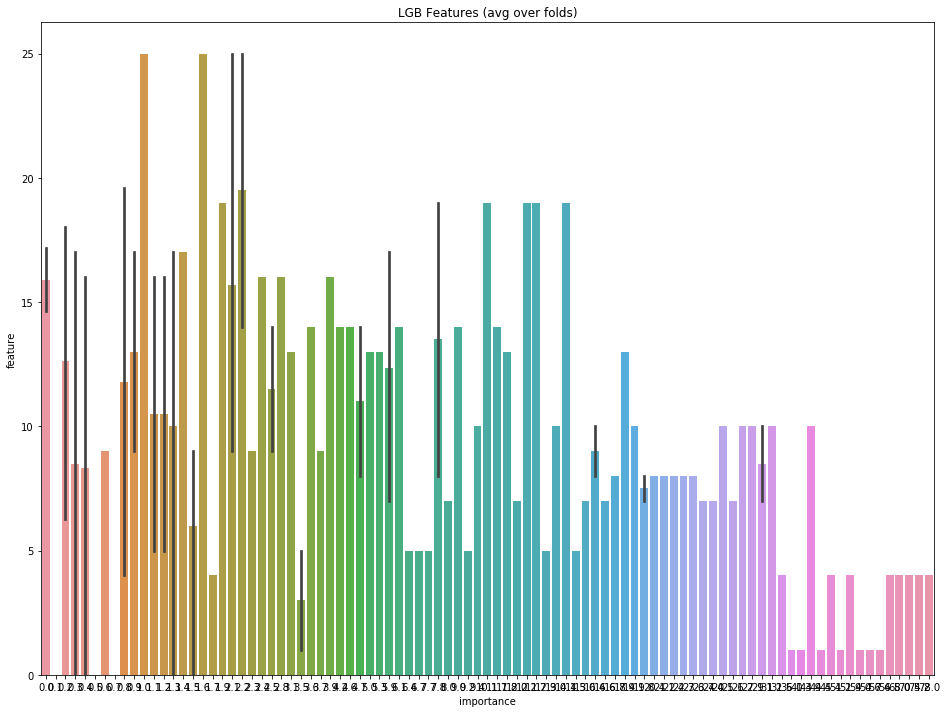

In [7]:
#lgb训练
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:01:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[452]	training's rmse: 0.0986182	valid_1's rmse: 0.0510702
Fold 1 started at Tue Dec 17 11:01:19 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.095543	valid_1's rmse: 0.0811067
[2000]	training's rmse: 0.0914105	valid_1's rmse: 0.0752921
Early stopping, best iteration is:
[2624]	training's rmse: 0.0902678	valid_1's rmse: 0.0730915
Fold 2 started at Tue Dec 17 11:01:29 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0738806	valid_1's rmse: 0.215139
Early stopping, best iteration is:
[1359]	training's rmse: 0.0725755	valid_1's rmse: 0.213502
Fold 3 started at Tue Dec 17 11:01:34 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0916601	valid_1's rmse: 0.0672808
[2000]	training's rmse: 0.0879757	valid_1's rmse: 0.058

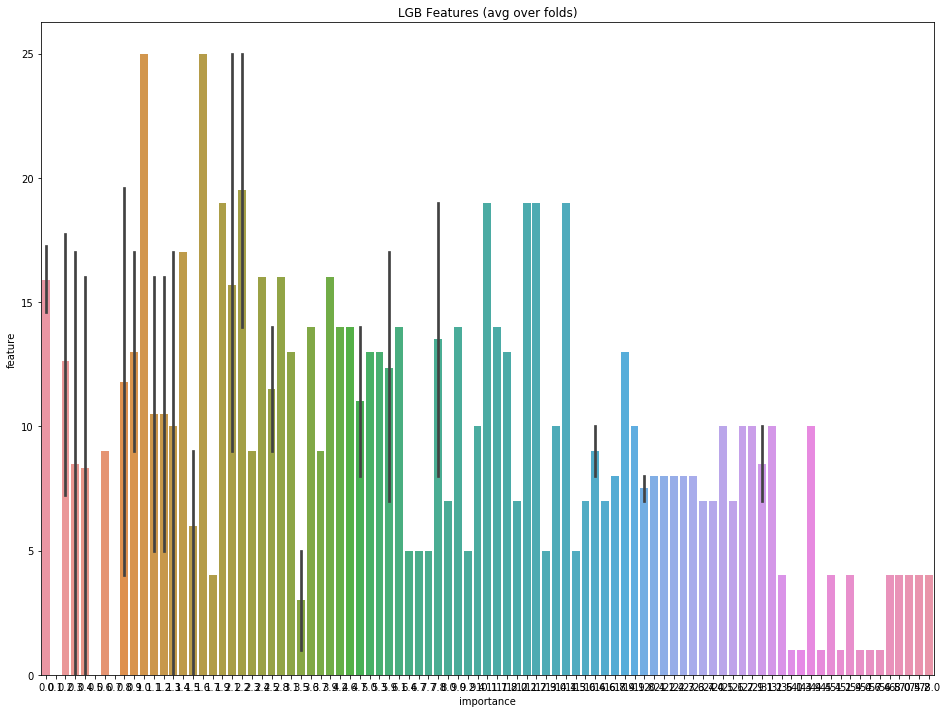

In [8]:
#交叉验证
#训练一个lgb
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_1, _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:02:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[452]	training's rmse: 0.0986182	valid_1's rmse: 0.0510702
Fold 1 started at Tue Dec 17 11:02:19 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.095543	valid_1's rmse: 0.0811067
[2000]	training's rmse: 0.0914105	valid_1's rmse: 0.0752921
Early stopping, best iteration is:
[2624]	training's rmse: 0.0902678	valid_1's rmse: 0.0730915
Fold 2 started at Tue Dec 17 11:02:25 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0738806	valid_1's rmse: 0.215139
Early stopping, best iteration is:
[1359]	training's rmse: 0.0725755	valid_1's rmse: 0.213502
Fold 3 started at Tue Dec 17 11:02:29 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0916601	valid_1's rmse: 0.0672808
[2000]	training's rmse: 0.0879757	valid_1's rmse: 0.058

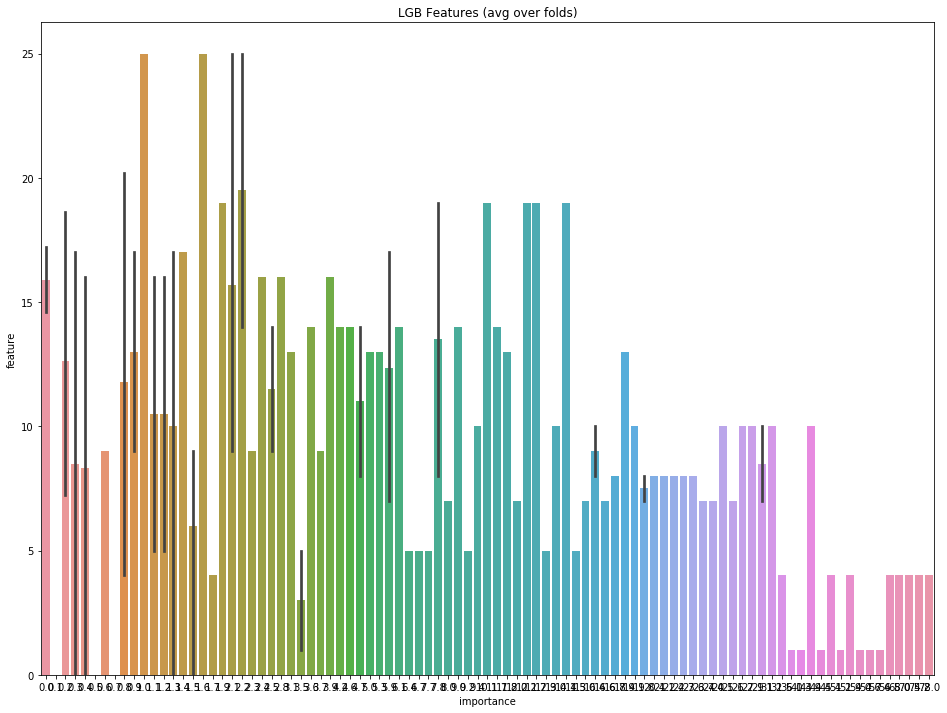

In [9]:
#另一组lgb的训练
pparams = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.02,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 5,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_2,  _ = train_model(X, y, params=params, model_type='lgb', plot_feature_importance=True)

#### random forest regression

In [10]:
#随机森林的训练
#训练rfr
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr = train_model(X,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:03:04 2019
Fold 1 started at Tue Dec 17 11:03:05 2019
Fold 2 started at Tue Dec 17 11:03:05 2019
Fold 3 started at Tue Dec 17 11:03:05 2019
Fold 4 started at Tue Dec 17 11:03:05 2019
Fold 5 started at Tue Dec 17 11:03:06 2019
Fold 6 started at Tue Dec 17 11:03:06 2019
Fold 7 started at Tue Dec 17 11:03:06 2019
Fold 8 started at Tue Dec 17 11:03:06 2019
Fold 9 started at Tue Dec 17 11:03:07 2019
CV mean score: 0.0809, std: 0.0616.


#### xgboost

In [11]:
#xgboost
#训练xgboost
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb = train_model(X,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:03:07 2019
[0]	train-rmse:0.207439	valid_data-rmse:0.15408
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[218]	train-rmse:0.045464	valid_data-rmse:0.036555

Fold 1 started at Tue Dec 17 11:03:07 2019
[0]	train-rmse:0.197715	valid_data-rmse:0.237744
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.016851	valid_data-rmse:0.060933
[1000]	train-rmse:0.009504	valid_data-rmse:0.055788
Stopping. Best iteration:
[1112]	train-rmse:0.00908	valid_data-rmse:0.055676

Fold 2 started at Tue Dec 17 11:03:08 2019
[0]	train-rmse:0.200658	valid_data-rmse:0.216155
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds

#### catboost

In [12]:
#catboost
#catboost训练
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat = train_model(X, y, params=cat_params, model_type='cat')

Fold 0 started at Tue Dec 17 11:03:11 2019
Fold 1 started at Tue Dec 17 11:03:19 2019
Fold 2 started at Tue Dec 17 11:03:45 2019
Fold 3 started at Tue Dec 17 11:03:46 2019
Fold 4 started at Tue Dec 17 11:04:39 2019
Fold 5 started at Tue Dec 17 11:05:01 2019
Fold 6 started at Tue Dec 17 11:05:43 2019
Fold 7 started at Tue Dec 17 11:06:01 2019
Fold 8 started at Tue Dec 17 11:06:09 2019
Fold 9 started at Tue Dec 17 11:06:45 2019
CV mean score: 0.0678, std: 0.0553.


### stacking

#### 所有结果均用于做stacking

In [13]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:06:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[538]	training's rmse: 0.0879345	valid_1's rmse: 0.0306672
Fold 1 started at Tue Dec 17 11:06:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[477]	training's rmse: 0.0863371	valid_1's rmse: 0.0726071
Fold 2 started at Tue Dec 17 11:06:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[357]	training's rmse: 0.0549539	valid_1's rmse: 0.224968
Fold 3 started at Tue Dec 17 11:07:00 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[555]	training's rmse: 0.0884922	valid_1's rmse: 0.0260495
Fold 4 started at Tue Dec 17 11:07:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[371]	training's rmse: 0.0866291	valid_1's rmse: 0.0643496
F

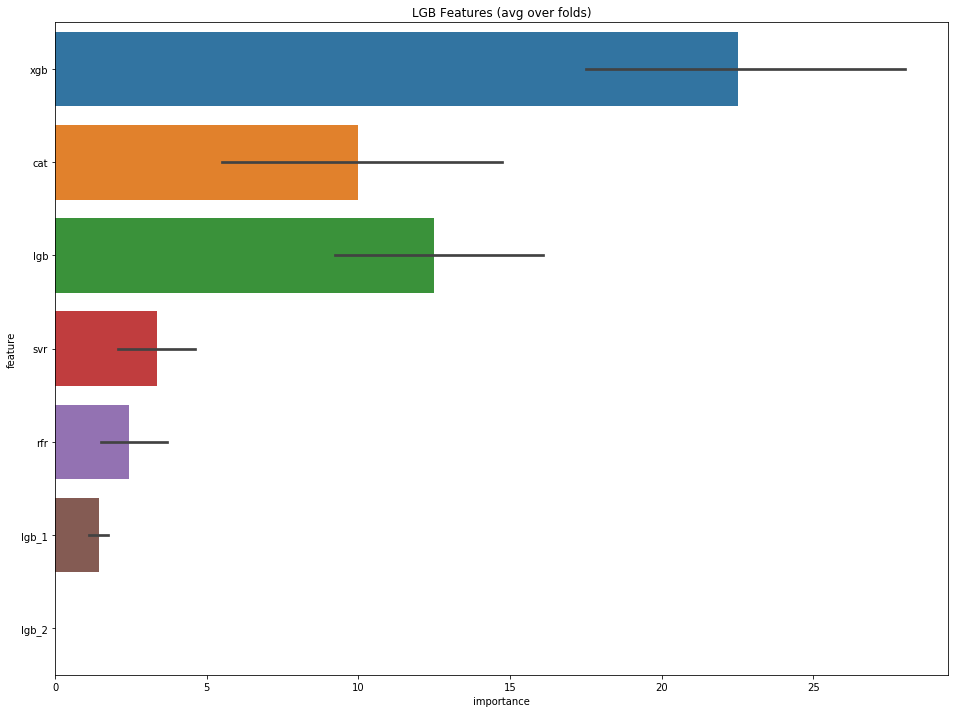

In [14]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:07:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[388]	training's rmse: 0.0850328	valid_1's rmse: 0.0297886
Fold 1 started at Tue Dec 17 11:07:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 0.0852466	valid_1's rmse: 0.0711601
Fold 2 started at Tue Dec 17 11:07:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[15]	training's rmse: 0.0998633	valid_1's rmse: 0.227202
Fold 3 started at Tue Dec 17 11:07:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[585]	training's rmse: 0.0843492	valid_1's rmse: 0.0234162
Fold 4 started at Tue Dec 17 11:07:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[602]	training's rmse: 0.0847517	valid_1's rmse: 0.0621025
Fo

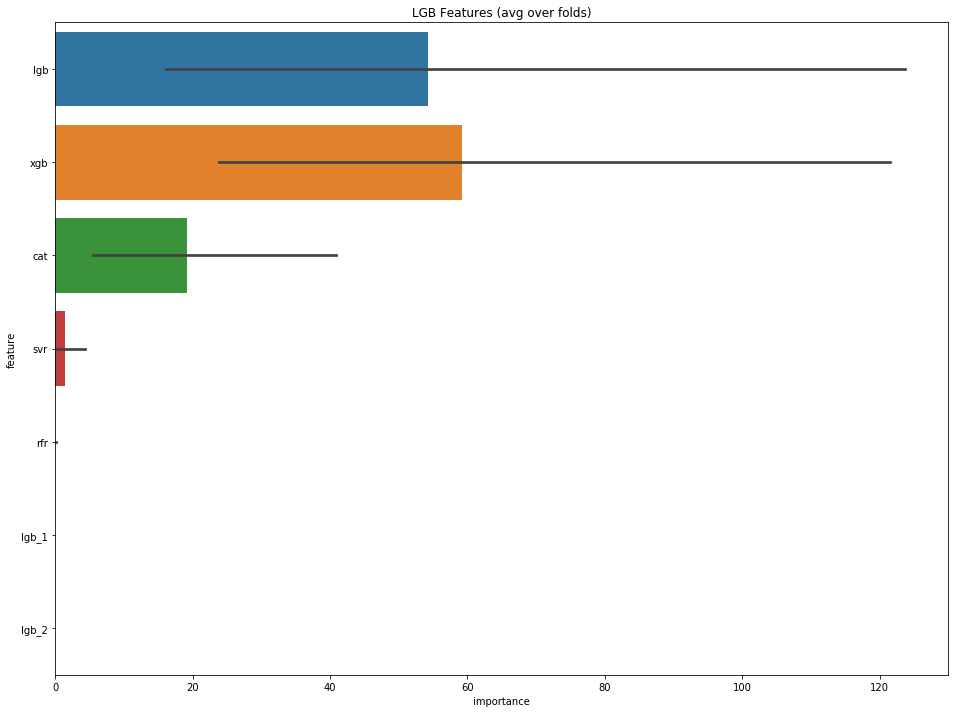

In [15]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [16]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:07:48 2019
Fold 1 started at Tue Dec 17 11:07:52 2019
Fold 2 started at Tue Dec 17 11:08:12 2019
Fold 3 started at Tue Dec 17 11:08:15 2019
Fold 4 started at Tue Dec 17 11:08:31 2019
Fold 5 started at Tue Dec 17 11:08:36 2019
Fold 6 started at Tue Dec 17 11:08:43 2019
Fold 7 started at Tue Dec 17 11:08:47 2019
Fold 8 started at Tue Dec 17 11:08:51 2019
Fold 9 started at Tue Dec 17 11:09:10 2019
CV mean score: 0.0678, std: 0.0569.


##### randomforest作为第二层融合模型

In [17]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:09:20 2019
Fold 1 started at Tue Dec 17 11:09:20 2019
Fold 2 started at Tue Dec 17 11:09:21 2019
Fold 3 started at Tue Dec 17 11:09:21 2019
Fold 4 started at Tue Dec 17 11:09:21 2019
Fold 5 started at Tue Dec 17 11:09:21 2019
Fold 6 started at Tue Dec 17 11:09:22 2019
Fold 7 started at Tue Dec 17 11:09:22 2019
Fold 8 started at Tue Dec 17 11:09:22 2019
Fold 9 started at Tue Dec 17 11:09:22 2019
CV mean score: 0.0728, std: 0.0565.


##### xgboost作为第二层融合模型

In [18]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:09:22 2019
[0]	train-rmse:0.207365	valid_data-rmse:0.154
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[247]	train-rmse:0.041517	valid_data-rmse:0.038262

Fold 1 started at Tue Dec 17 11:09:23 2019
[0]	train-rmse:0.197624	valid_data-rmse:0.237751
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.014016	valid_data-rmse:0.04645
Stopping. Best iteration:
[523]	train-rmse:0.012816	valid_data-rmse:0.046302

Fold 2 started at Tue Dec 17 11:09:23 2019
[0]	train-rmse:0.200595	valid_data-rmse:0.216465
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[48]	train-rmse:0.132518	va

##### svr 作为第二层融合模型

In [19]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:09:25 2019
Fold 1 started at Tue Dec 17 11:09:25 2019
Fold 2 started at Tue Dec 17 11:09:25 2019
Fold 3 started at Tue Dec 17 11:09:25 2019
Fold 4 started at Tue Dec 17 11:09:25 2019
Fold 5 started at Tue Dec 17 11:09:25 2019
Fold 6 started at Tue Dec 17 11:09:25 2019
Fold 7 started at Tue Dec 17 11:09:25 2019
Fold 8 started at Tue Dec 17 11:09:25 2019
Fold 9 started at Tue Dec 17 11:09:25 2019
CV mean score: 0.0794, std: 0.0521.


##### 岭回归做第二层融合模型

In [20]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:09:25 2019
Fold 1 started at Tue Dec 17 11:09:25 2019
Fold 2 started at Tue Dec 17 11:09:25 2019
Fold 3 started at Tue Dec 17 11:09:25 2019
Fold 4 started at Tue Dec 17 11:09:25 2019
Fold 5 started at Tue Dec 17 11:09:25 2019
Fold 6 started at Tue Dec 17 11:09:25 2019
Fold 7 started at Tue Dec 17 11:09:25 2019
Fold 8 started at Tue Dec 17 11:09:25 2019
Fold 9 started at Tue Dec 17 11:09:26 2019
CV mean score: 0.0661, std: 0.0532.


#### 去掉lgb的结果

In [21]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_xgb, oof_cat, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'cat', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:09:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[604]	training's rmse: 0.0910248	valid_1's rmse: 0.0292639
Fold 1 started at Tue Dec 17 11:09:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[595]	training's rmse: 0.089024	valid_1's rmse: 0.0804531
Fold 2 started at Tue Dec 17 11:09:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[148]	training's rmse: 0.0649945	valid_1's rmse: 0.229084
Fold 3 started at Tue Dec 17 11:09:34 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0880415	valid_1's rmse: 0.0228015
Early stopping, best iteration is:
[1316]	training's rmse: 0.0873043	valid_1's rmse: 0.0225569
Fold 4 started at Tue Dec 17 11:09:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:


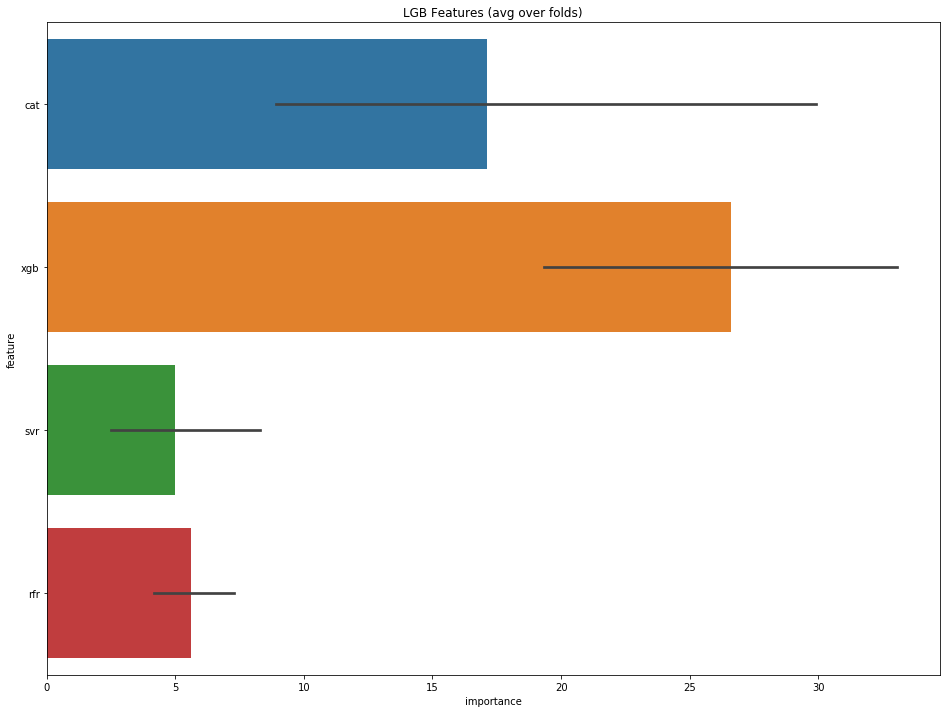

In [22]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:09:57 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0867547	valid_1's rmse: 0.0296008
[2000]	training's rmse: 0.0867416	valid_1's rmse: 0.0295901
Early stopping, best iteration is:
[2732]	training's rmse: 0.0867416	valid_1's rmse: 0.0295901
Fold 1 started at Tue Dec 17 11:10:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[458]	training's rmse: 0.0864571	valid_1's rmse: 0.0793066
Fold 2 started at Tue Dec 17 11:10:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[15]	training's rmse: 0.0998633	valid_1's rmse: 0.227202
Fold 3 started at Tue Dec 17 11:10:11 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0861144	valid_1's rmse: 0.0197316
Early stopping, best iteration is:
[1399]	training's rmse: 0.0861117	valid_1's rmse: 0.0197243
Fold 4 started at Tu

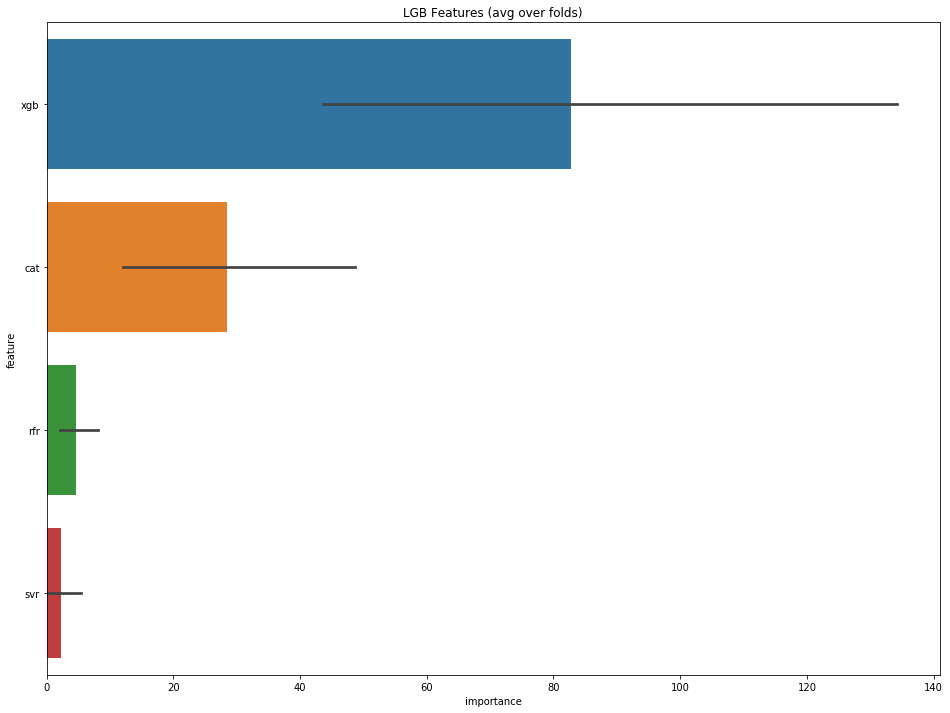

In [23]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [24]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:10:41 2019
Fold 1 started at Tue Dec 17 11:10:51 2019
Fold 2 started at Tue Dec 17 11:11:00 2019
Fold 3 started at Tue Dec 17 11:11:04 2019
Fold 4 started at Tue Dec 17 11:11:14 2019
Fold 5 started at Tue Dec 17 11:11:18 2019
Fold 6 started at Tue Dec 17 11:11:37 2019
Fold 7 started at Tue Dec 17 11:11:40 2019
Fold 8 started at Tue Dec 17 11:11:46 2019
Fold 9 started at Tue Dec 17 11:12:07 2019
CV mean score: 0.0664, std: 0.0563.


##### randomforest作为第二层融合模型

In [25]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:12:12 2019
Fold 1 started at Tue Dec 17 11:12:12 2019
Fold 2 started at Tue Dec 17 11:12:12 2019
Fold 3 started at Tue Dec 17 11:12:13 2019
Fold 4 started at Tue Dec 17 11:12:13 2019
Fold 5 started at Tue Dec 17 11:12:13 2019
Fold 6 started at Tue Dec 17 11:12:13 2019
Fold 7 started at Tue Dec 17 11:12:13 2019
Fold 8 started at Tue Dec 17 11:12:14 2019
Fold 9 started at Tue Dec 17 11:12:14 2019
CV mean score: 0.0687, std: 0.0606.


##### xgboost作为第二层融合模型

In [26]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:12:14 2019
[0]	train-rmse:0.207417	valid_data-rmse:0.154117
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.01459	valid_data-rmse:0.039802
Stopping. Best iteration:
[313]	train-rmse:0.031188	valid_data-rmse:0.038986

Fold 1 started at Tue Dec 17 11:12:14 2019
[0]	train-rmse:0.197628	valid_data-rmse:0.237737
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.014459	valid_data-rmse:0.042318
[1000]	train-rmse:0.002533	valid_data-rmse:0.039504
[1500]	train-rmse:0.000812	valid_data-rmse:0.039311
Stopping. Best iteration:
[1352]	train-rmse:0.000976	valid_data-rmse:0.039298

Fold 2 started at Tue Dec 17 11:12:15 2019
[0]	train-rmse:0.200606	valid_data-rmse:0.21615
Multiple eval metrics have been passed: 'valid_data

##### svr 作为第二层融合模型

In [27]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:12:17 2019
Fold 1 started at Tue Dec 17 11:12:17 2019
Fold 2 started at Tue Dec 17 11:12:17 2019
Fold 3 started at Tue Dec 17 11:12:17 2019
Fold 4 started at Tue Dec 17 11:12:17 2019
Fold 5 started at Tue Dec 17 11:12:17 2019
Fold 6 started at Tue Dec 17 11:12:17 2019
Fold 7 started at Tue Dec 17 11:12:17 2019
Fold 8 started at Tue Dec 17 11:12:17 2019
Fold 9 started at Tue Dec 17 11:12:17 2019
CV mean score: 0.0789, std: 0.0531.


##### 岭回归做第二层融合模型

In [28]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:12:17 2019
Fold 1 started at Tue Dec 17 11:12:17 2019
Fold 2 started at Tue Dec 17 11:12:17 2019
Fold 3 started at Tue Dec 17 11:12:17 2019
Fold 4 started at Tue Dec 17 11:12:17 2019
Fold 5 started at Tue Dec 17 11:12:17 2019
Fold 6 started at Tue Dec 17 11:12:18 2019
Fold 7 started at Tue Dec 17 11:12:18 2019
Fold 8 started at Tue Dec 17 11:12:18 2019
Fold 9 started at Tue Dec 17 11:12:18 2019
CV mean score: 0.0674, std: 0.0557.


#### 去掉xgboost的结果

In [29]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_cat, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:12:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[602]	training's rmse: 0.0921567	valid_1's rmse: 0.0352584
Fold 1 started at Tue Dec 17 11:12:20 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0926618	valid_1's rmse: 0.07053
Early stopping, best iteration is:
[983]	training's rmse: 0.0927057	valid_1's rmse: 0.0703472
Fold 2 started at Tue Dec 17 11:12:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2]	training's rmse: 0.107748	valid_1's rmse: 0.231304
Fold 3 started at Tue Dec 17 11:12:24 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0902135	valid_1's rmse: 0.0382509
Early stopping, best iteration is:
[1051]	training's rmse: 0.0900427	valid_1's rmse: 0.0380877
Fold 4 started at Tue Dec 17 11:12:28 2019
Training until validation scores don't imp

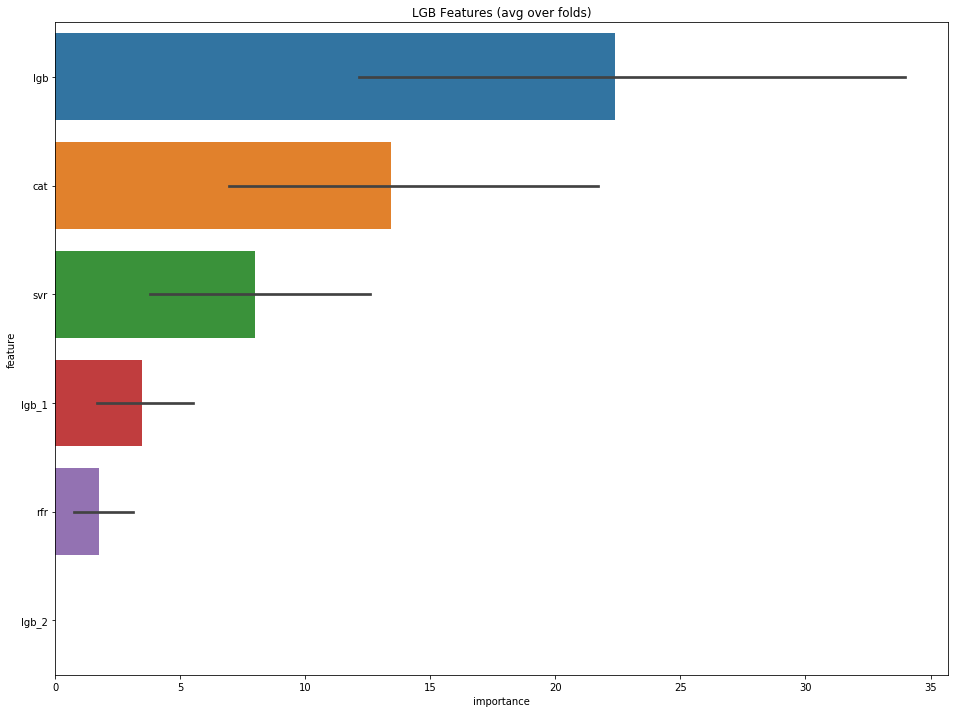

In [30]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:12:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[466]	training's rmse: 0.0898579	valid_1's rmse: 0.0421454
Fold 1 started at Tue Dec 17 11:12:45 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0909268	valid_1's rmse: 0.0685593
[2000]	training's rmse: 0.0892321	valid_1's rmse: 0.0681646
Early stopping, best iteration is:
[2595]	training's rmse: 0.0887251	valid_1's rmse: 0.0680787
Fold 2 started at Tue Dec 17 11:12:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108235	valid_1's rmse: 0.231746
Fold 3 started at Tue Dec 17 11:12:56 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0895501	valid_1's rmse: 0.0385682
[2000]	training's rmse: 0.088846	valid_1's rmse: 0.0376862
[3000]	training's rmse: 0.0884896	valid_1's rmse: 0.037327

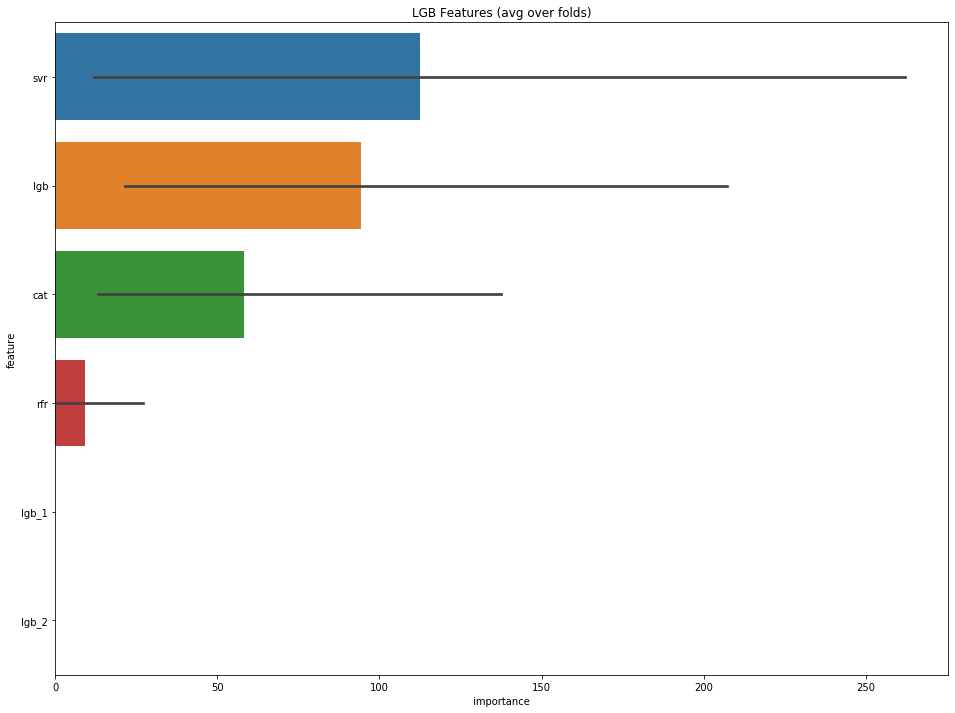

In [31]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [32]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:14:11 2019
Fold 1 started at Tue Dec 17 11:14:16 2019
Fold 2 started at Tue Dec 17 11:14:29 2019
Fold 3 started at Tue Dec 17 11:14:30 2019
Fold 4 started at Tue Dec 17 11:14:42 2019
Fold 5 started at Tue Dec 17 11:15:03 2019
Fold 6 started at Tue Dec 17 11:15:19 2019
Fold 7 started at Tue Dec 17 11:15:23 2019
Fold 8 started at Tue Dec 17 11:15:24 2019
Fold 9 started at Tue Dec 17 11:15:38 2019
CV mean score: 0.0715, std: 0.0563.


##### randomforest作为第二层融合模型

In [33]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:15:47 2019
Fold 1 started at Tue Dec 17 11:15:47 2019
Fold 2 started at Tue Dec 17 11:15:47 2019
Fold 3 started at Tue Dec 17 11:15:47 2019
Fold 4 started at Tue Dec 17 11:15:47 2019
Fold 5 started at Tue Dec 17 11:15:48 2019
Fold 6 started at Tue Dec 17 11:15:48 2019
Fold 7 started at Tue Dec 17 11:15:48 2019
Fold 8 started at Tue Dec 17 11:15:48 2019
Fold 9 started at Tue Dec 17 11:15:49 2019
CV mean score: 0.0785, std: 0.0561.


##### xgboost作为第二层融合模型

In [34]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:15:49 2019
[0]	train-rmse:0.207366	valid_data-rmse:0.154014
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[269]	train-rmse:0.037178	valid_data-rmse:0.043215

Fold 1 started at Tue Dec 17 11:15:49 2019
[0]	train-rmse:0.197635	valid_data-rmse:0.237751
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.014168	valid_data-rmse:0.049279
Stopping. Best iteration:
[428]	train-rmse:0.018627	valid_data-rmse:0.049003

Fold 2 started at Tue Dec 17 11:15:49 2019
[0]	train-rmse:0.200593	valid_data-rmse:0.2164
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[35]	train-rmse:0.148212	

##### svr 作为第二层融合模型

In [35]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:15:51 2019
Fold 1 started at Tue Dec 17 11:15:51 2019
Fold 2 started at Tue Dec 17 11:15:51 2019
Fold 3 started at Tue Dec 17 11:15:51 2019
Fold 4 started at Tue Dec 17 11:15:51 2019
Fold 5 started at Tue Dec 17 11:15:51 2019
Fold 6 started at Tue Dec 17 11:15:51 2019
Fold 7 started at Tue Dec 17 11:15:51 2019
Fold 8 started at Tue Dec 17 11:15:51 2019
Fold 9 started at Tue Dec 17 11:15:51 2019
CV mean score: 0.0801, std: 0.0542.


##### 岭回归做第二层融合模型

In [36]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:15:51 2019
Fold 1 started at Tue Dec 17 11:15:51 2019
Fold 2 started at Tue Dec 17 11:15:51 2019
Fold 3 started at Tue Dec 17 11:15:51 2019
Fold 4 started at Tue Dec 17 11:15:51 2019
Fold 5 started at Tue Dec 17 11:15:52 2019
Fold 6 started at Tue Dec 17 11:15:52 2019
Fold 7 started at Tue Dec 17 11:15:52 2019
Fold 8 started at Tue Dec 17 11:15:52 2019
Fold 9 started at Tue Dec 17 11:15:52 2019
CV mean score: 0.0692, std: 0.0538.


#### 去掉svr的结果

In [37]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:15:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[395]	training's rmse: 0.0888229	valid_1's rmse: 0.030848
Fold 1 started at Tue Dec 17 11:15:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[415]	training's rmse: 0.0868037	valid_1's rmse: 0.072856
Fold 2 started at Tue Dec 17 11:15:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[455]	training's rmse: 0.0543979	valid_1's rmse: 0.223459
Fold 3 started at Tue Dec 17 11:15:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[555]	training's rmse: 0.0885521	valid_1's rmse: 0.0265223
Fold 4 started at Tue Dec 17 11:15:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[376]	training's rmse: 0.0872006	valid_1's rmse: 0.0631834
Fol

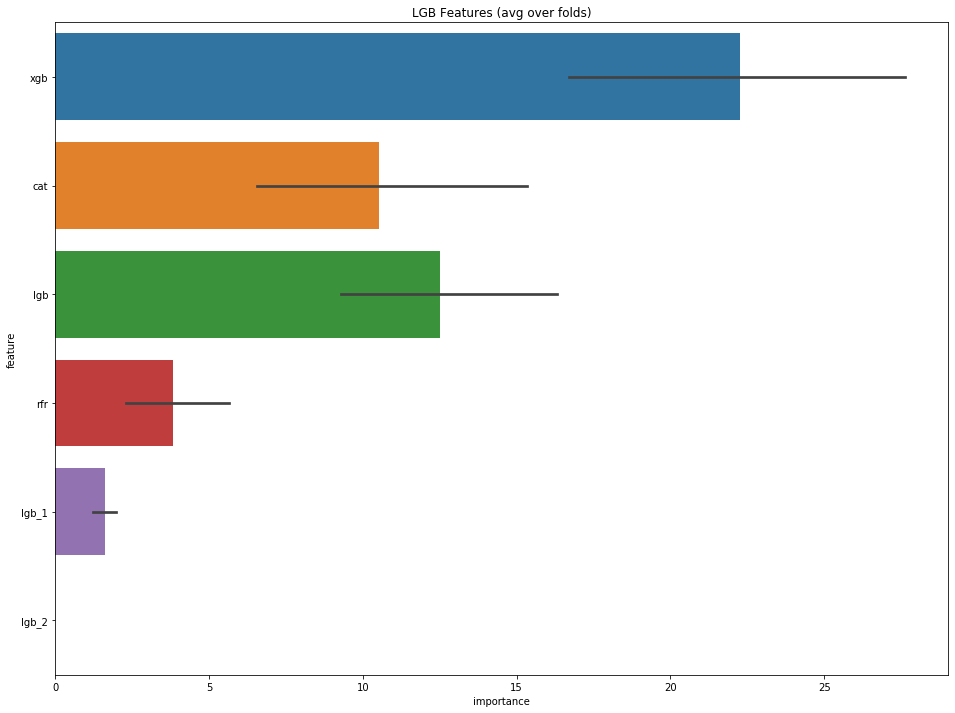

In [38]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:16:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[388]	training's rmse: 0.0850328	valid_1's rmse: 0.0297886
Fold 1 started at Tue Dec 17 11:16:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 0.0852466	valid_1's rmse: 0.0711601
Fold 2 started at Tue Dec 17 11:16:15 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[15]	training's rmse: 0.0998633	valid_1's rmse: 0.227202
Fold 3 started at Tue Dec 17 11:16:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[585]	training's rmse: 0.0843492	valid_1's rmse: 0.0234162
Fold 4 started at Tue Dec 17 11:16:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[610]	training's rmse: 0.084856	valid_1's rmse: 0.0612436
Fol

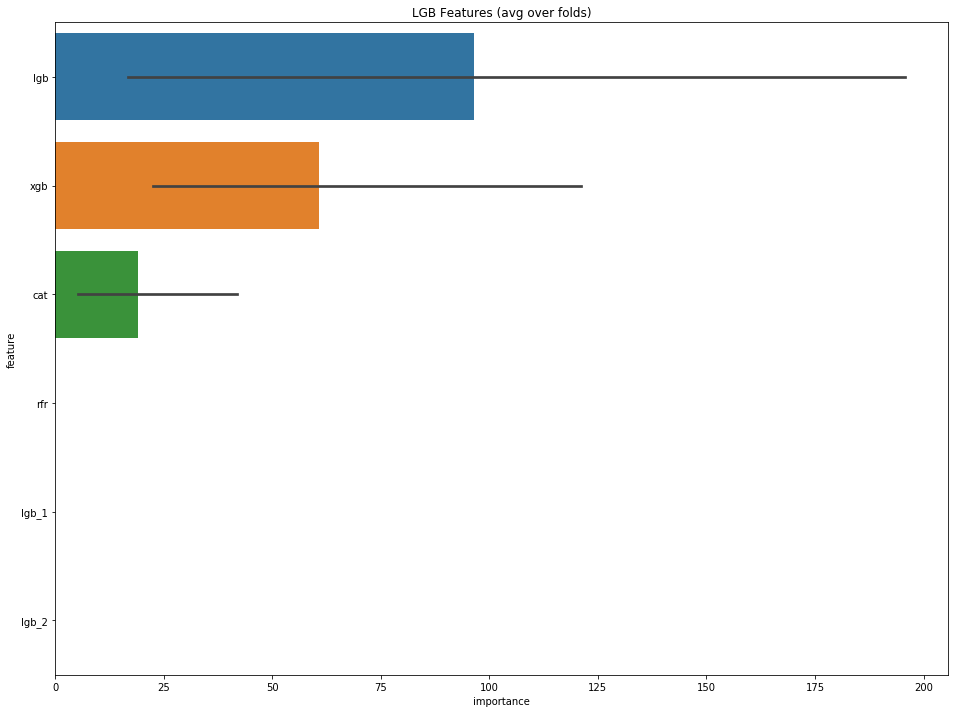

In [39]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [40]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:16:56 2019
Fold 1 started at Tue Dec 17 11:17:02 2019
Fold 2 started at Tue Dec 17 11:17:14 2019
Fold 3 started at Tue Dec 17 11:17:27 2019
Fold 4 started at Tue Dec 17 11:17:43 2019
Fold 5 started at Tue Dec 17 11:17:52 2019
Fold 6 started at Tue Dec 17 11:18:12 2019
Fold 7 started at Tue Dec 17 11:18:15 2019
Fold 8 started at Tue Dec 17 11:18:18 2019
Fold 9 started at Tue Dec 17 11:18:37 2019
CV mean score: 0.0669, std: 0.0540.


##### randomforest作为第二层融合模型

In [41]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:18:46 2019
Fold 1 started at Tue Dec 17 11:18:46 2019
Fold 2 started at Tue Dec 17 11:18:46 2019
Fold 3 started at Tue Dec 17 11:18:46 2019
Fold 4 started at Tue Dec 17 11:18:47 2019
Fold 5 started at Tue Dec 17 11:18:47 2019
Fold 6 started at Tue Dec 17 11:18:47 2019
Fold 7 started at Tue Dec 17 11:18:47 2019
Fold 8 started at Tue Dec 17 11:18:47 2019
Fold 9 started at Tue Dec 17 11:18:48 2019
CV mean score: 0.0718, std: 0.0523.


##### xgboost作为第二层融合模型

In [42]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:18:48 2019
[0]	train-rmse:0.207365	valid_data-rmse:0.154
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.014382	valid_data-rmse:0.04185
Stopping. Best iteration:
[310]	train-rmse:0.03126	valid_data-rmse:0.041488

Fold 1 started at Tue Dec 17 11:18:48 2019
[0]	train-rmse:0.197624	valid_data-rmse:0.237751
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.014212	valid_data-rmse:0.060686
Stopping. Best iteration:
[315]	train-rmse:0.031065	valid_data-rmse:0.057714

Fold 2 started at Tue Dec 17 11:18:48 2019
[0]	train-rmse:0.200595	valid_data-rmse:0.216483
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Sto

##### svr 作为第二层融合模型

In [43]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:18:50 2019
Fold 1 started at Tue Dec 17 11:18:50 2019
Fold 2 started at Tue Dec 17 11:18:50 2019
Fold 3 started at Tue Dec 17 11:18:50 2019
Fold 4 started at Tue Dec 17 11:18:50 2019
Fold 5 started at Tue Dec 17 11:18:50 2019
Fold 6 started at Tue Dec 17 11:18:50 2019
Fold 7 started at Tue Dec 17 11:18:50 2019
Fold 8 started at Tue Dec 17 11:18:50 2019
Fold 9 started at Tue Dec 17 11:18:50 2019
CV mean score: 0.0791, std: 0.0514.


##### 岭回归做第二层融合模型

In [44]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:18:50 2019
Fold 1 started at Tue Dec 17 11:18:50 2019
Fold 2 started at Tue Dec 17 11:18:50 2019
Fold 3 started at Tue Dec 17 11:18:50 2019
Fold 4 started at Tue Dec 17 11:18:51 2019
Fold 5 started at Tue Dec 17 11:18:51 2019
Fold 6 started at Tue Dec 17 11:18:51 2019
Fold 7 started at Tue Dec 17 11:18:51 2019
Fold 8 started at Tue Dec 17 11:18:51 2019
Fold 9 started at Tue Dec 17 11:18:51 2019
CV mean score: 0.0630, std: 0.0508.


#### 去掉rfr的结果

In [45]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:18:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[474]	training's rmse: 0.0883426	valid_1's rmse: 0.0304297
Fold 1 started at Tue Dec 17 11:18:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[475]	training's rmse: 0.0863763	valid_1's rmse: 0.0722934
Fold 2 started at Tue Dec 17 11:18:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[403]	training's rmse: 0.0556326	valid_1's rmse: 0.220873
Fold 3 started at Tue Dec 17 11:18:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[519]	training's rmse: 0.0887075	valid_1's rmse: 0.0264959
Fold 4 started at Tue Dec 17 11:19:02 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[371]	training's rmse: 0.0869099	valid_1's rmse: 0.0646512
F

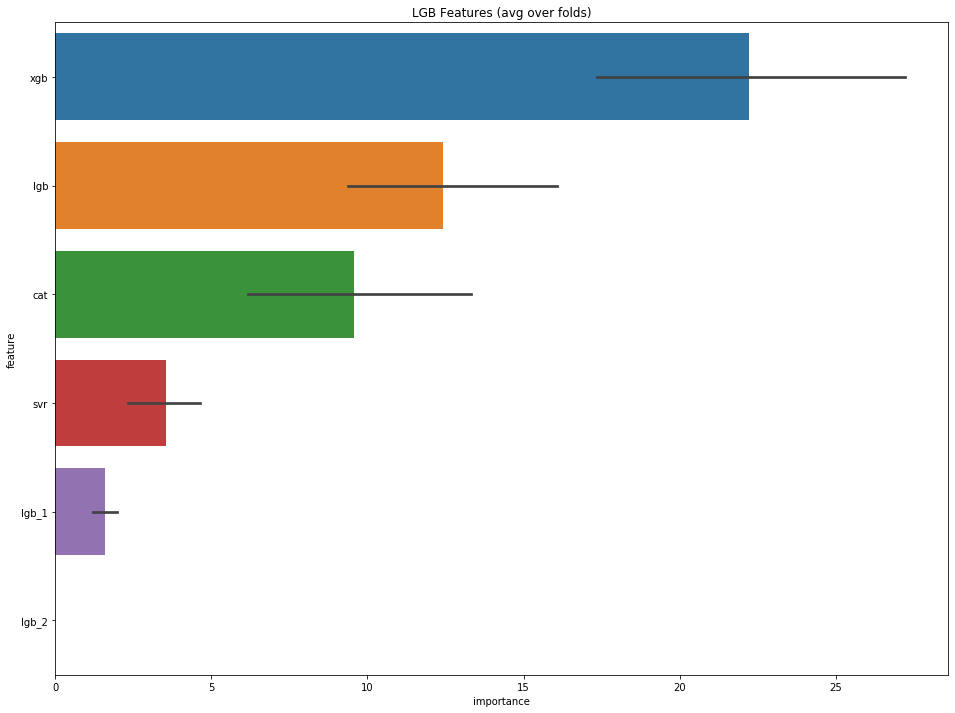

In [46]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:19:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[395]	training's rmse: 0.0849884	valid_1's rmse: 0.029803
Fold 1 started at Tue Dec 17 11:19:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 0.0852466	valid_1's rmse: 0.0711601
Fold 2 started at Tue Dec 17 11:19:27 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.052939	valid_1's rmse: 0.221776
Early stopping, best iteration is:
[1288]	training's rmse: 0.0529165	valid_1's rmse: 0.221755
Fold 3 started at Tue Dec 17 11:19:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[585]	training's rmse: 0.0843492	valid_1's rmse: 0.0234162
Fold 4 started at Tue Dec 17 11:19:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[6

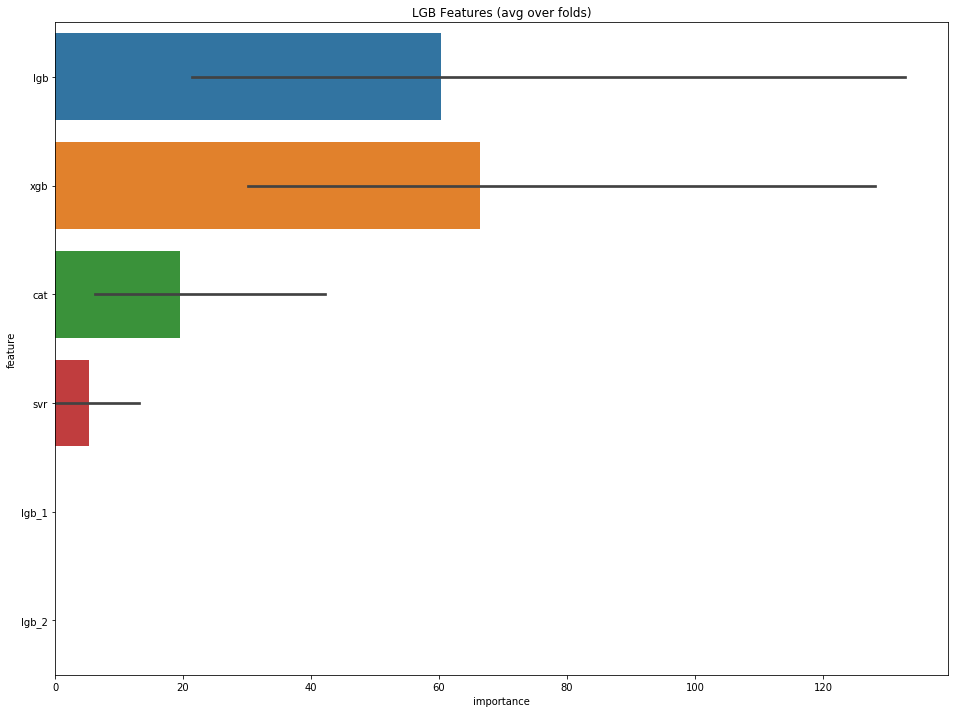

In [47]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [48]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:20:11 2019
Fold 1 started at Tue Dec 17 11:20:15 2019
Fold 2 started at Tue Dec 17 11:20:27 2019
Fold 3 started at Tue Dec 17 11:20:32 2019
Fold 4 started at Tue Dec 17 11:20:50 2019
Fold 5 started at Tue Dec 17 11:20:56 2019
Fold 6 started at Tue Dec 17 11:21:04 2019
Fold 7 started at Tue Dec 17 11:21:07 2019
Fold 8 started at Tue Dec 17 11:21:09 2019
Fold 9 started at Tue Dec 17 11:21:19 2019
CV mean score: 0.0674, std: 0.0558.


##### randomforest作为第二层融合模型

In [49]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:21:28 2019
Fold 1 started at Tue Dec 17 11:21:29 2019
Fold 2 started at Tue Dec 17 11:21:29 2019
Fold 3 started at Tue Dec 17 11:21:29 2019
Fold 4 started at Tue Dec 17 11:21:29 2019
Fold 5 started at Tue Dec 17 11:21:29 2019
Fold 6 started at Tue Dec 17 11:21:30 2019
Fold 7 started at Tue Dec 17 11:21:30 2019
Fold 8 started at Tue Dec 17 11:21:30 2019
Fold 9 started at Tue Dec 17 11:21:30 2019
CV mean score: 0.0700, std: 0.0529.


##### xgboost作为第二层融合模型

In [50]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:21:31 2019
[0]	train-rmse:0.207365	valid_data-rmse:0.154
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[225]	train-rmse:0.047174	valid_data-rmse:0.039777

Fold 1 started at Tue Dec 17 11:21:31 2019
[0]	train-rmse:0.197624	valid_data-rmse:0.237751
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.015067	valid_data-rmse:0.049698
Stopping. Best iteration:
[473]	train-rmse:0.016587	valid_data-rmse:0.049648

Fold 2 started at Tue Dec 17 11:21:31 2019
[0]	train-rmse:0.200595	valid_data-rmse:0.216465
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[67]	train-rmse:0.113287	v

##### svr 作为第二层融合模型

In [51]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:21:32 2019
Fold 1 started at Tue Dec 17 11:21:32 2019
Fold 2 started at Tue Dec 17 11:21:32 2019
Fold 3 started at Tue Dec 17 11:21:32 2019
Fold 4 started at Tue Dec 17 11:21:32 2019
Fold 5 started at Tue Dec 17 11:21:32 2019
Fold 6 started at Tue Dec 17 11:21:32 2019
Fold 7 started at Tue Dec 17 11:21:32 2019
Fold 8 started at Tue Dec 17 11:21:32 2019
Fold 9 started at Tue Dec 17 11:21:32 2019
CV mean score: 0.0800, std: 0.0503.


##### 岭回归做第二层融合模型

In [52]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:21:33 2019
Fold 1 started at Tue Dec 17 11:21:33 2019
Fold 2 started at Tue Dec 17 11:21:33 2019
Fold 3 started at Tue Dec 17 11:21:33 2019
Fold 4 started at Tue Dec 17 11:21:33 2019
Fold 5 started at Tue Dec 17 11:21:33 2019
Fold 6 started at Tue Dec 17 11:21:33 2019
Fold 7 started at Tue Dec 17 11:21:33 2019
Fold 8 started at Tue Dec 17 11:21:33 2019
Fold 9 started at Tue Dec 17 11:21:33 2019
CV mean score: 0.0649, std: 0.0536.


#### 去掉catboost的结果

In [53]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:21:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[336]	training's rmse: 0.0907898	valid_1's rmse: 0.0364719
Fold 1 started at Tue Dec 17 11:21:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[475]	training's rmse: 0.0860306	valid_1's rmse: 0.0714625
Fold 2 started at Tue Dec 17 11:21:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[237]	training's rmse: 0.0578044	valid_1's rmse: 0.219156
Fold 3 started at Tue Dec 17 11:21:40 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0902406	valid_1's rmse: 0.0293635
Early stopping, best iteration is:
[922]	training's rmse: 0.0902509	valid_1's rmse: 0.0293261
Fold 4 started at Tue Dec 17 11:21:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:


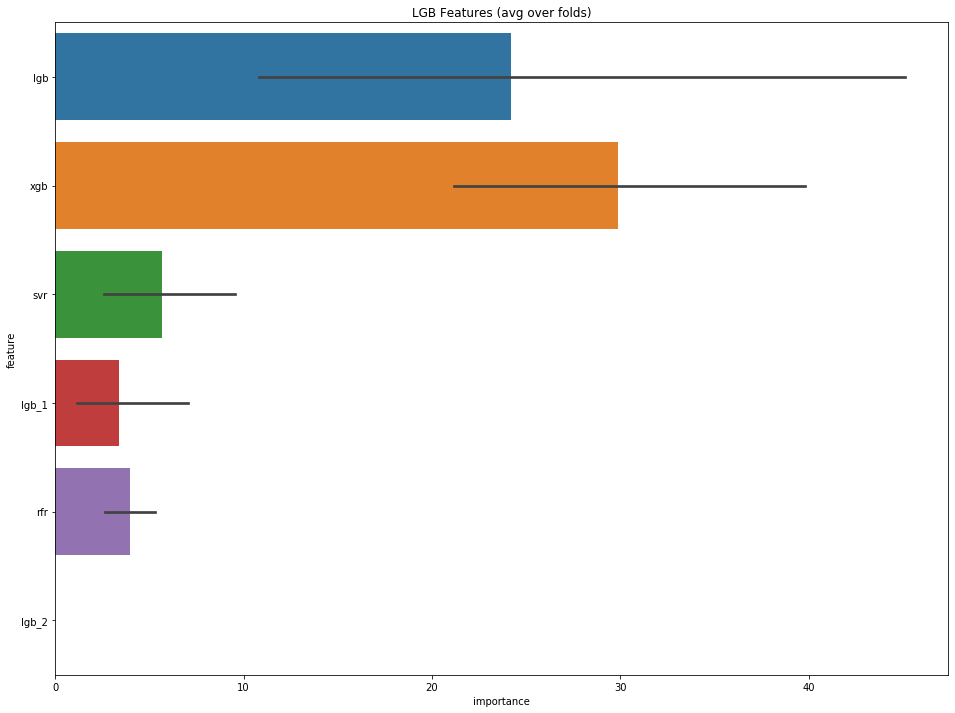

In [54]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:22:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[348]	training's rmse: 0.0893284	valid_1's rmse: 0.0337722
Fold 1 started at Tue Dec 17 11:22:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 0.0852466	valid_1's rmse: 0.0711601
Fold 2 started at Tue Dec 17 11:22:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[30]	training's rmse: 0.0925396	valid_1's rmse: 0.223902
Fold 3 started at Tue Dec 17 11:22:09 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0890077	valid_1's rmse: 0.0274757
Early stopping, best iteration is:
[809]	training's rmse: 0.0890486	valid_1's rmse: 0.0274571
Fold 4 started at Tue Dec 17 11:22:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[

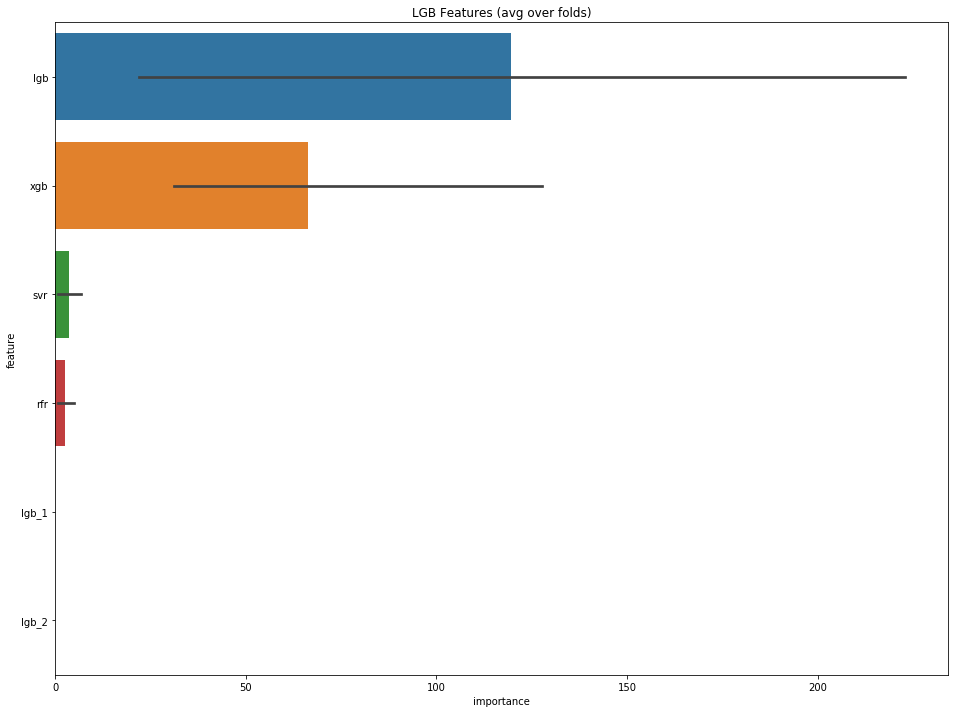

In [55]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [56]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:23:06 2019
Fold 1 started at Tue Dec 17 11:23:10 2019
Fold 2 started at Tue Dec 17 11:23:23 2019
Fold 3 started at Tue Dec 17 11:23:26 2019
Fold 4 started at Tue Dec 17 11:23:41 2019
Fold 5 started at Tue Dec 17 11:23:48 2019
Fold 6 started at Tue Dec 17 11:23:56 2019
Fold 7 started at Tue Dec 17 11:23:59 2019
Fold 8 started at Tue Dec 17 11:24:00 2019
Fold 9 started at Tue Dec 17 11:24:13 2019
CV mean score: 0.0694, std: 0.0563.


##### randomforest作为第二层融合模型

In [57]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:24:22 2019
Fold 1 started at Tue Dec 17 11:24:22 2019
Fold 2 started at Tue Dec 17 11:24:22 2019
Fold 3 started at Tue Dec 17 11:24:23 2019
Fold 4 started at Tue Dec 17 11:24:23 2019
Fold 5 started at Tue Dec 17 11:24:23 2019
Fold 6 started at Tue Dec 17 11:24:23 2019
Fold 7 started at Tue Dec 17 11:24:24 2019
Fold 8 started at Tue Dec 17 11:24:24 2019
Fold 9 started at Tue Dec 17 11:24:24 2019
CV mean score: 0.0743, std: 0.0559.


##### xgboost作为第二层融合模型

In [58]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:24:24 2019
[0]	train-rmse:0.207365	valid_data-rmse:0.153841
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[217]	train-rmse:0.049125	valid_data-rmse:0.043655

Fold 1 started at Tue Dec 17 11:24:24 2019
[0]	train-rmse:0.197666	valid_data-rmse:0.237836
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.015262	valid_data-rmse:0.04701
Stopping. Best iteration:
[579]	train-rmse:0.011459	valid_data-rmse:0.046767

Fold 2 started at Tue Dec 17 11:24:25 2019
[0]	train-rmse:0.200596	valid_data-rmse:0.216483
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[68]	train-rmse:0.112645

##### svr 作为第二层融合模型

In [59]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:24:26 2019
Fold 1 started at Tue Dec 17 11:24:26 2019
Fold 2 started at Tue Dec 17 11:24:26 2019
Fold 3 started at Tue Dec 17 11:24:26 2019
Fold 4 started at Tue Dec 17 11:24:26 2019
Fold 5 started at Tue Dec 17 11:24:26 2019
Fold 6 started at Tue Dec 17 11:24:26 2019
Fold 7 started at Tue Dec 17 11:24:26 2019
Fold 8 started at Tue Dec 17 11:24:26 2019
Fold 9 started at Tue Dec 17 11:24:26 2019
CV mean score: 0.0806, std: 0.0515.


##### 岭回归做第二层融合模型

In [60]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:24:26 2019
Fold 1 started at Tue Dec 17 11:24:26 2019
Fold 2 started at Tue Dec 17 11:24:26 2019
Fold 3 started at Tue Dec 17 11:24:26 2019
Fold 4 started at Tue Dec 17 11:24:27 2019
Fold 5 started at Tue Dec 17 11:24:27 2019
Fold 6 started at Tue Dec 17 11:24:27 2019
Fold 7 started at Tue Dec 17 11:24:27 2019
Fold 8 started at Tue Dec 17 11:24:27 2019
Fold 9 started at Tue Dec 17 11:24:27 2019
CV mean score: 0.0667, std: 0.0544.


#### 去掉xgb和lgb的结果

In [61]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:24:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[291]	training's rmse: 0.102791	valid_1's rmse: 0.0436094
Fold 1 started at Tue Dec 17 11:24:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[349]	training's rmse: 0.104565	valid_1's rmse: 0.0839601
Fold 2 started at Tue Dec 17 11:24:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108249	valid_1's rmse: 0.231752
Fold 3 started at Tue Dec 17 11:24:31 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0935094	valid_1's rmse: 0.0428087
[2000]	training's rmse: 0.0911717	valid_1's rmse: 0.0417553
Early stopping, best iteration is:
[2177]	training's rmse: 0.0908195	valid_1's rmse: 0.0416402
Fold 4 started at Tue Dec 17 11:24:39 2019
Training until validation scores don't imp

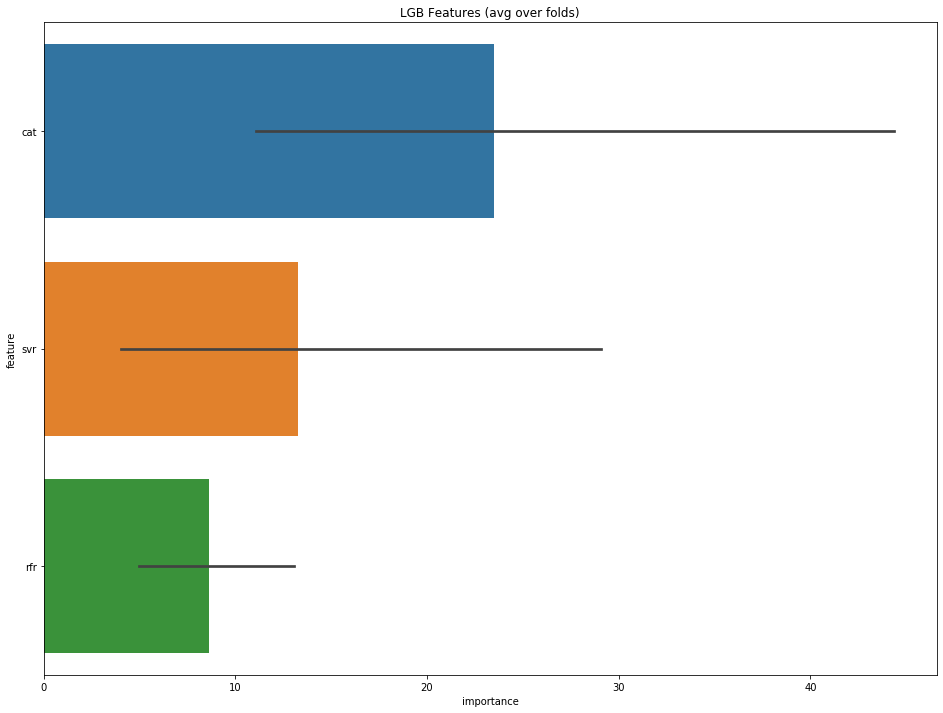

In [62]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:24:50 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0972503	valid_1's rmse: 0.0457701
[2000]	training's rmse: 0.0972487	valid_1's rmse: 0.0457618
Early stopping, best iteration is:
[2219]	training's rmse: 0.097247	valid_1's rmse: 0.0457552
Fold 1 started at Tue Dec 17 11:24:58 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.103204	valid_1's rmse: 0.0811391
[2000]	training's rmse: 0.103202	valid_1's rmse: 0.0811336
Early stopping, best iteration is:
[2364]	training's rmse: 0.103202	valid_1's rmse: 0.0811336
Fold 2 started at Tue Dec 17 11:25:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108235	valid_1's rmse: 0.231746
Fold 3 started at Tue Dec 17 11:25:06 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0930735	valid_1's rmse: 0.0438987


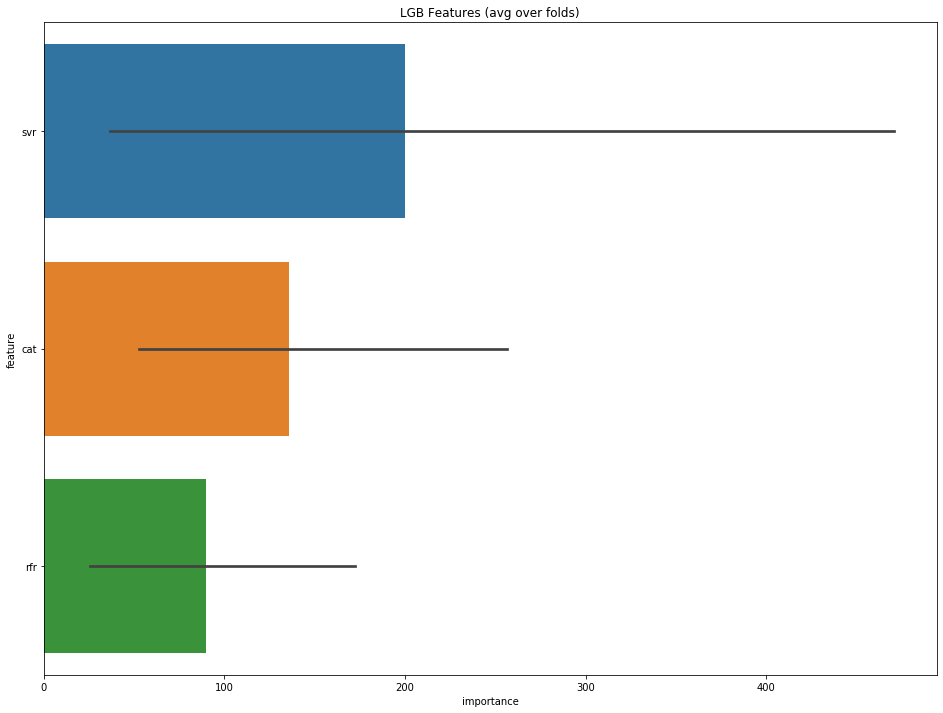

In [63]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [64]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:26:36 2019
Fold 1 started at Tue Dec 17 11:26:40 2019
Fold 2 started at Tue Dec 17 11:26:50 2019
Fold 3 started at Tue Dec 17 11:26:50 2019
Fold 4 started at Tue Dec 17 11:26:59 2019
Fold 5 started at Tue Dec 17 11:27:09 2019
Fold 6 started at Tue Dec 17 11:27:23 2019
Fold 7 started at Tue Dec 17 11:27:26 2019
Fold 8 started at Tue Dec 17 11:27:30 2019
Fold 9 started at Tue Dec 17 11:27:44 2019
CV mean score: 0.0716, std: 0.0547.


##### randomforest作为第二层融合模型

In [65]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:27:48 2019
Fold 1 started at Tue Dec 17 11:27:49 2019
Fold 2 started at Tue Dec 17 11:27:49 2019
Fold 3 started at Tue Dec 17 11:27:49 2019
Fold 4 started at Tue Dec 17 11:27:49 2019
Fold 5 started at Tue Dec 17 11:27:50 2019
Fold 6 started at Tue Dec 17 11:27:50 2019
Fold 7 started at Tue Dec 17 11:27:50 2019
Fold 8 started at Tue Dec 17 11:27:50 2019
Fold 9 started at Tue Dec 17 11:27:50 2019
CV mean score: 0.0798, std: 0.0645.


##### xgboost作为第二层融合模型

In [66]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:27:51 2019
[0]	train-rmse:0.207666	valid_data-rmse:0.154184
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.015829	valid_data-rmse:0.041432
[1000]	train-rmse:0.003232	valid_data-rmse:0.040019
[1500]	train-rmse:0.001018	valid_data-rmse:0.039837
Stopping. Best iteration:
[1585]	train-rmse:0.000937	valid_data-rmse:0.039814

Fold 1 started at Tue Dec 17 11:27:51 2019
[0]	train-rmse:0.197658	valid_data-rmse:0.23786
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.015735	valid_data-rmse:0.039228
[1000]	train-rmse:0.003235	valid_data-rmse:0.038256
[1500]	train-rmse:0.000992	valid_data-rmse:0.037962
Stopping. Best iteration:
[1323]	train-rmse:0.001347	valid_data-rmse:0.037958

Fold 2 started at Tue Dec 17 11:27:51

##### svr 作为第二层融合模型

In [67]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:27:53 2019
Fold 1 started at Tue Dec 17 11:27:53 2019
Fold 2 started at Tue Dec 17 11:27:53 2019
Fold 3 started at Tue Dec 17 11:27:53 2019
Fold 4 started at Tue Dec 17 11:27:53 2019
Fold 5 started at Tue Dec 17 11:27:53 2019
Fold 6 started at Tue Dec 17 11:27:53 2019
Fold 7 started at Tue Dec 17 11:27:53 2019
Fold 8 started at Tue Dec 17 11:27:53 2019
Fold 9 started at Tue Dec 17 11:27:53 2019
CV mean score: 0.0801, std: 0.0575.


##### 岭回归做第二层融合模型

In [68]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:27:53 2019
Fold 1 started at Tue Dec 17 11:27:53 2019
Fold 2 started at Tue Dec 17 11:27:53 2019
Fold 3 started at Tue Dec 17 11:27:53 2019
Fold 4 started at Tue Dec 17 11:27:53 2019
Fold 5 started at Tue Dec 17 11:27:53 2019
Fold 6 started at Tue Dec 17 11:27:53 2019
Fold 7 started at Tue Dec 17 11:27:53 2019
Fold 8 started at Tue Dec 17 11:27:53 2019
Fold 9 started at Tue Dec 17 11:27:54 2019
CV mean score: 0.0720, std: 0.0572.


#### 去掉lgb和svr的结果

In [69]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat, oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'cat','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:27:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[585]	training's rmse: 0.0915691	valid_1's rmse: 0.0296616
Fold 1 started at Tue Dec 17 11:27:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[527]	training's rmse: 0.0894365	valid_1's rmse: 0.0808592
Fold 2 started at Tue Dec 17 11:27:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[347]	training's rmse: 0.0568449	valid_1's rmse: 0.227968
Fold 3 started at Tue Dec 17 11:28:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[557]	training's rmse: 0.0892428	valid_1's rmse: 0.0242861
Fold 4 started at Tue Dec 17 11:28:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[541]	training's rmse: 0.0903343	valid_1's rmse: 0.0659904
F

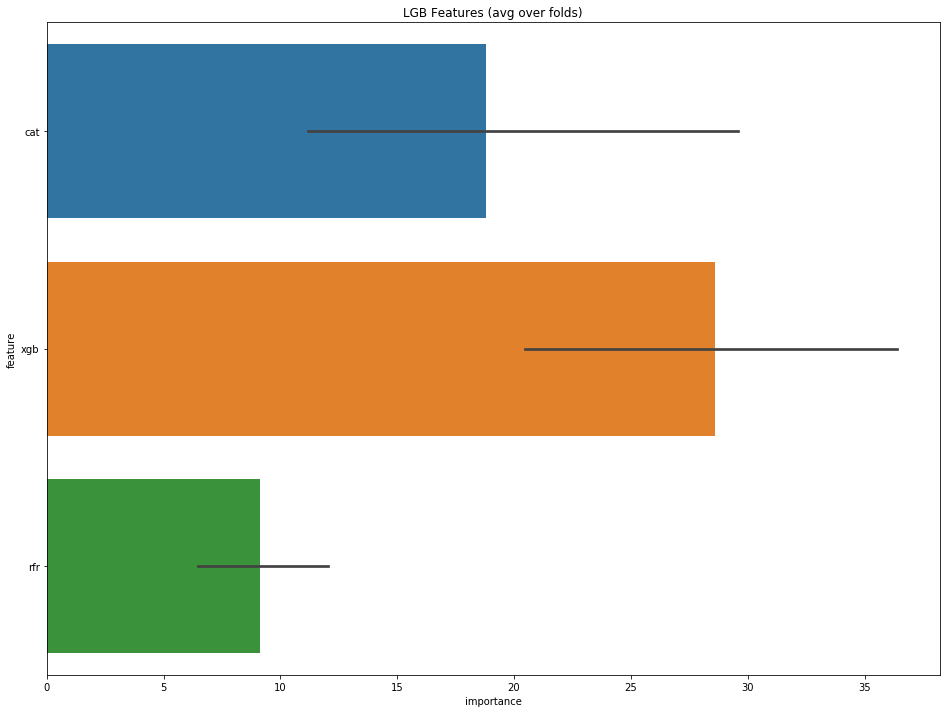

In [70]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:28:20 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0867547	valid_1's rmse: 0.0296008
[2000]	training's rmse: 0.0867416	valid_1's rmse: 0.0295901
Early stopping, best iteration is:
[2732]	training's rmse: 0.0867416	valid_1's rmse: 0.0295901
Fold 1 started at Tue Dec 17 11:28:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[449]	training's rmse: 0.0864167	valid_1's rmse: 0.0793456
Fold 2 started at Tue Dec 17 11:28:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[15]	training's rmse: 0.0998633	valid_1's rmse: 0.227202
Fold 3 started at Tue Dec 17 11:28:31 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0861144	valid_1's rmse: 0.0197316
Early stopping, best iteration is:
[1399]	training's rmse: 0.0861117	valid_1's rmse: 0.0197243
Fold 4 started at Tu

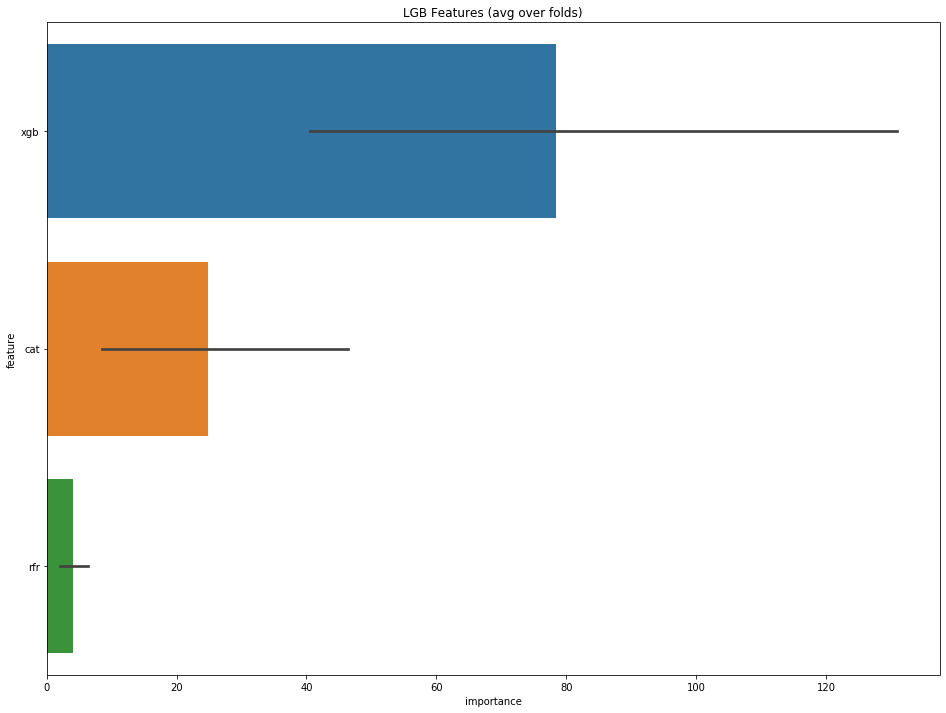

In [71]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [72]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:28:55 2019
Fold 1 started at Tue Dec 17 11:29:00 2019
Fold 2 started at Tue Dec 17 11:29:13 2019
Fold 3 started at Tue Dec 17 11:29:19 2019
Fold 4 started at Tue Dec 17 11:29:28 2019
Fold 5 started at Tue Dec 17 11:29:37 2019
Fold 6 started at Tue Dec 17 11:29:53 2019
Fold 7 started at Tue Dec 17 11:29:56 2019
Fold 8 started at Tue Dec 17 11:30:01 2019
Fold 9 started at Tue Dec 17 11:30:20 2019
CV mean score: 0.0657, std: 0.0553.


##### randomforest作为第二层融合模型

In [73]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:30:24 2019
Fold 1 started at Tue Dec 17 11:30:24 2019
Fold 2 started at Tue Dec 17 11:30:24 2019
Fold 3 started at Tue Dec 17 11:30:25 2019
Fold 4 started at Tue Dec 17 11:30:25 2019
Fold 5 started at Tue Dec 17 11:30:25 2019
Fold 6 started at Tue Dec 17 11:30:25 2019
Fold 7 started at Tue Dec 17 11:30:26 2019
Fold 8 started at Tue Dec 17 11:30:26 2019
Fold 9 started at Tue Dec 17 11:30:26 2019
CV mean score: 0.0731, std: 0.0590.


##### xgboost作为第二层融合模型

In [74]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:30:26 2019
[0]	train-rmse:0.207373	valid_data-rmse:0.153953
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.015041	valid_data-rmse:0.042438
Stopping. Best iteration:
[330]	train-rmse:0.029888	valid_data-rmse:0.041551

Fold 1 started at Tue Dec 17 11:30:26 2019
[0]	train-rmse:0.197635	valid_data-rmse:0.237751
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.014815	valid_data-rmse:0.04831
[1000]	train-rmse:0.00267	valid_data-rmse:0.046343
[1500]	train-rmse:0.000883	valid_data-rmse:0.045971
Stopping. Best iteration:
[1772]	train-rmse:0.000811	valid_data-rmse:0.045957

Fold 2 started at Tue Dec 17 11:30:27 2019
[0]	train-rmse:0.200611	valid_data-rmse:0.21615
Multiple eval metrics have been passed: 'valid_data-

##### svr 作为第二层融合模型

In [75]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:30:28 2019
Fold 1 started at Tue Dec 17 11:30:28 2019
Fold 2 started at Tue Dec 17 11:30:28 2019
Fold 3 started at Tue Dec 17 11:30:28 2019
Fold 4 started at Tue Dec 17 11:30:28 2019
Fold 5 started at Tue Dec 17 11:30:28 2019
Fold 6 started at Tue Dec 17 11:30:28 2019
Fold 7 started at Tue Dec 17 11:30:28 2019
Fold 8 started at Tue Dec 17 11:30:28 2019
Fold 9 started at Tue Dec 17 11:30:28 2019
CV mean score: 0.0780, std: 0.0529.


##### 岭回归做第二层融合模型

In [76]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:30:28 2019
Fold 1 started at Tue Dec 17 11:30:28 2019
Fold 2 started at Tue Dec 17 11:30:28 2019
Fold 3 started at Tue Dec 17 11:30:28 2019
Fold 4 started at Tue Dec 17 11:30:29 2019
Fold 5 started at Tue Dec 17 11:30:29 2019
Fold 6 started at Tue Dec 17 11:30:29 2019
Fold 7 started at Tue Dec 17 11:30:29 2019
Fold 8 started at Tue Dec 17 11:30:29 2019
Fold 9 started at Tue Dec 17 11:30:29 2019
CV mean score: 0.0666, std: 0.0536.


#### 去掉lgb和rfr的结果

In [77]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_cat, oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'cat', 'svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:30:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[581]	training's rmse: 0.091625	valid_1's rmse: 0.0295994
Fold 1 started at Tue Dec 17 11:30:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[620]	training's rmse: 0.0891375	valid_1's rmse: 0.0805151
Fold 2 started at Tue Dec 17 11:30:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[347]	training's rmse: 0.0580132	valid_1's rmse: 0.22518
Fold 3 started at Tue Dec 17 11:30:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[791]	training's rmse: 0.0882831	valid_1's rmse: 0.0235754
Fold 4 started at Tue Dec 17 11:30:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[532]	training's rmse: 0.0902659	valid_1's rmse: 0.0678263
Fol

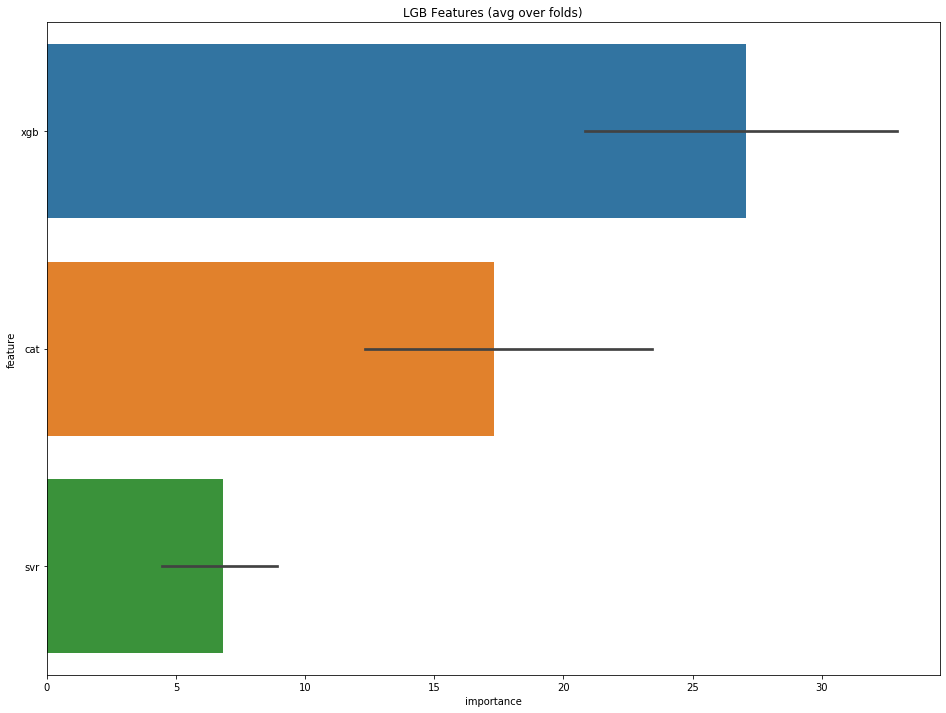

In [78]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:30:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[373]	training's rmse: 0.0873926	valid_1's rmse: 0.0297199
Fold 1 started at Tue Dec 17 11:30:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[515]	training's rmse: 0.0869231	valid_1's rmse: 0.0812321
Fold 2 started at Tue Dec 17 11:30:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[15]	training's rmse: 0.0998633	valid_1's rmse: 0.227202
Fold 3 started at Tue Dec 17 11:30:57 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0861806	valid_1's rmse: 0.0194853
Early stopping, best iteration is:
[1516]	training's rmse: 0.0861781	valid_1's rmse: 0.0194817
Fold 4 started at Tue Dec 17 11:31:03 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0858019	v

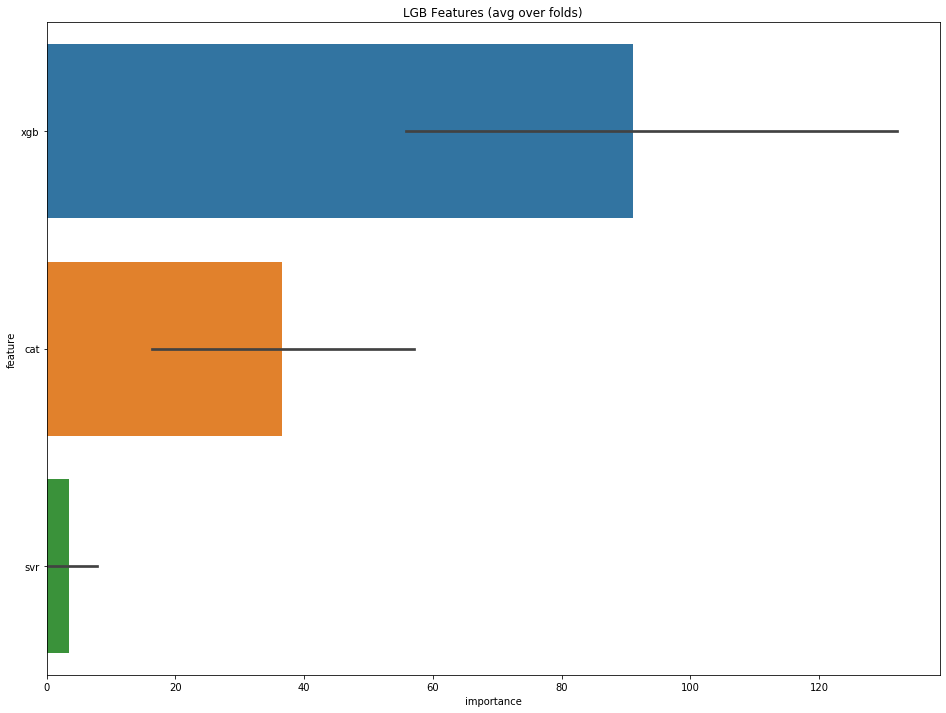

In [79]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [80]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:31:40 2019
Fold 1 started at Tue Dec 17 11:31:46 2019
Fold 2 started at Tue Dec 17 11:31:59 2019
Fold 3 started at Tue Dec 17 11:32:05 2019
Fold 4 started at Tue Dec 17 11:32:14 2019
Fold 5 started at Tue Dec 17 11:32:18 2019
Fold 6 started at Tue Dec 17 11:32:43 2019
Fold 7 started at Tue Dec 17 11:32:46 2019
Fold 8 started at Tue Dec 17 11:32:53 2019
Fold 9 started at Tue Dec 17 11:33:07 2019
CV mean score: 0.0640, std: 0.0550.


##### randomforest作为第二层融合模型

In [81]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:33:13 2019
Fold 1 started at Tue Dec 17 11:33:13 2019
Fold 2 started at Tue Dec 17 11:33:13 2019
Fold 3 started at Tue Dec 17 11:33:13 2019
Fold 4 started at Tue Dec 17 11:33:14 2019
Fold 5 started at Tue Dec 17 11:33:14 2019
Fold 6 started at Tue Dec 17 11:33:14 2019
Fold 7 started at Tue Dec 17 11:33:14 2019
Fold 8 started at Tue Dec 17 11:33:15 2019
Fold 9 started at Tue Dec 17 11:33:15 2019
CV mean score: 0.0695, std: 0.0620.


##### xgboost作为第二层融合模型

In [82]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:33:15 2019
[0]	train-rmse:0.207417	valid_data-rmse:0.154117
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[260]	train-rmse:0.040931	valid_data-rmse:0.040973

Fold 1 started at Tue Dec 17 11:33:15 2019
[0]	train-rmse:0.197628	valid_data-rmse:0.237737
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.015836	valid_data-rmse:0.041941
Stopping. Best iteration:
[710]	train-rmse:0.007706	valid_data-rmse:0.039969

Fold 2 started at Tue Dec 17 11:33:15 2019
[0]	train-rmse:0.200606	valid_data-rmse:0.21615
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[67]	train-rmse:0.113671

##### svr 作为第二层融合模型

In [83]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:33:16 2019
Fold 1 started at Tue Dec 17 11:33:16 2019
Fold 2 started at Tue Dec 17 11:33:16 2019
Fold 3 started at Tue Dec 17 11:33:16 2019
Fold 4 started at Tue Dec 17 11:33:16 2019
Fold 5 started at Tue Dec 17 11:33:16 2019
Fold 6 started at Tue Dec 17 11:33:16 2019
Fold 7 started at Tue Dec 17 11:33:16 2019
Fold 8 started at Tue Dec 17 11:33:16 2019
Fold 9 started at Tue Dec 17 11:33:16 2019
CV mean score: 0.0785, std: 0.0507.


##### 岭回归做第二层融合模型

In [84]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:33:16 2019
Fold 1 started at Tue Dec 17 11:33:17 2019
Fold 2 started at Tue Dec 17 11:33:17 2019
Fold 3 started at Tue Dec 17 11:33:17 2019
Fold 4 started at Tue Dec 17 11:33:17 2019
Fold 5 started at Tue Dec 17 11:33:17 2019
Fold 6 started at Tue Dec 17 11:33:17 2019
Fold 7 started at Tue Dec 17 11:33:17 2019
Fold 8 started at Tue Dec 17 11:33:17 2019
Fold 9 started at Tue Dec 17 11:33:17 2019
CV mean score: 0.0666, std: 0.0542.


#### 去掉lgb和cat的结果

In [85]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb, oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:33:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[431]	training's rmse: 0.0930978	valid_1's rmse: 0.0345214
Fold 1 started at Tue Dec 17 11:33:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[607]	training's rmse: 0.0890455	valid_1's rmse: 0.0792275
Fold 2 started at Tue Dec 17 11:33:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[252]	training's rmse: 0.0586054	valid_1's rmse: 0.222121
Fold 3 started at Tue Dec 17 11:33:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[540]	training's rmse: 0.0931321	valid_1's rmse: 0.0303785
Fold 4 started at Tue Dec 17 11:33:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[612]	training's rmse: 0.0892023	valid_1's rmse: 0.0679904
F

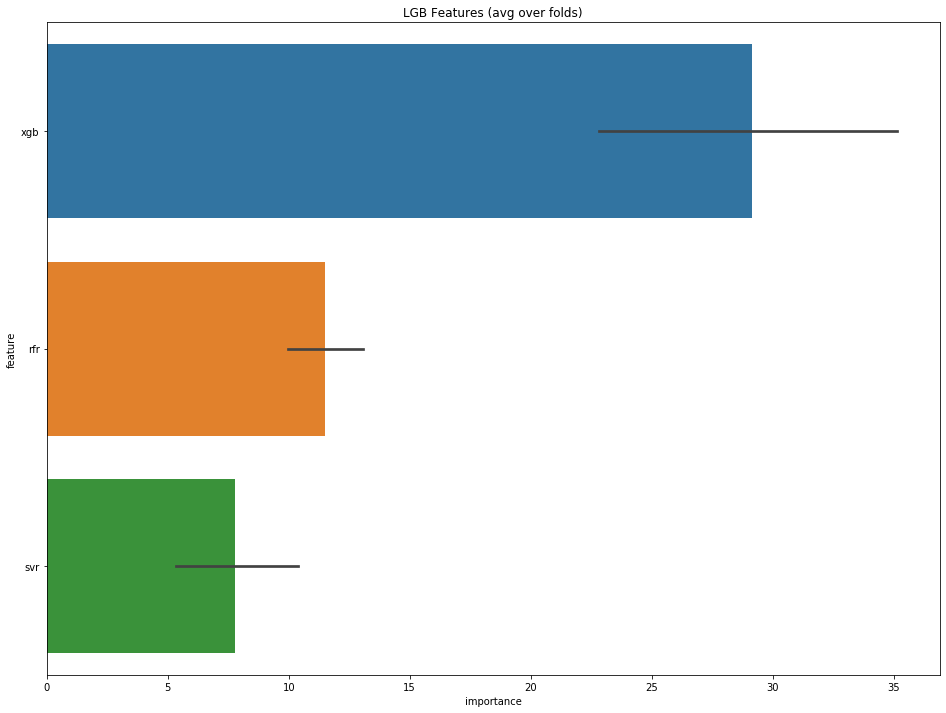

In [86]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:33:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[643]	training's rmse: 0.0902413	valid_1's rmse: 0.0316215
Fold 1 started at Tue Dec 17 11:33:42 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[458]	training's rmse: 0.0864752	valid_1's rmse: 0.078897
Fold 2 started at Tue Dec 17 11:33:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[30]	training's rmse: 0.0925396	valid_1's rmse: 0.223902
Fold 3 started at Tue Dec 17 11:33:45 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0902955	valid_1's rmse: 0.0261775
[2000]	training's rmse: 0.0902946	valid_1's rmse: 0.0261675
Early stopping, best iteration is:
[2060]	training's rmse: 0.0902946	valid_1's rmse: 0.0261675
Fold 4 started at Tue Dec 17 11:33:52 2019
Training until validation scores don't 

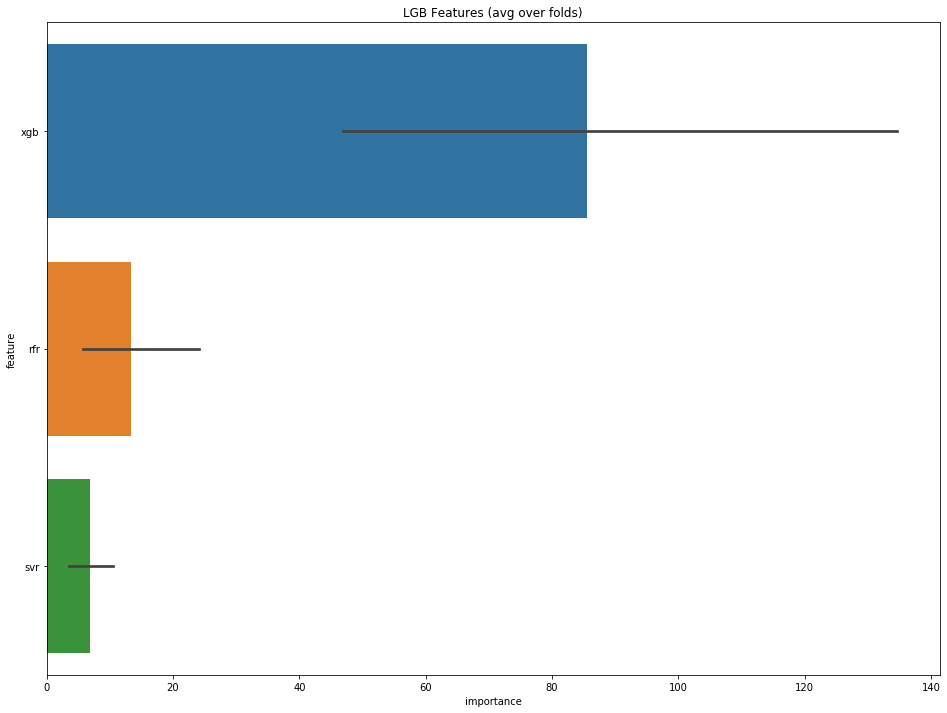

In [87]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [88]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:34:13 2019
Fold 1 started at Tue Dec 17 11:34:17 2019
Fold 2 started at Tue Dec 17 11:34:23 2019
Fold 3 started at Tue Dec 17 11:34:25 2019
Fold 4 started at Tue Dec 17 11:34:36 2019
Fold 5 started at Tue Dec 17 11:34:40 2019
Fold 6 started at Tue Dec 17 11:34:53 2019
Fold 7 started at Tue Dec 17 11:34:57 2019
Fold 8 started at Tue Dec 17 11:35:02 2019
Fold 9 started at Tue Dec 17 11:35:17 2019
CV mean score: 0.0689, std: 0.0561.


##### randomforest作为第二层融合模型

In [89]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:35:22 2019
Fold 1 started at Tue Dec 17 11:35:22 2019
Fold 2 started at Tue Dec 17 11:35:22 2019
Fold 3 started at Tue Dec 17 11:35:22 2019
Fold 4 started at Tue Dec 17 11:35:23 2019
Fold 5 started at Tue Dec 17 11:35:23 2019
Fold 6 started at Tue Dec 17 11:35:23 2019
Fold 7 started at Tue Dec 17 11:35:23 2019
Fold 8 started at Tue Dec 17 11:35:24 2019
Fold 9 started at Tue Dec 17 11:35:24 2019
CV mean score: 0.0726, std: 0.0607.


##### xgboost作为第二层融合模型

In [90]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:35:24 2019
[0]	train-rmse:0.207666	valid_data-rmse:0.154184
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[237]	train-rmse:0.047722	valid_data-rmse:0.042522

Fold 1 started at Tue Dec 17 11:35:24 2019
[0]	train-rmse:0.197658	valid_data-rmse:0.23786
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.015771	valid_data-rmse:0.052063
[1000]	train-rmse:0.002912	valid_data-rmse:0.050744
[1500]	train-rmse:0.000949	valid_data-rmse:0.050549
Stopping. Best iteration:
[1359]	train-rmse:0.001119	valid_data-rmse:0.050529

Fold 2 started at Tue Dec 17 11:35:25 2019
[0]	train-rmse:0.200674	valid_data-rmse:0.216328
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will trai

##### svr 作为第二层融合模型

In [91]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:35:26 2019
Fold 1 started at Tue Dec 17 11:35:26 2019
Fold 2 started at Tue Dec 17 11:35:26 2019
Fold 3 started at Tue Dec 17 11:35:26 2019
Fold 4 started at Tue Dec 17 11:35:26 2019
Fold 5 started at Tue Dec 17 11:35:26 2019
Fold 6 started at Tue Dec 17 11:35:26 2019
Fold 7 started at Tue Dec 17 11:35:26 2019
Fold 8 started at Tue Dec 17 11:35:26 2019
Fold 9 started at Tue Dec 17 11:35:26 2019
CV mean score: 0.0794, std: 0.0544.


##### 岭回归做第二层融合模型

In [92]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:35:26 2019
Fold 1 started at Tue Dec 17 11:35:26 2019
Fold 2 started at Tue Dec 17 11:35:26 2019
Fold 3 started at Tue Dec 17 11:35:26 2019
Fold 4 started at Tue Dec 17 11:35:27 2019
Fold 5 started at Tue Dec 17 11:35:27 2019
Fold 6 started at Tue Dec 17 11:35:27 2019
Fold 7 started at Tue Dec 17 11:35:27 2019
Fold 8 started at Tue Dec 17 11:35:27 2019
Fold 9 started at Tue Dec 17 11:35:27 2019
CV mean score: 0.0696, std: 0.0570.


#### 去掉xgb和svr

In [93]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'cat', 'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:35:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[646]	training's rmse: 0.0925144	valid_1's rmse: 0.0365321
Fold 1 started at Tue Dec 17 11:35:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[560]	training's rmse: 0.0945037	valid_1's rmse: 0.0712283
Fold 2 started at Tue Dec 17 11:35:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108303	valid_1's rmse: 0.231552
Fold 3 started at Tue Dec 17 11:35:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[743]	training's rmse: 0.0913187	valid_1's rmse: 0.0397598
Fold 4 started at Tue Dec 17 11:35:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[499]	training's rmse: 0.094467	valid_1's rmse: 0.0656472
Fold 

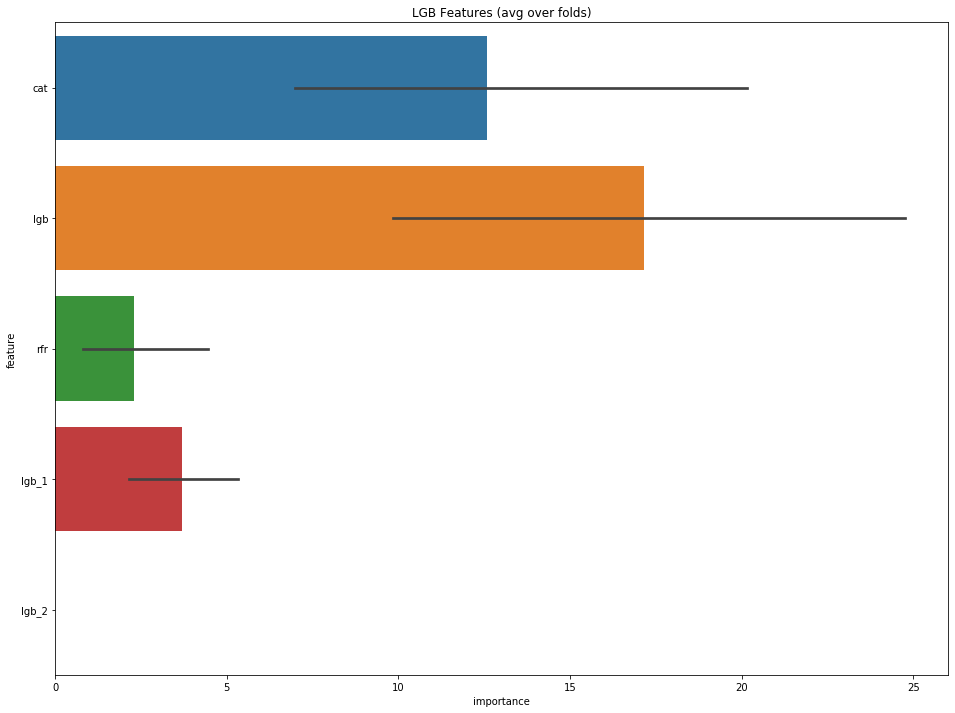

In [94]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:35:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[466]	training's rmse: 0.0901156	valid_1's rmse: 0.0441905
Fold 1 started at Tue Dec 17 11:35:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.0924603	valid_1's rmse: 0.0718425
Fold 2 started at Tue Dec 17 11:35:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108235	valid_1's rmse: 0.231746
Fold 3 started at Tue Dec 17 11:35:53 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0898827	valid_1's rmse: 0.0392401
[2000]	training's rmse: 0.0898313	valid_1's rmse: 0.0392067
[3000]	training's rmse: 0.0898114	valid_1's rmse: 0.0392021
[4000]	training's rmse: 0.0898011	valid_1's rmse: 0.039201
[5000]	training's rmse: 0.0897954	valid_1's rmse: 0.0392007

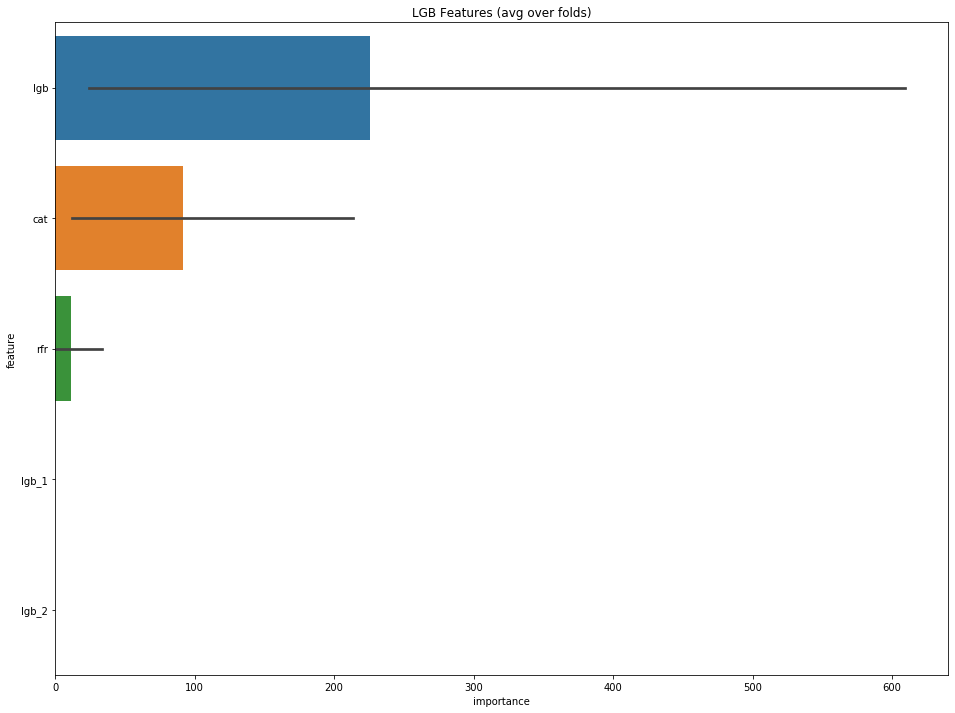

In [95]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [96]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:37:48 2019
Fold 1 started at Tue Dec 17 11:37:53 2019
Fold 2 started at Tue Dec 17 11:38:05 2019
Fold 3 started at Tue Dec 17 11:38:06 2019
Fold 4 started at Tue Dec 17 11:38:17 2019
Fold 5 started at Tue Dec 17 11:38:28 2019
Fold 6 started at Tue Dec 17 11:38:43 2019
Fold 7 started at Tue Dec 17 11:38:45 2019
Fold 8 started at Tue Dec 17 11:38:46 2019
Fold 9 started at Tue Dec 17 11:39:04 2019
CV mean score: 0.0732, std: 0.0557.


##### randomforest作为第二层融合模型

In [97]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:39:08 2019
Fold 1 started at Tue Dec 17 11:39:08 2019
Fold 2 started at Tue Dec 17 11:39:08 2019
Fold 3 started at Tue Dec 17 11:39:08 2019
Fold 4 started at Tue Dec 17 11:39:09 2019
Fold 5 started at Tue Dec 17 11:39:09 2019
Fold 6 started at Tue Dec 17 11:39:09 2019
Fold 7 started at Tue Dec 17 11:39:09 2019
Fold 8 started at Tue Dec 17 11:39:09 2019
Fold 9 started at Tue Dec 17 11:39:10 2019
CV mean score: 0.0800, std: 0.0549.


##### xgboost作为第二层融合模型

In [98]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:39:10 2019
[0]	train-rmse:0.207575	valid_data-rmse:0.154675
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.014912	valid_data-rmse:0.051089
Stopping. Best iteration:
[344]	train-rmse:0.02786	valid_data-rmse:0.05095

Fold 1 started at Tue Dec 17 11:39:10 2019
[0]	train-rmse:0.197635	valid_data-rmse:0.237751
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.014788	valid_data-rmse:0.064486
Stopping. Best iteration:
[304]	train-rmse:0.032656	valid_data-rmse:0.05882

Fold 2 started at Tue Dec 17 11:39:10 2019
[0]	train-rmse:0.200593	valid_data-rmse:0.2164
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Sto

##### svr 作为第二层融合模型

In [99]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:39:12 2019
Fold 1 started at Tue Dec 17 11:39:12 2019
Fold 2 started at Tue Dec 17 11:39:12 2019
Fold 3 started at Tue Dec 17 11:39:12 2019
Fold 4 started at Tue Dec 17 11:39:12 2019
Fold 5 started at Tue Dec 17 11:39:12 2019
Fold 6 started at Tue Dec 17 11:39:12 2019
Fold 7 started at Tue Dec 17 11:39:12 2019
Fold 8 started at Tue Dec 17 11:39:12 2019
Fold 9 started at Tue Dec 17 11:39:12 2019
CV mean score: 0.0792, std: 0.0534.


##### 岭回归做第二层融合模型

In [100]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:39:12 2019
Fold 1 started at Tue Dec 17 11:39:12 2019
Fold 2 started at Tue Dec 17 11:39:12 2019
Fold 3 started at Tue Dec 17 11:39:12 2019
Fold 4 started at Tue Dec 17 11:39:12 2019
Fold 5 started at Tue Dec 17 11:39:13 2019
Fold 6 started at Tue Dec 17 11:39:13 2019
Fold 7 started at Tue Dec 17 11:39:13 2019
Fold 8 started at Tue Dec 17 11:39:13 2019
Fold 9 started at Tue Dec 17 11:39:13 2019
CV mean score: 0.0687, std: 0.0524.


#### 去掉xgb和rfr

In [101]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:39:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[475]	training's rmse: 0.0929431	valid_1's rmse: 0.0354859
Fold 1 started at Tue Dec 17 11:39:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[340]	training's rmse: 0.095296	valid_1's rmse: 0.0717334
Fold 2 started at Tue Dec 17 11:39:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[4]	training's rmse: 0.106581	valid_1's rmse: 0.231008
Fold 3 started at Tue Dec 17 11:39:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[743]	training's rmse: 0.0911412	valid_1's rmse: 0.038318
Fold 4 started at Tue Dec 17 11:39:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[550]	training's rmse: 0.0936333	valid_1's rmse: 0.0677076
Fold 5

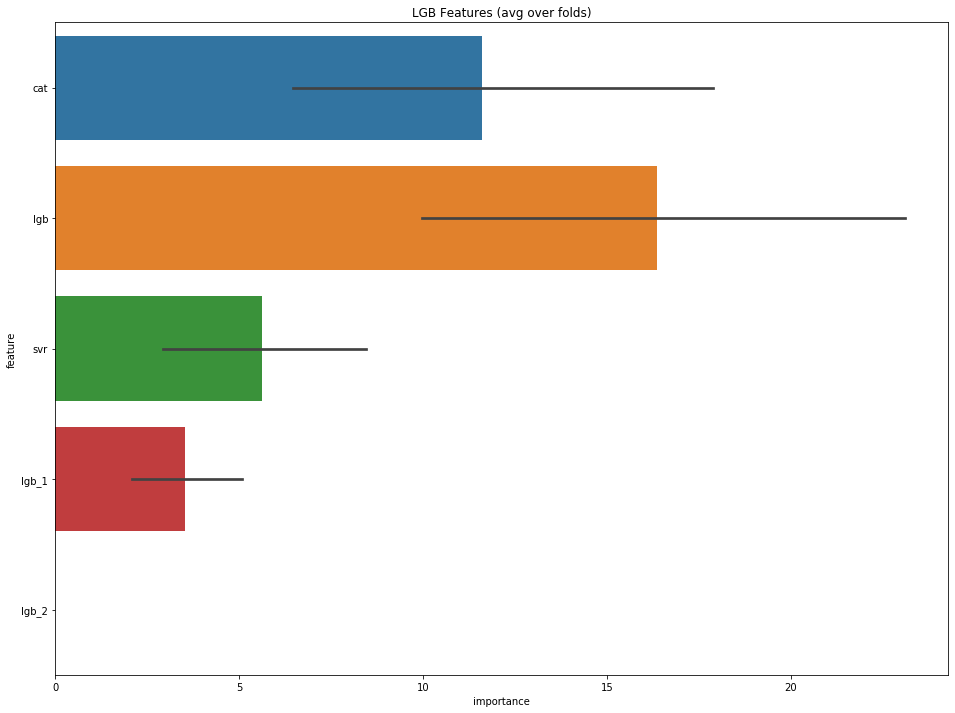

In [102]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:39:31 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0893769	valid_1's rmse: 0.0412855
[2000]	training's rmse: 0.0889096	valid_1's rmse: 0.0405898
[3000]	training's rmse: 0.0886926	valid_1's rmse: 0.040272
[4000]	training's rmse: 0.0885913	valid_1's rmse: 0.0401208
[5000]	training's rmse: 0.0885415	valid_1's rmse: 0.0400569
[6000]	training's rmse: 0.0885186	valid_1's rmse: 0.0400219
Early stopping, best iteration is:
[5882]	training's rmse: 0.0885221	valid_1's rmse: 0.0400194
Fold 1 started at Tue Dec 17 11:39:44 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0912765	valid_1's rmse: 0.067975
Early stopping, best iteration is:
[1740]	training's rmse: 0.0899153	valid_1's rmse: 0.0676381
Fold 2 started at Tue Dec 17 11:39:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108235	valid_1's

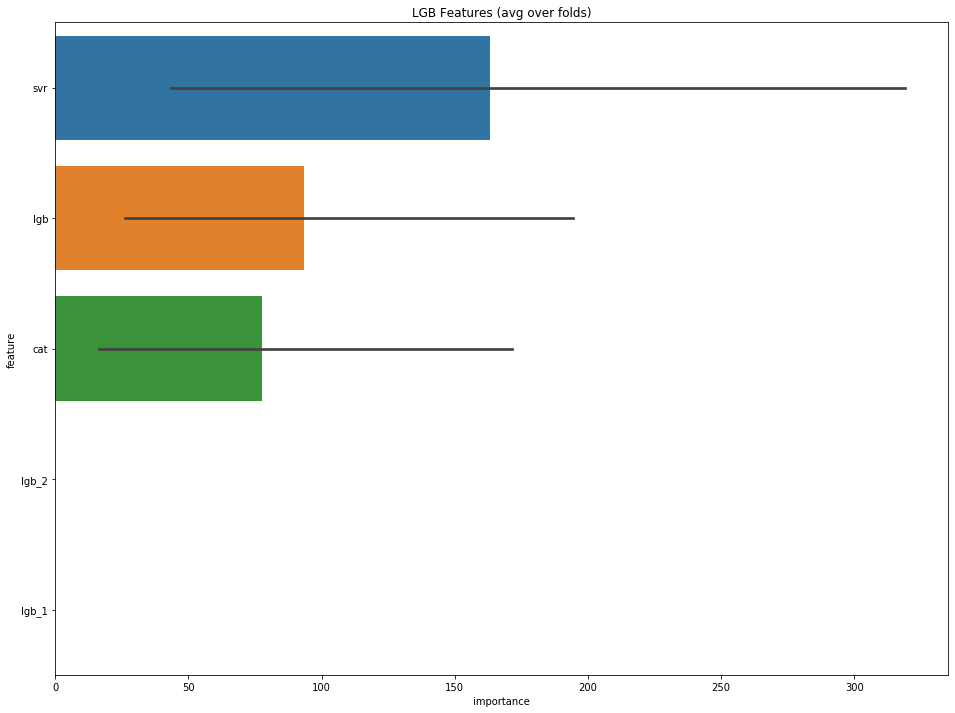

In [103]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [104]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:40:54 2019
Fold 1 started at Tue Dec 17 11:40:59 2019
Fold 2 started at Tue Dec 17 11:41:12 2019
Fold 3 started at Tue Dec 17 11:41:12 2019
Fold 4 started at Tue Dec 17 11:41:23 2019
Fold 5 started at Tue Dec 17 11:41:30 2019
Fold 6 started at Tue Dec 17 11:41:38 2019
Fold 7 started at Tue Dec 17 11:41:41 2019
Fold 8 started at Tue Dec 17 11:41:42 2019
Fold 9 started at Tue Dec 17 11:41:52 2019
CV mean score: 0.0724, std: 0.0561.


##### randomforest作为第二层融合模型

In [105]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:41:58 2019
Fold 1 started at Tue Dec 17 11:41:58 2019
Fold 2 started at Tue Dec 17 11:41:58 2019
Fold 3 started at Tue Dec 17 11:41:58 2019
Fold 4 started at Tue Dec 17 11:41:58 2019
Fold 5 started at Tue Dec 17 11:41:59 2019
Fold 6 started at Tue Dec 17 11:41:59 2019
Fold 7 started at Tue Dec 17 11:41:59 2019
Fold 8 started at Tue Dec 17 11:41:59 2019
Fold 9 started at Tue Dec 17 11:42:00 2019
CV mean score: 0.0776, std: 0.0552.


##### xgboost作为第二层融合模型

In [106]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:42:00 2019
[0]	train-rmse:0.207575	valid_data-rmse:0.154675
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[232]	train-rmse:0.045296	valid_data-rmse:0.04492

Fold 1 started at Tue Dec 17 11:42:00 2019
[0]	train-rmse:0.197635	valid_data-rmse:0.237751
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.01505	valid_data-rmse:0.052156
Stopping. Best iteration:
[393]	train-rmse:0.022396	valid_data-rmse:0.051223

Fold 2 started at Tue Dec 17 11:42:00 2019
[0]	train-rmse:0.200593	valid_data-rmse:0.2164
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[36]	train-rmse:0.146884	va

##### svr 作为第二层融合模型

In [107]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:42:02 2019
Fold 1 started at Tue Dec 17 11:42:02 2019
Fold 2 started at Tue Dec 17 11:42:02 2019
Fold 3 started at Tue Dec 17 11:42:02 2019
Fold 4 started at Tue Dec 17 11:42:02 2019
Fold 5 started at Tue Dec 17 11:42:02 2019
Fold 6 started at Tue Dec 17 11:42:02 2019
Fold 7 started at Tue Dec 17 11:42:02 2019
Fold 8 started at Tue Dec 17 11:42:02 2019
Fold 9 started at Tue Dec 17 11:42:02 2019
CV mean score: 0.0800, std: 0.0518.


##### 岭回归做第二层融合模型

In [108]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:42:02 2019
Fold 1 started at Tue Dec 17 11:42:02 2019
Fold 2 started at Tue Dec 17 11:42:02 2019
Fold 3 started at Tue Dec 17 11:42:02 2019
Fold 4 started at Tue Dec 17 11:42:02 2019
Fold 5 started at Tue Dec 17 11:42:02 2019
Fold 6 started at Tue Dec 17 11:42:02 2019
Fold 7 started at Tue Dec 17 11:42:02 2019
Fold 8 started at Tue Dec 17 11:42:03 2019
Fold 9 started at Tue Dec 17 11:42:03 2019
CV mean score: 0.0701, std: 0.0554.


#### 去掉xgb和cat

In [109]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_lgb_1, oof_lgb_2,oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:42:03 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[432]	training's rmse: 0.0971268	valid_1's rmse: 0.0396648
Fold 1 started at Tue Dec 17 11:42:05 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0923141	valid_1's rmse: 0.0711874
Early stopping, best iteration is:
[988]	training's rmse: 0.092364	valid_1's rmse: 0.0709993
Fold 2 started at Tue Dec 17 11:42:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2]	training's rmse: 0.107748	valid_1's rmse: 0.231304
Fold 3 started at Tue Dec 17 11:42:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[673]	training's rmse: 0.0966569	valid_1's rmse: 0.0552165
Fold 4 started at Tue Dec 17 11:42:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[552

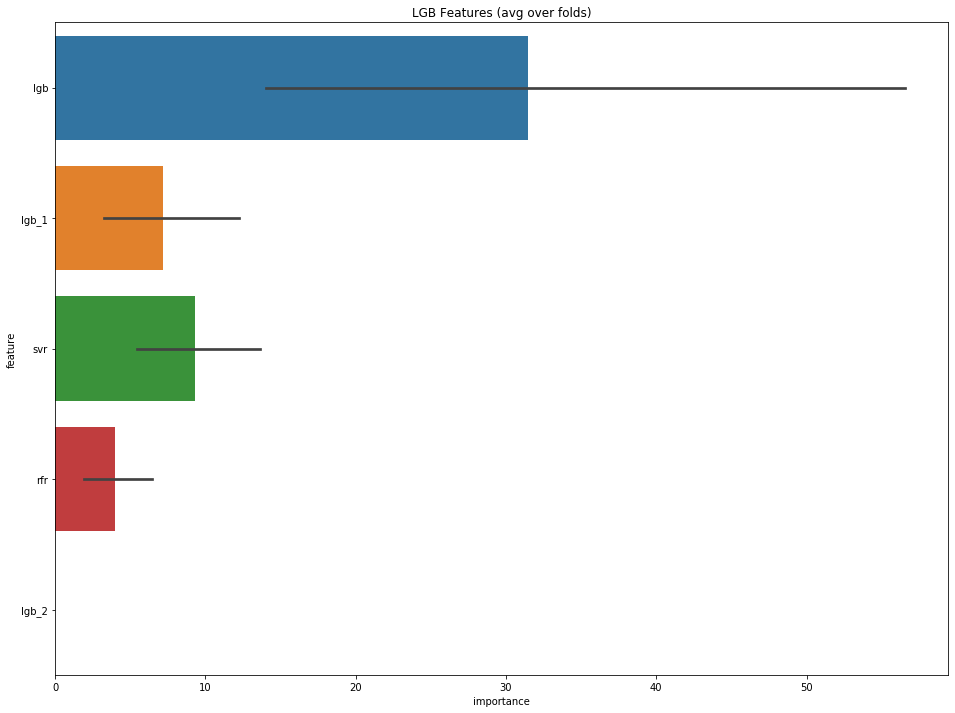

In [110]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:42:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[782]	training's rmse: 0.0947301	valid_1's rmse: 0.0357934
Fold 1 started at Tue Dec 17 11:42:32 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0911954	valid_1's rmse: 0.06698
[2000]	training's rmse: 0.0897686	valid_1's rmse: 0.0660117
[3000]	training's rmse: 0.0889533	valid_1's rmse: 0.0657754
[4000]	training's rmse: 0.0886063	valid_1's rmse: 0.0656021
[5000]	training's rmse: 0.0885356	valid_1's rmse: 0.0655403
[6000]	training's rmse: 0.0884924	valid_1's rmse: 0.0655173
[7000]	training's rmse: 0.0884674	valid_1's rmse: 0.0655032
[8000]	training's rmse: 0.0884571	valid_1's rmse: 0.0654981
[9000]	training's rmse: 0.0884516	valid_1's rmse: 0.0654954
[10000]	training's rmse: 0.0884487	valid_1's rmse: 0.065494
Early stopping, best iteration is:
[10082]	training's rmse: 0.0884485	valid_1's rmse: 0.0654939


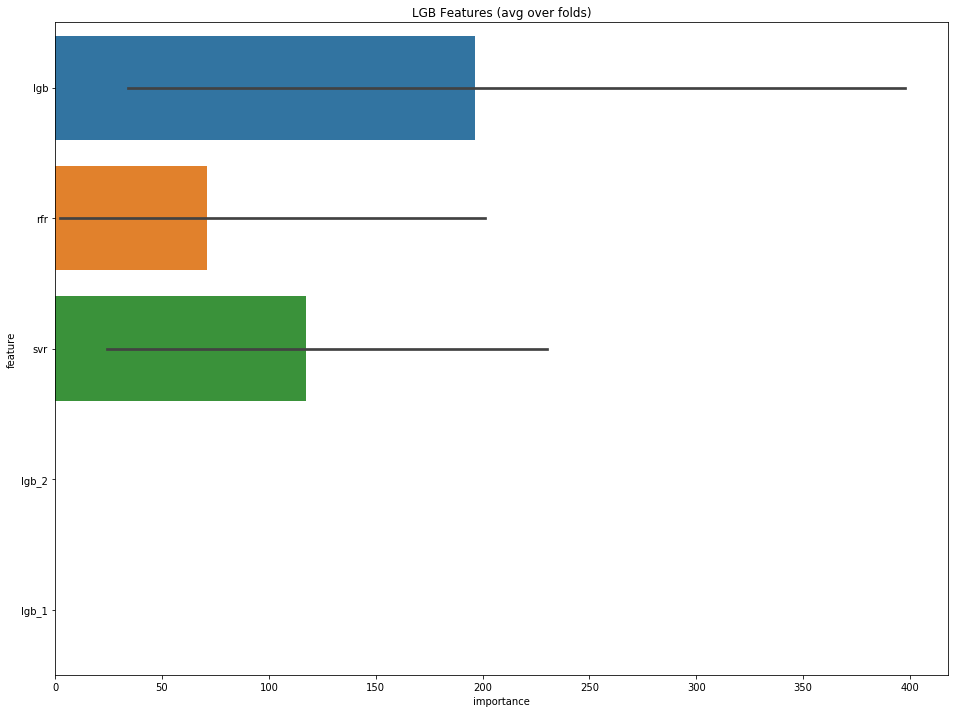

In [111]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [112]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:44:09 2019
Fold 1 started at Tue Dec 17 11:44:13 2019
Fold 2 started at Tue Dec 17 11:44:23 2019
Fold 3 started at Tue Dec 17 11:44:24 2019
Fold 4 started at Tue Dec 17 11:44:38 2019
Fold 5 started at Tue Dec 17 11:44:47 2019
Fold 6 started at Tue Dec 17 11:45:04 2019
Fold 7 started at Tue Dec 17 11:45:08 2019
Fold 8 started at Tue Dec 17 11:45:08 2019
Fold 9 started at Tue Dec 17 11:45:22 2019
CV mean score: 0.0750, std: 0.0554.


##### randomforest作为第二层融合模型

In [113]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:45:27 2019
Fold 1 started at Tue Dec 17 11:45:28 2019
Fold 2 started at Tue Dec 17 11:45:28 2019
Fold 3 started at Tue Dec 17 11:45:28 2019
Fold 4 started at Tue Dec 17 11:45:28 2019
Fold 5 started at Tue Dec 17 11:45:28 2019
Fold 6 started at Tue Dec 17 11:45:29 2019
Fold 7 started at Tue Dec 17 11:45:29 2019
Fold 8 started at Tue Dec 17 11:45:29 2019
Fold 9 started at Tue Dec 17 11:45:29 2019
CV mean score: 0.0802, std: 0.0583.


##### xgboost作为第二层融合模型

In [114]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:45:30 2019
[0]	train-rmse:0.20741	valid_data-rmse:0.154128
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[219]	train-rmse:0.049324	valid_data-rmse:0.045686

Fold 1 started at Tue Dec 17 11:45:30 2019
[0]	train-rmse:0.197752	valid_data-rmse:0.23815
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.015926	valid_data-rmse:0.049867
Stopping. Best iteration:
[475]	train-rmse:0.017299	valid_data-rmse:0.049863

Fold 2 started at Tue Dec 17 11:45:30 2019
[0]	train-rmse:0.200627	valid_data-rmse:0.216476
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[34]	train-rmse:0.150053	

##### svr 作为第二层融合模型

In [115]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:45:32 2019
Fold 1 started at Tue Dec 17 11:45:32 2019
Fold 2 started at Tue Dec 17 11:45:32 2019
Fold 3 started at Tue Dec 17 11:45:32 2019
Fold 4 started at Tue Dec 17 11:45:32 2019
Fold 5 started at Tue Dec 17 11:45:32 2019
Fold 6 started at Tue Dec 17 11:45:32 2019
Fold 7 started at Tue Dec 17 11:45:32 2019
Fold 8 started at Tue Dec 17 11:45:32 2019
Fold 9 started at Tue Dec 17 11:45:32 2019
CV mean score: 0.0812, std: 0.0546.


##### 岭回归做第二层融合模型

In [116]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:45:32 2019
Fold 1 started at Tue Dec 17 11:45:32 2019
Fold 2 started at Tue Dec 17 11:45:32 2019
Fold 3 started at Tue Dec 17 11:45:32 2019
Fold 4 started at Tue Dec 17 11:45:32 2019
Fold 5 started at Tue Dec 17 11:45:32 2019
Fold 6 started at Tue Dec 17 11:45:32 2019
Fold 7 started at Tue Dec 17 11:45:32 2019
Fold 8 started at Tue Dec 17 11:45:33 2019
Fold 9 started at Tue Dec 17 11:45:33 2019
CV mean score: 0.0821, std: 0.0597.


#### 去掉svr和rfr

In [117]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb', 'cat', 'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:45:33 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[474]	training's rmse: 0.0883217	valid_1's rmse: 0.0306798
Fold 1 started at Tue Dec 17 11:45:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[395]	training's rmse: 0.0871224	valid_1's rmse: 0.0726312
Fold 2 started at Tue Dec 17 11:45:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[455]	training's rmse: 0.0563009	valid_1's rmse: 0.217275
Fold 3 started at Tue Dec 17 11:45:40 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[519]	training's rmse: 0.0885777	valid_1's rmse: 0.0269898
Fold 4 started at Tue Dec 17 11:45:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[376]	training's rmse: 0.0870418	valid_1's rmse: 0.0636028
F

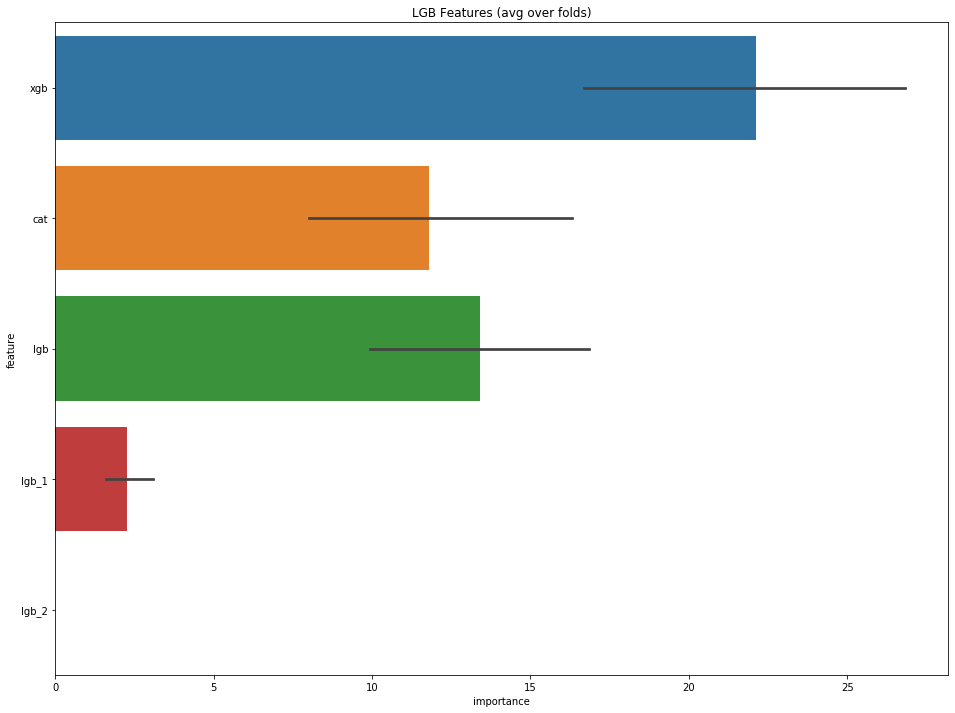

In [118]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:45:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[395]	training's rmse: 0.0849884	valid_1's rmse: 0.029803
Fold 1 started at Tue Dec 17 11:46:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 0.0852466	valid_1's rmse: 0.0711601
Fold 2 started at Tue Dec 17 11:46:03 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0548546	valid_1's rmse: 0.211681
Early stopping, best iteration is:
[1251]	training's rmse: 0.0548469	valid_1's rmse: 0.211673
Fold 3 started at Tue Dec 17 11:46:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[585]	training's rmse: 0.0843492	valid_1's rmse: 0.0234162
Fold 4 started at Tue Dec 17 11:46:11 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[

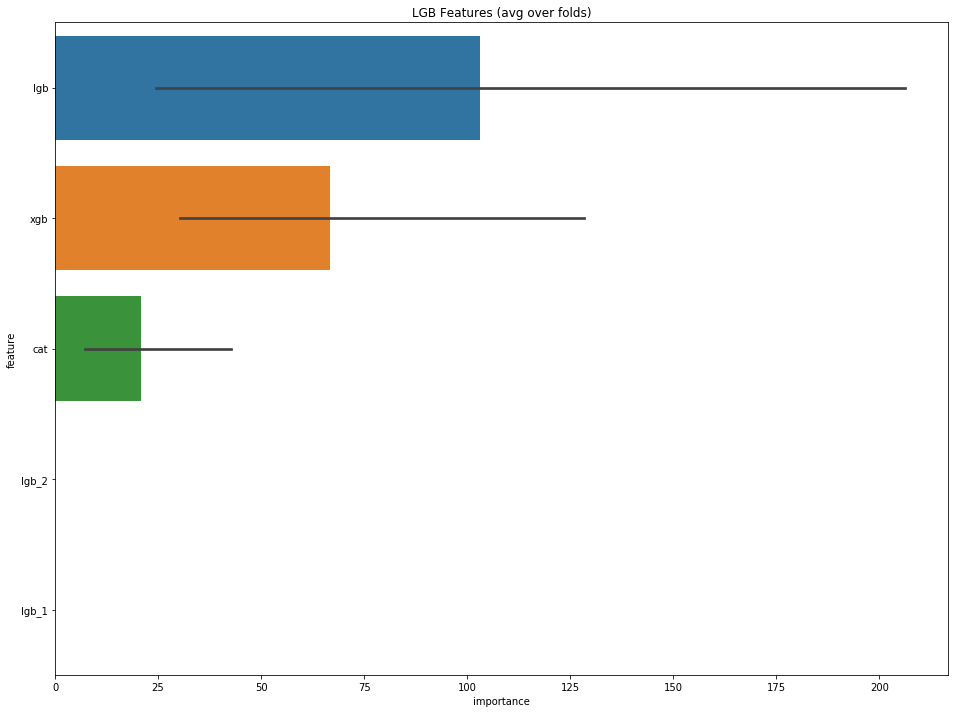

In [119]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [120]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:46:56 2019
Fold 1 started at Tue Dec 17 11:47:00 2019
Fold 2 started at Tue Dec 17 11:47:10 2019
Fold 3 started at Tue Dec 17 11:47:23 2019
Fold 4 started at Tue Dec 17 11:47:35 2019
Fold 5 started at Tue Dec 17 11:47:42 2019
Fold 6 started at Tue Dec 17 11:48:02 2019
Fold 7 started at Tue Dec 17 11:48:06 2019
Fold 8 started at Tue Dec 17 11:48:07 2019
Fold 9 started at Tue Dec 17 11:48:15 2019
CV mean score: 0.0668, std: 0.0526.


##### randomforest作为第二层融合模型

In [121]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:48:19 2019
Fold 1 started at Tue Dec 17 11:48:19 2019
Fold 2 started at Tue Dec 17 11:48:20 2019
Fold 3 started at Tue Dec 17 11:48:20 2019
Fold 4 started at Tue Dec 17 11:48:20 2019
Fold 5 started at Tue Dec 17 11:48:20 2019
Fold 6 started at Tue Dec 17 11:48:21 2019
Fold 7 started at Tue Dec 17 11:48:21 2019
Fold 8 started at Tue Dec 17 11:48:21 2019
Fold 9 started at Tue Dec 17 11:48:21 2019
CV mean score: 0.0724, std: 0.0522.


##### xgboost作为第二层融合模型

In [122]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:48:22 2019
[0]	train-rmse:0.207394	valid_data-rmse:0.154059
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[252]	train-rmse:0.042695	valid_data-rmse:0.040603

Fold 1 started at Tue Dec 17 11:48:22 2019
[0]	train-rmse:0.197624	valid_data-rmse:0.237751
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[255]	train-rmse:0.04135	valid_data-rmse:0.06212

Fold 2 started at Tue Dec 17 11:48:22 2019
[0]	train-rmse:0.200595	valid_data-rmse:0.216483
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[124]	train-rmse:0.072602	valid_data-rmse:0.205539

Fold 3 started at Tue De

##### svr 作为第二层融合模型

In [123]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:48:23 2019
Fold 1 started at Tue Dec 17 11:48:23 2019
Fold 2 started at Tue Dec 17 11:48:23 2019
Fold 3 started at Tue Dec 17 11:48:23 2019
Fold 4 started at Tue Dec 17 11:48:23 2019
Fold 5 started at Tue Dec 17 11:48:23 2019
Fold 6 started at Tue Dec 17 11:48:23 2019
Fold 7 started at Tue Dec 17 11:48:23 2019
Fold 8 started at Tue Dec 17 11:48:23 2019
Fold 9 started at Tue Dec 17 11:48:23 2019
CV mean score: 0.0793, std: 0.0498.


##### 岭回归做第二层融合模型

In [124]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:48:23 2019
Fold 1 started at Tue Dec 17 11:48:23 2019
Fold 2 started at Tue Dec 17 11:48:23 2019
Fold 3 started at Tue Dec 17 11:48:23 2019
Fold 4 started at Tue Dec 17 11:48:23 2019
Fold 5 started at Tue Dec 17 11:48:23 2019
Fold 6 started at Tue Dec 17 11:48:23 2019
Fold 7 started at Tue Dec 17 11:48:24 2019
Fold 8 started at Tue Dec 17 11:48:24 2019
Fold 9 started at Tue Dec 17 11:48:24 2019
CV mean score: 0.0642, std: 0.0523.


#### 去掉svr和cat

In [125]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:48:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[336]	training's rmse: 0.0907946	valid_1's rmse: 0.0367726
Fold 1 started at Tue Dec 17 11:48:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[475]	training's rmse: 0.0864142	valid_1's rmse: 0.0717911
Fold 2 started at Tue Dec 17 11:48:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[357]	training's rmse: 0.0551839	valid_1's rmse: 0.21786
Fold 3 started at Tue Dec 17 11:48:31 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0905315	valid_1's rmse: 0.031496
Early stopping, best iteration is:
[926]	training's rmse: 0.09054	valid_1's rmse: 0.0314689
Fold 4 started at Tue Dec 17 11:48:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[378

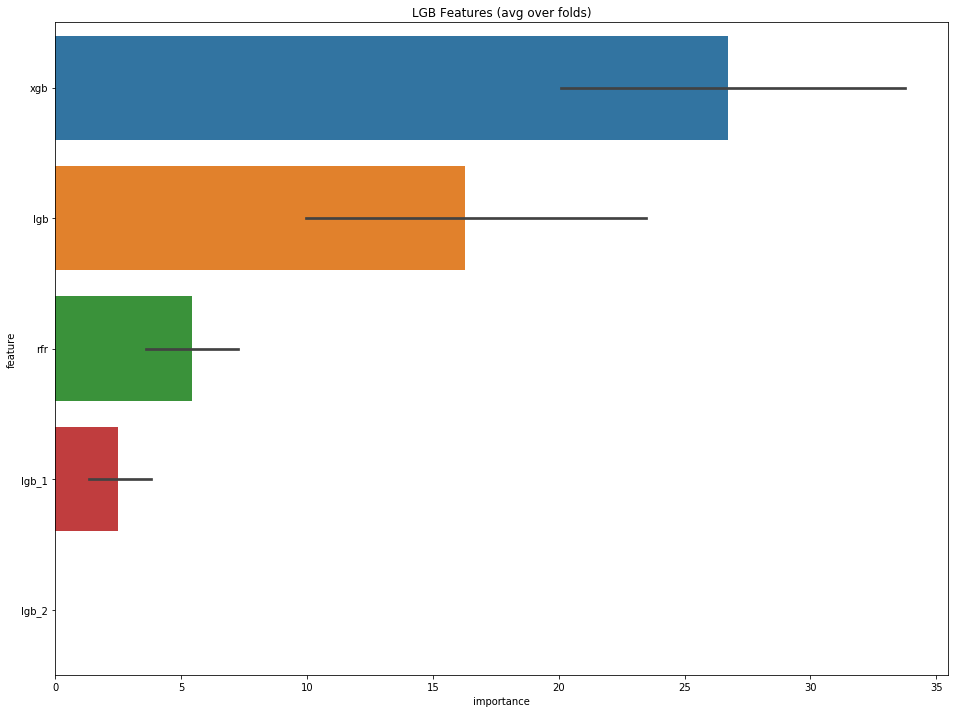

In [126]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:48:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[348]	training's rmse: 0.0893284	valid_1's rmse: 0.0337722
Fold 1 started at Tue Dec 17 11:48:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 0.0852466	valid_1's rmse: 0.0711601
Fold 2 started at Tue Dec 17 11:48:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[30]	training's rmse: 0.0925396	valid_1's rmse: 0.223902
Fold 3 started at Tue Dec 17 11:48:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[787]	training's rmse: 0.0891305	valid_1's rmse: 0.027568
Fold 4 started at Tue Dec 17 11:48:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[610]	training's rmse: 0.084856	valid_1's rmse: 0.0612436
Fold

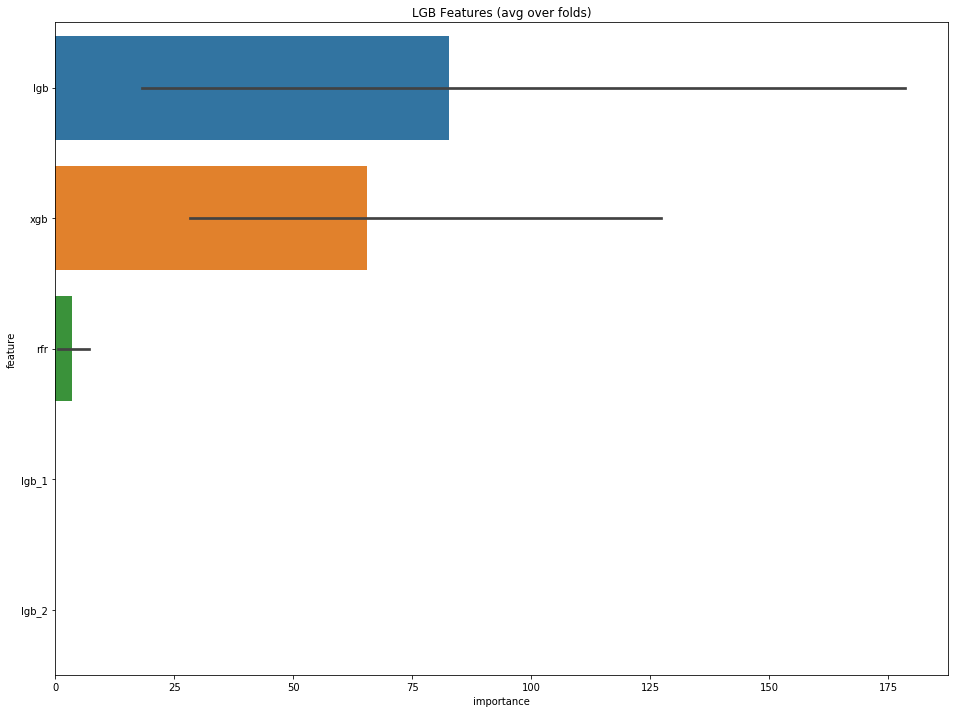

In [127]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [128]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:49:36 2019
Fold 1 started at Tue Dec 17 11:49:40 2019
Fold 2 started at Tue Dec 17 11:49:48 2019
Fold 3 started at Tue Dec 17 11:49:56 2019
Fold 4 started at Tue Dec 17 11:50:04 2019
Fold 5 started at Tue Dec 17 11:50:09 2019
Fold 6 started at Tue Dec 17 11:50:16 2019
Fold 7 started at Tue Dec 17 11:50:19 2019
Fold 8 started at Tue Dec 17 11:50:20 2019
Fold 9 started at Tue Dec 17 11:50:32 2019
CV mean score: 0.0709, std: 0.0538.


##### randomforest作为第二层融合模型

In [129]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:50:43 2019
Fold 1 started at Tue Dec 17 11:50:43 2019
Fold 2 started at Tue Dec 17 11:50:43 2019
Fold 3 started at Tue Dec 17 11:50:43 2019
Fold 4 started at Tue Dec 17 11:50:44 2019
Fold 5 started at Tue Dec 17 11:50:44 2019
Fold 6 started at Tue Dec 17 11:50:44 2019
Fold 7 started at Tue Dec 17 11:50:44 2019
Fold 8 started at Tue Dec 17 11:50:45 2019
Fold 9 started at Tue Dec 17 11:50:45 2019
CV mean score: 0.0747, std: 0.0510.


##### xgboost作为第二层融合模型

In [130]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:50:45 2019
[0]	train-rmse:0.207372	valid_data-rmse:0.153855
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[221]	train-rmse:0.049121	valid_data-rmse:0.04336

Fold 1 started at Tue Dec 17 11:50:45 2019
[0]	train-rmse:0.197606	valid_data-rmse:0.237964
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.015069	valid_data-rmse:0.060426
Stopping. Best iteration:
[338]	train-rmse:0.028615	valid_data-rmse:0.057606

Fold 2 started at Tue Dec 17 11:50:45 2019
[0]	train-rmse:0.200596	valid_data-rmse:0.216483
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[82]	train-rmse:0.10104	

##### svr 作为第二层融合模型

In [131]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:50:48 2019
Fold 1 started at Tue Dec 17 11:50:48 2019
Fold 2 started at Tue Dec 17 11:50:48 2019
Fold 3 started at Tue Dec 17 11:50:48 2019
Fold 4 started at Tue Dec 17 11:50:48 2019
Fold 5 started at Tue Dec 17 11:50:48 2019
Fold 6 started at Tue Dec 17 11:50:48 2019
Fold 7 started at Tue Dec 17 11:50:48 2019
Fold 8 started at Tue Dec 17 11:50:48 2019
Fold 9 started at Tue Dec 17 11:50:48 2019
CV mean score: 0.0805, std: 0.0509.


##### 岭回归做第二层融合模型

In [132]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:50:48 2019
Fold 1 started at Tue Dec 17 11:50:48 2019
Fold 2 started at Tue Dec 17 11:50:48 2019
Fold 3 started at Tue Dec 17 11:50:48 2019
Fold 4 started at Tue Dec 17 11:50:48 2019
Fold 5 started at Tue Dec 17 11:50:48 2019
Fold 6 started at Tue Dec 17 11:50:48 2019
Fold 7 started at Tue Dec 17 11:50:48 2019
Fold 8 started at Tue Dec 17 11:50:48 2019
Fold 9 started at Tue Dec 17 11:50:49 2019
CV mean score: 0.0658, std: 0.0514.


#### 去掉rfr和cat

In [133]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_xgb,  oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb', 'xgb',  'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:50:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[339]	training's rmse: 0.0909127	valid_1's rmse: 0.0358376
Fold 1 started at Tue Dec 17 11:50:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[475]	training's rmse: 0.0863129	valid_1's rmse: 0.0708208
Fold 2 started at Tue Dec 17 11:50:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[357]	training's rmse: 0.0562197	valid_1's rmse: 0.212805
Fold 3 started at Tue Dec 17 11:50:56 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0903305	valid_1's rmse: 0.0299383
Early stopping, best iteration is:
[926]	training's rmse: 0.0903415	valid_1's rmse: 0.0299015
Fold 4 started at Tue Dec 17 11:51:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:


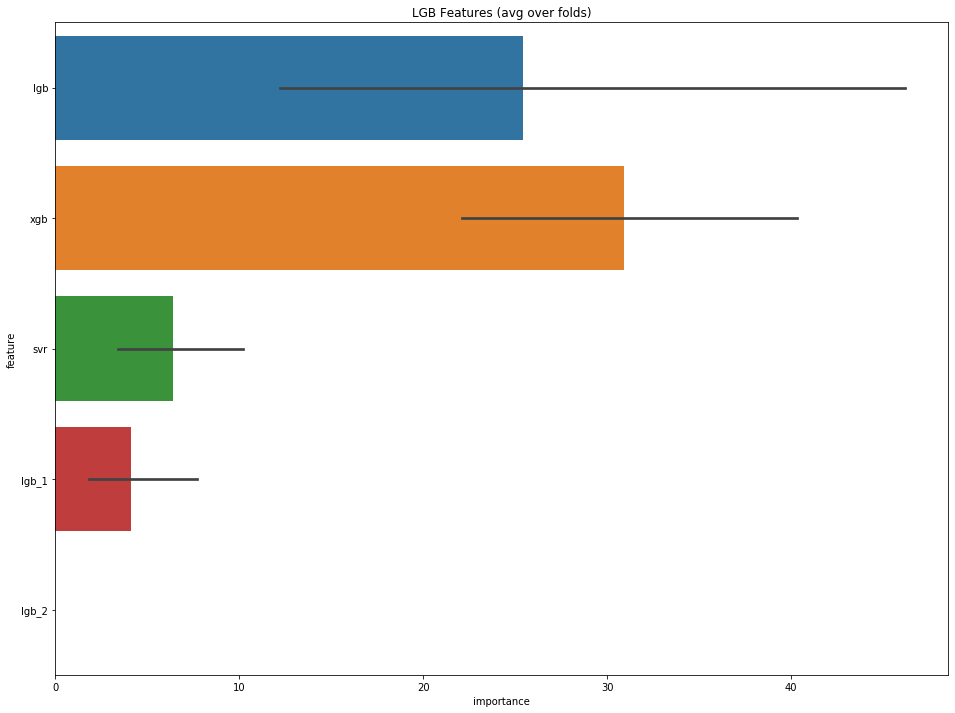

In [134]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:51:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[449]	training's rmse: 0.0888136	valid_1's rmse: 0.0342696
Fold 1 started at Tue Dec 17 11:51:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 0.0852466	valid_1's rmse: 0.0711601
Fold 2 started at Tue Dec 17 11:51:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[94]	training's rmse: 0.0720207	valid_1's rmse: 0.213949
Fold 3 started at Tue Dec 17 11:51:30 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.089303	valid_1's rmse: 0.0272353
Early stopping, best iteration is:
[886]	training's rmse: 0.0893166	valid_1's rmse: 0.027232
Fold 4 started at Tue Dec 17 11:51:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[60

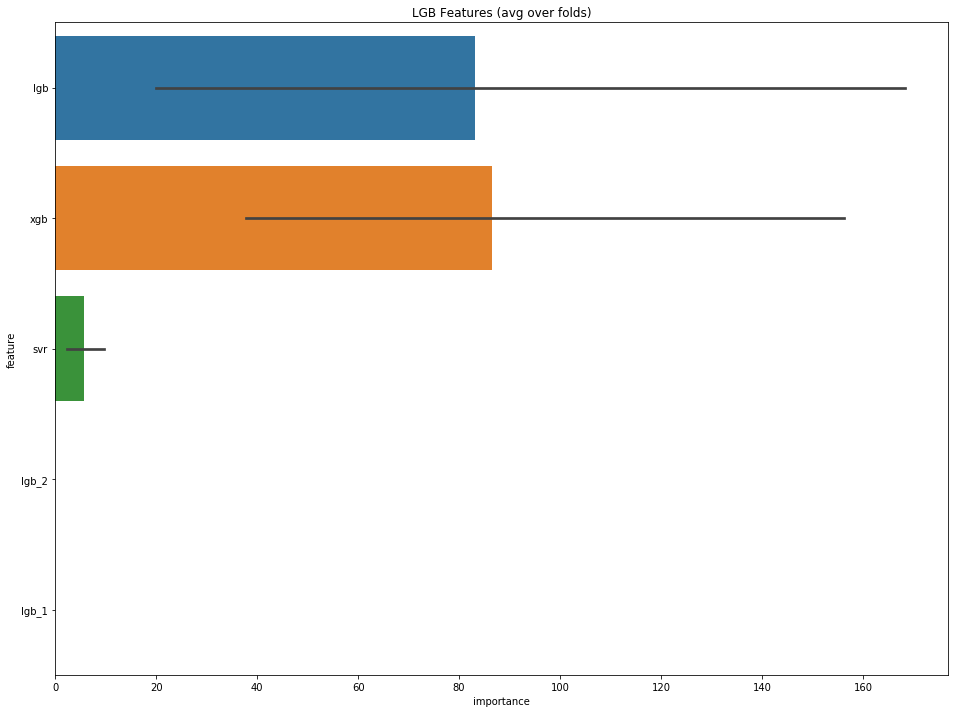

In [135]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [136]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:52:27 2019
Fold 1 started at Tue Dec 17 11:52:31 2019
Fold 2 started at Tue Dec 17 11:52:44 2019
Fold 3 started at Tue Dec 17 11:52:47 2019
Fold 4 started at Tue Dec 17 11:53:07 2019
Fold 5 started at Tue Dec 17 11:53:13 2019
Fold 6 started at Tue Dec 17 11:53:21 2019
Fold 7 started at Tue Dec 17 11:53:24 2019
Fold 8 started at Tue Dec 17 11:53:25 2019
Fold 9 started at Tue Dec 17 11:53:35 2019
CV mean score: 0.0679, std: 0.0557.


##### randomforest作为第二层融合模型

In [137]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:53:45 2019
Fold 1 started at Tue Dec 17 11:53:45 2019
Fold 2 started at Tue Dec 17 11:53:46 2019
Fold 3 started at Tue Dec 17 11:53:46 2019
Fold 4 started at Tue Dec 17 11:53:46 2019
Fold 5 started at Tue Dec 17 11:53:46 2019
Fold 6 started at Tue Dec 17 11:53:47 2019
Fold 7 started at Tue Dec 17 11:53:47 2019
Fold 8 started at Tue Dec 17 11:53:47 2019
Fold 9 started at Tue Dec 17 11:53:47 2019
CV mean score: 0.0725, std: 0.0512.


##### xgboost作为第二层融合模型

In [138]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:53:48 2019
[0]	train-rmse:0.207372	valid_data-rmse:0.153855
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[200]	train-rmse:0.054591	valid_data-rmse:0.04504

Fold 1 started at Tue Dec 17 11:53:48 2019
[0]	train-rmse:0.197606	valid_data-rmse:0.237964
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.016398	valid_data-rmse:0.050021
Stopping. Best iteration:
[603]	train-rmse:0.011466	valid_data-rmse:0.0495

Fold 2 started at Tue Dec 17 11:53:48 2019
[0]	train-rmse:0.200596	valid_data-rmse:0.216483
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[85]	train-rmse:0.098307	v

##### svr 作为第二层融合模型

In [139]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:53:49 2019
Fold 1 started at Tue Dec 17 11:53:49 2019
Fold 2 started at Tue Dec 17 11:53:49 2019
Fold 3 started at Tue Dec 17 11:53:49 2019
Fold 4 started at Tue Dec 17 11:53:49 2019
Fold 5 started at Tue Dec 17 11:53:49 2019
Fold 6 started at Tue Dec 17 11:53:49 2019
Fold 7 started at Tue Dec 17 11:53:49 2019
Fold 8 started at Tue Dec 17 11:53:49 2019
Fold 9 started at Tue Dec 17 11:53:49 2019
CV mean score: 0.0810, std: 0.0499.


##### 岭回归做第二层融合模型

In [140]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:53:49 2019
Fold 1 started at Tue Dec 17 11:53:49 2019
Fold 2 started at Tue Dec 17 11:53:49 2019
Fold 3 started at Tue Dec 17 11:53:49 2019
Fold 4 started at Tue Dec 17 11:53:50 2019
Fold 5 started at Tue Dec 17 11:53:50 2019
Fold 6 started at Tue Dec 17 11:53:50 2019
Fold 7 started at Tue Dec 17 11:53:50 2019
Fold 8 started at Tue Dec 17 11:53:50 2019
Fold 9 started at Tue Dec 17 11:53:50 2019
CV mean score: 0.0664, std: 0.0534.


#### 留下cat和rfr

In [141]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat, oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat', 'rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:53:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[324]	training's rmse: 0.104281	valid_1's rmse: 0.0419633
Fold 1 started at Tue Dec 17 11:53:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[319]	training's rmse: 0.105371	valid_1's rmse: 0.0848288
Fold 2 started at Tue Dec 17 11:53:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108303	valid_1's rmse: 0.231552
Fold 3 started at Tue Dec 17 11:53:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[336]	training's rmse: 0.0981669	valid_1's rmse: 0.0481195
Fold 4 started at Tue Dec 17 11:53:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[350]	training's rmse: 0.104862	valid_1's rmse: 0.0776459
Fold 5 

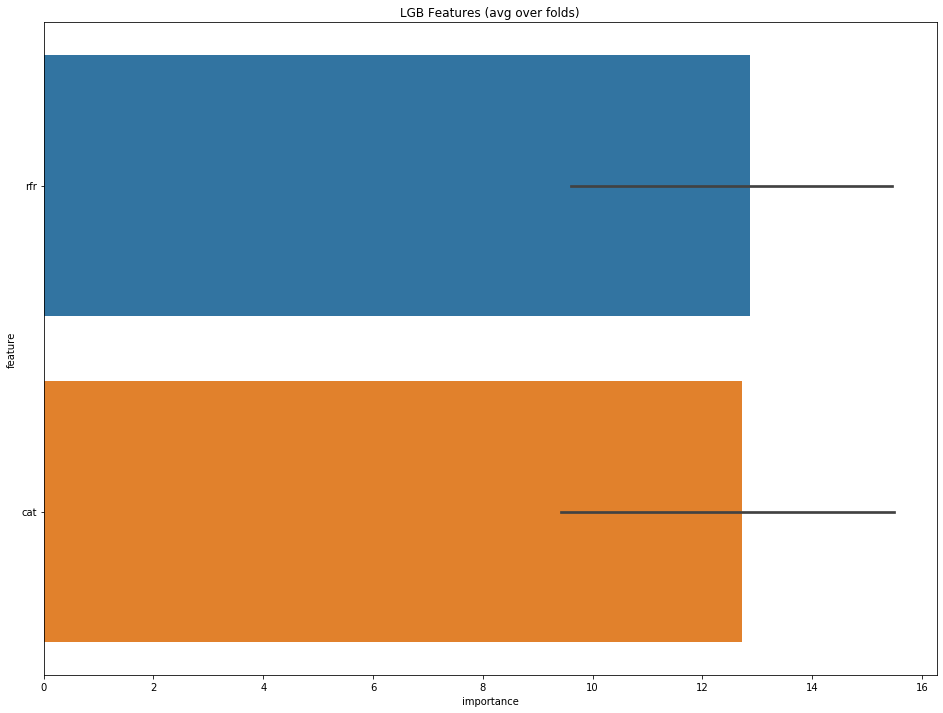

In [142]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:54:01 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0976096	valid_1's rmse: 0.045438
[2000]	training's rmse: 0.0976081	valid_1's rmse: 0.0454302
Early stopping, best iteration is:
[2441]	training's rmse: 0.0976081	valid_1's rmse: 0.0454302
Fold 1 started at Tue Dec 17 11:54:07 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.103588	valid_1's rmse: 0.0834589
[2000]	training's rmse: 0.103586	valid_1's rmse: 0.0834482
[3000]	training's rmse: 0.103586	valid_1's rmse: 0.0834482
Early stopping, best iteration is:
[3058]	training's rmse: 0.103586	valid_1's rmse: 0.0834482
Fold 2 started at Tue Dec 17 11:54:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108235	valid_1's rmse: 0.231746
Fold 3 started at Tue Dec 17 11:54:14 2019
Training until validation scores don't improve for 200 rounds.
[

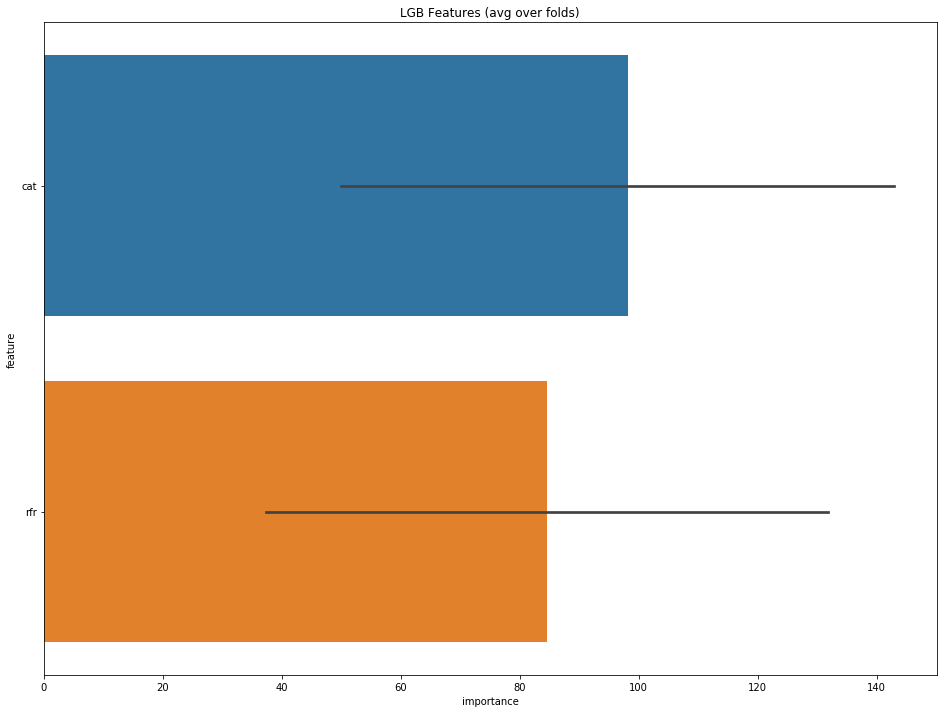

In [143]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [144]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:54:48 2019
Fold 1 started at Tue Dec 17 11:54:52 2019
Fold 2 started at Tue Dec 17 11:55:00 2019
Fold 3 started at Tue Dec 17 11:55:00 2019
Fold 4 started at Tue Dec 17 11:55:09 2019
Fold 5 started at Tue Dec 17 11:55:39 2019
Fold 6 started at Tue Dec 17 11:55:51 2019
Fold 7 started at Tue Dec 17 11:55:53 2019
Fold 8 started at Tue Dec 17 11:55:58 2019
Fold 9 started at Tue Dec 17 11:56:09 2019
CV mean score: 0.0718, std: 0.0549.


##### randomforest作为第二层融合模型

In [145]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 11:56:13 2019
Fold 1 started at Tue Dec 17 11:56:13 2019
Fold 2 started at Tue Dec 17 11:56:14 2019
Fold 3 started at Tue Dec 17 11:56:14 2019
Fold 4 started at Tue Dec 17 11:56:14 2019
Fold 5 started at Tue Dec 17 11:56:14 2019
Fold 6 started at Tue Dec 17 11:56:15 2019
Fold 7 started at Tue Dec 17 11:56:15 2019
Fold 8 started at Tue Dec 17 11:56:15 2019
Fold 9 started at Tue Dec 17 11:56:15 2019
CV mean score: 0.0805, std: 0.0600.


##### xgboost作为第二层融合模型

In [146]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 11:56:15 2019
[0]	train-rmse:0.207551	valid_data-rmse:0.154559
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.021444	valid_data-rmse:0.050382
[1000]	train-rmse:0.006183	valid_data-rmse:0.049239
Stopping. Best iteration:
[994]	train-rmse:0.00625	valid_data-rmse:0.049218

Fold 1 started at Tue Dec 17 11:56:16 2019
[0]	train-rmse:0.197635	valid_data-rmse:0.237751
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.021192	valid_data-rmse:0.049754
Stopping. Best iteration:
[481]	train-rmse:0.022343	valid_data-rmse:0.049451

Fold 2 started at Tue Dec 17 11:56:16 2019
[0]	train-rmse:0.200611	valid_data-rmse:0.21615
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train u

##### svr 作为第二层融合模型

In [147]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 11:56:16 2019
Fold 1 started at Tue Dec 17 11:56:17 2019
Fold 2 started at Tue Dec 17 11:56:17 2019
Fold 3 started at Tue Dec 17 11:56:17 2019
Fold 4 started at Tue Dec 17 11:56:17 2019
Fold 5 started at Tue Dec 17 11:56:17 2019
Fold 6 started at Tue Dec 17 11:56:17 2019
Fold 7 started at Tue Dec 17 11:56:17 2019
Fold 8 started at Tue Dec 17 11:56:17 2019
Fold 9 started at Tue Dec 17 11:56:17 2019
CV mean score: 0.0797, std: 0.0559.


##### 岭回归做第二层融合模型

In [148]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 11:56:17 2019
Fold 1 started at Tue Dec 17 11:56:17 2019
Fold 2 started at Tue Dec 17 11:56:17 2019
Fold 3 started at Tue Dec 17 11:56:17 2019
Fold 4 started at Tue Dec 17 11:56:17 2019
Fold 5 started at Tue Dec 17 11:56:17 2019
Fold 6 started at Tue Dec 17 11:56:17 2019
Fold 7 started at Tue Dec 17 11:56:17 2019
Fold 8 started at Tue Dec 17 11:56:17 2019
Fold 9 started at Tue Dec 17 11:56:18 2019
CV mean score: 0.0703, std: 0.0558.


#### 留下cat和svr

In [149]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_cat, oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'cat','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 11:56:18 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[467]	training's rmse: 0.10359	valid_1's rmse: 0.0444959
Fold 1 started at Tue Dec 17 11:56:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[536]	training's rmse: 0.105516	valid_1's rmse: 0.082545
Fold 2 started at Tue Dec 17 11:56:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108427	valid_1's rmse: 0.231539
Fold 3 started at Tue Dec 17 11:56:24 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0960504	valid_1's rmse: 0.0417736
Early stopping, best iteration is:
[1130]	training's rmse: 0.0956685	valid_1's rmse: 0.0416051
Fold 4 started at Tue Dec 17 11:56:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[468]	

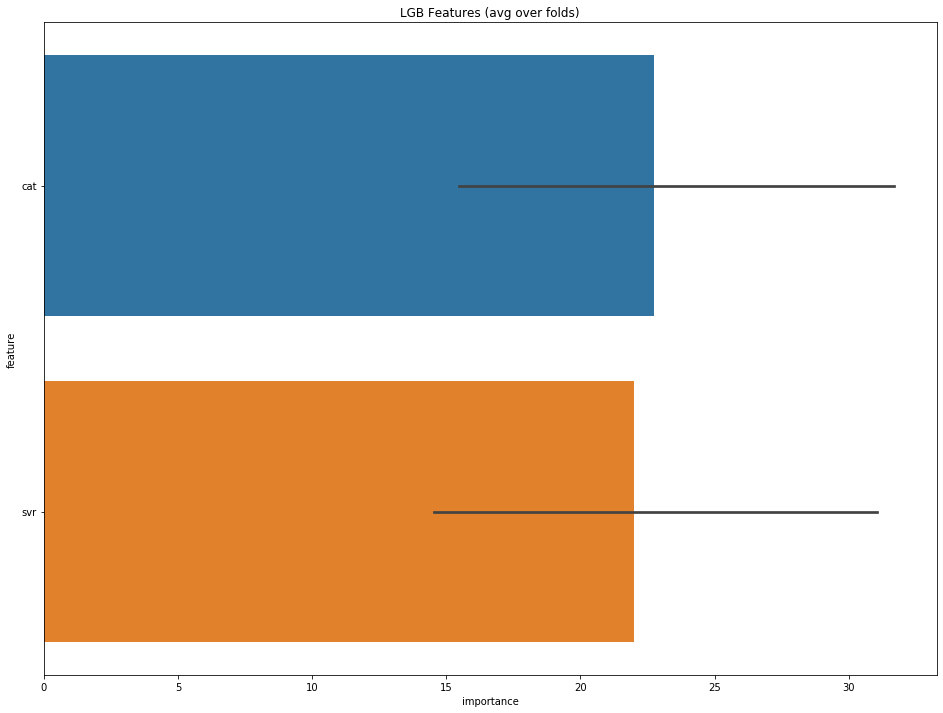

In [150]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 11:56:45 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0972575	valid_1's rmse: 0.0467571
[2000]	training's rmse: 0.0972559	valid_1's rmse: 0.0467503
Early stopping, best iteration is:
[2362]	training's rmse: 0.0972544	valid_1's rmse: 0.0467444
Fold 1 started at Tue Dec 17 11:56:56 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.10351	valid_1's rmse: 0.0813051
[2000]	training's rmse: 0.103509	valid_1's rmse: 0.0813027
Early stopping, best iteration is:
[2416]	training's rmse: 0.103509	valid_1's rmse: 0.0813027
Fold 2 started at Tue Dec 17 11:57:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108235	valid_1's rmse: 0.231746
Fold 3 started at Tue Dec 17 11:57:06 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0933882	valid_1's rmse: 0.0438157


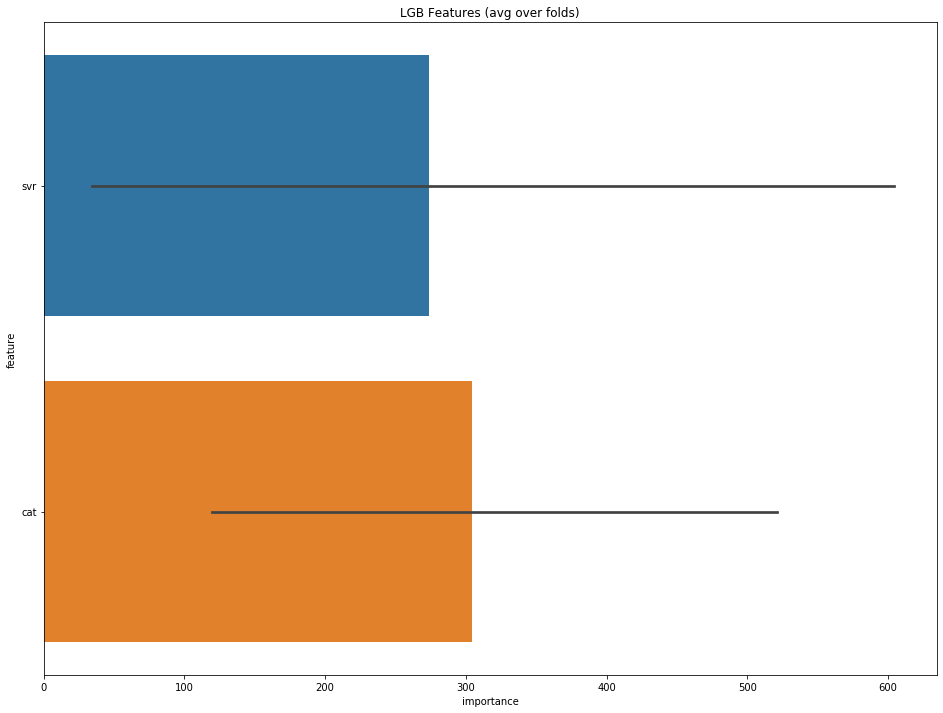

In [151]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [152]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 11:59:16 2019
Fold 1 started at Tue Dec 17 11:59:21 2019
Fold 2 started at Tue Dec 17 11:59:30 2019
Fold 3 started at Tue Dec 17 11:59:30 2019
Fold 4 started at Tue Dec 17 11:59:38 2019
Fold 5 started at Tue Dec 17 11:59:43 2019
Fold 6 started at Tue Dec 17 12:00:01 2019
Fold 7 started at Tue Dec 17 12:00:03 2019
Fold 8 started at Tue Dec 17 12:00:06 2019
Fold 9 started at Tue Dec 17 12:00:20 2019
CV mean score: 0.0719, std: 0.0549.


##### randomforest作为第二层融合模型

In [153]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:00:24 2019
Fold 1 started at Tue Dec 17 12:00:25 2019
Fold 2 started at Tue Dec 17 12:00:25 2019
Fold 3 started at Tue Dec 17 12:00:25 2019
Fold 4 started at Tue Dec 17 12:00:25 2019
Fold 5 started at Tue Dec 17 12:00:26 2019
Fold 6 started at Tue Dec 17 12:00:26 2019
Fold 7 started at Tue Dec 17 12:00:26 2019
Fold 8 started at Tue Dec 17 12:00:26 2019
Fold 9 started at Tue Dec 17 12:00:27 2019
CV mean score: 0.0797, std: 0.0646.


##### xgboost作为第二层融合模型

In [154]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:00:27 2019
[0]	train-rmse:0.207551	valid_data-rmse:0.154559
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.020349	valid_data-rmse:0.044749
Stopping. Best iteration:
[389]	train-rmse:0.029392	valid_data-rmse:0.04361

Fold 1 started at Tue Dec 17 12:00:27 2019
[0]	train-rmse:0.197635	valid_data-rmse:0.237751
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.0211	valid_data-rmse:0.042739
Stopping. Best iteration:
[389]	train-rmse:0.029636	valid_data-rmse:0.040743

Fold 2 started at Tue Dec 17 12:00:27 2019
[0]	train-rmse:0.200611	valid_data-rmse:0.21615
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
St

##### svr 作为第二层融合模型

In [155]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:00:28 2019
Fold 1 started at Tue Dec 17 12:00:28 2019
Fold 2 started at Tue Dec 17 12:00:28 2019
Fold 3 started at Tue Dec 17 12:00:28 2019
Fold 4 started at Tue Dec 17 12:00:28 2019
Fold 5 started at Tue Dec 17 12:00:28 2019
Fold 6 started at Tue Dec 17 12:00:28 2019
Fold 7 started at Tue Dec 17 12:00:28 2019
Fold 8 started at Tue Dec 17 12:00:28 2019
Fold 9 started at Tue Dec 17 12:00:28 2019
CV mean score: 0.0804, std: 0.0558.


##### 岭回归做第二层融合模型

In [156]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:00:28 2019
Fold 1 started at Tue Dec 17 12:00:28 2019
Fold 2 started at Tue Dec 17 12:00:28 2019
Fold 3 started at Tue Dec 17 12:00:28 2019
Fold 4 started at Tue Dec 17 12:00:28 2019
Fold 5 started at Tue Dec 17 12:00:28 2019
Fold 6 started at Tue Dec 17 12:00:29 2019
Fold 7 started at Tue Dec 17 12:00:29 2019
Fold 8 started at Tue Dec 17 12:00:29 2019
Fold 9 started at Tue Dec 17 12:00:29 2019
CV mean score: 0.0717, std: 0.0569.


#### 留下rfr和svr

In [157]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_svr,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['svr','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:00:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[560]	training's rmse: 0.107519	valid_1's rmse: 0.0408876
Fold 1 started at Tue Dec 17 12:00:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[446]	training's rmse: 0.107265	valid_1's rmse: 0.0849857
Fold 2 started at Tue Dec 17 12:00:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108303	valid_1's rmse: 0.231552
Fold 3 started at Tue Dec 17 12:00:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[263]	training's rmse: 0.107036	valid_1's rmse: 0.0663437
Fold 4 started at Tue Dec 17 12:00:37 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[351]	training's rmse: 0.106195	valid_1's rmse: 0.0916439
Fold 5 s

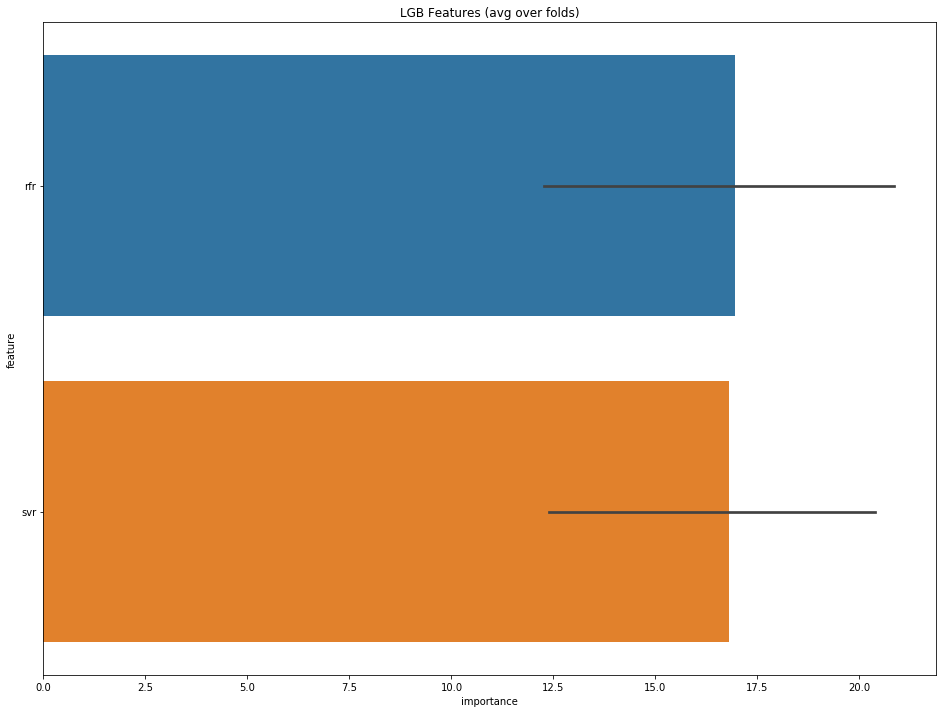

In [158]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:00:50 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.106408	valid_1's rmse: 0.0405896
[2000]	training's rmse: 0.106406	valid_1's rmse: 0.0405791
[3000]	training's rmse: 0.106406	valid_1's rmse: 0.0405791
[4000]	training's rmse: 0.106406	valid_1's rmse: 0.0405791
[5000]	training's rmse: 0.106406	valid_1's rmse: 0.0405791
Early stopping, best iteration is:
[5048]	training's rmse: 0.106406	valid_1's rmse: 0.0405791
Fold 1 started at Tue Dec 17 12:01:09 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.105604	valid_1's rmse: 0.0777016
[2000]	training's rmse: 0.105602	valid_1's rmse: 0.0776824
Early stopping, best iteration is:
[2469]	training's rmse: 0.105602	valid_1's rmse: 0.0776824
Fold 2 started at Tue Dec 17 12:01:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108223	valid_1's rmse: 

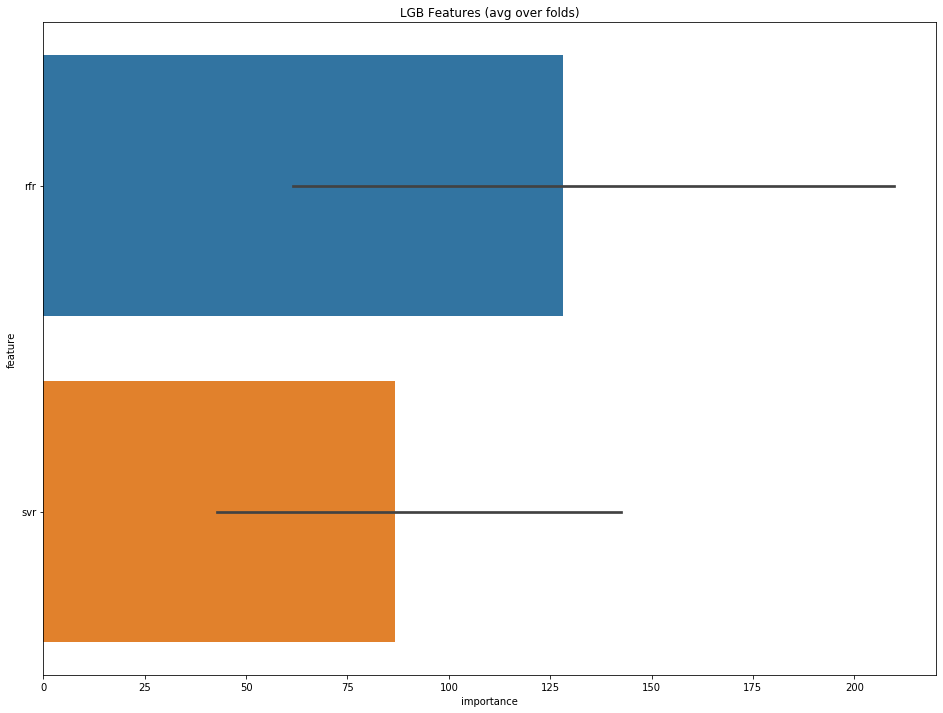

In [159]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [160]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:02:05 2019
Fold 1 started at Tue Dec 17 12:02:10 2019
Fold 2 started at Tue Dec 17 12:02:20 2019
Fold 3 started at Tue Dec 17 12:02:20 2019
Fold 4 started at Tue Dec 17 12:02:25 2019
Fold 5 started at Tue Dec 17 12:02:32 2019
Fold 6 started at Tue Dec 17 12:02:42 2019
Fold 7 started at Tue Dec 17 12:02:45 2019
Fold 8 started at Tue Dec 17 12:02:50 2019
Fold 9 started at Tue Dec 17 12:02:54 2019
CV mean score: 0.0809, std: 0.0542.


##### randomforest作为第二层融合模型

In [161]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:03:02 2019
Fold 1 started at Tue Dec 17 12:03:02 2019
Fold 2 started at Tue Dec 17 12:03:02 2019
Fold 3 started at Tue Dec 17 12:03:02 2019
Fold 4 started at Tue Dec 17 12:03:03 2019
Fold 5 started at Tue Dec 17 12:03:03 2019
Fold 6 started at Tue Dec 17 12:03:03 2019
Fold 7 started at Tue Dec 17 12:03:03 2019
Fold 8 started at Tue Dec 17 12:03:04 2019
Fold 9 started at Tue Dec 17 12:03:04 2019
CV mean score: 0.0826, std: 0.0679.


##### xgboost作为第二层融合模型

In [162]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:03:04 2019
[0]	train-rmse:0.207711	valid_data-rmse:0.154178
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[252]	train-rmse:0.049665	valid_data-rmse:0.047226

Fold 1 started at Tue Dec 17 12:03:04 2019
[0]	train-rmse:0.197767	valid_data-rmse:0.238189
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.0203	valid_data-rmse:0.05293
Stopping. Best iteration:
[528]	train-rmse:0.018664	valid_data-rmse:0.052793

Fold 2 started at Tue Dec 17 12:03:04 2019
[0]	train-rmse:0.200681	valid_data-rmse:0.216384
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[23]	train-rmse:0.165144	v

##### svr 作为第二层融合模型

In [163]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:03:05 2019
Fold 1 started at Tue Dec 17 12:03:05 2019
Fold 2 started at Tue Dec 17 12:03:05 2019
Fold 3 started at Tue Dec 17 12:03:05 2019
Fold 4 started at Tue Dec 17 12:03:05 2019
Fold 5 started at Tue Dec 17 12:03:05 2019
Fold 6 started at Tue Dec 17 12:03:05 2019
Fold 7 started at Tue Dec 17 12:03:05 2019
Fold 8 started at Tue Dec 17 12:03:05 2019
Fold 9 started at Tue Dec 17 12:03:05 2019
CV mean score: 0.0861, std: 0.0608.


##### 岭回归做第二层融合模型

In [164]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:03:05 2019
Fold 1 started at Tue Dec 17 12:03:05 2019
Fold 2 started at Tue Dec 17 12:03:05 2019
Fold 3 started at Tue Dec 17 12:03:06 2019
Fold 4 started at Tue Dec 17 12:03:06 2019
Fold 5 started at Tue Dec 17 12:03:06 2019
Fold 6 started at Tue Dec 17 12:03:06 2019
Fold 7 started at Tue Dec 17 12:03:06 2019
Fold 8 started at Tue Dec 17 12:03:06 2019
Fold 9 started at Tue Dec 17 12:03:06 2019
CV mean score: 0.0860, std: 0.0651.


#### 留下xgb和cat

In [165]:
#构建第二层训练矩阵
train_stack = np.vstack([ oof_xgb, oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns=[ 'xgb', 'cat'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:03:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[620]	training's rmse: 0.0917621	valid_1's rmse: 0.0296991
Fold 1 started at Tue Dec 17 12:03:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[540]	training's rmse: 0.0901698	valid_1's rmse: 0.0814305
Fold 2 started at Tue Dec 17 12:03:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[348]	training's rmse: 0.0592574	valid_1's rmse: 0.224841
Fold 3 started at Tue Dec 17 12:03:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[567]	training's rmse: 0.0883707	valid_1's rmse: 0.0247567
Fold 4 started at Tue Dec 17 12:03:16 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[755]	training's rmse: 0.0910124	valid_1's rmse: 0.0658613
F

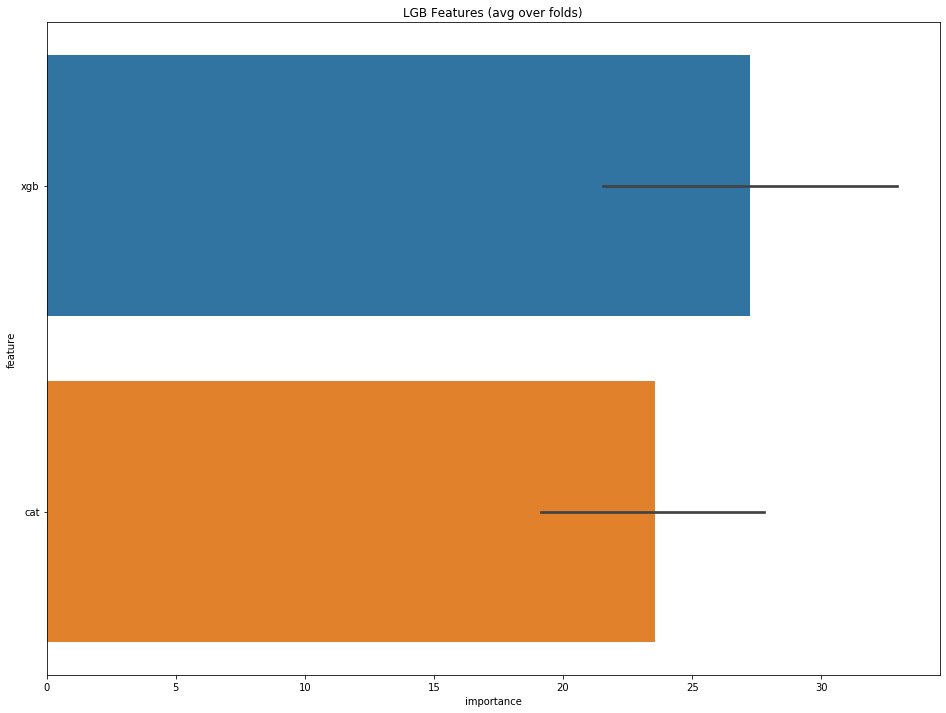

In [166]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:03:32 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[373]	training's rmse: 0.0873926	valid_1's rmse: 0.0297199
Fold 1 started at Tue Dec 17 12:03:34 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0875056	valid_1's rmse: 0.082235
[2000]	training's rmse: 0.0875031	valid_1's rmse: 0.0822348
Early stopping, best iteration is:
[1960]	training's rmse: 0.0875031	valid_1's rmse: 0.0822348
Fold 2 started at Tue Dec 17 12:03:41 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0576369	valid_1's rmse: 0.221373
[2000]	training's rmse: 0.0576332	valid_1's rmse: 0.221362
Early stopping, best iteration is:
[2544]	training's rmse: 0.0576332	valid_1's rmse: 0.221362
Fold 3 started at Tue Dec 17 12:03:49 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0861806	valid_1's rmse: 0.0194

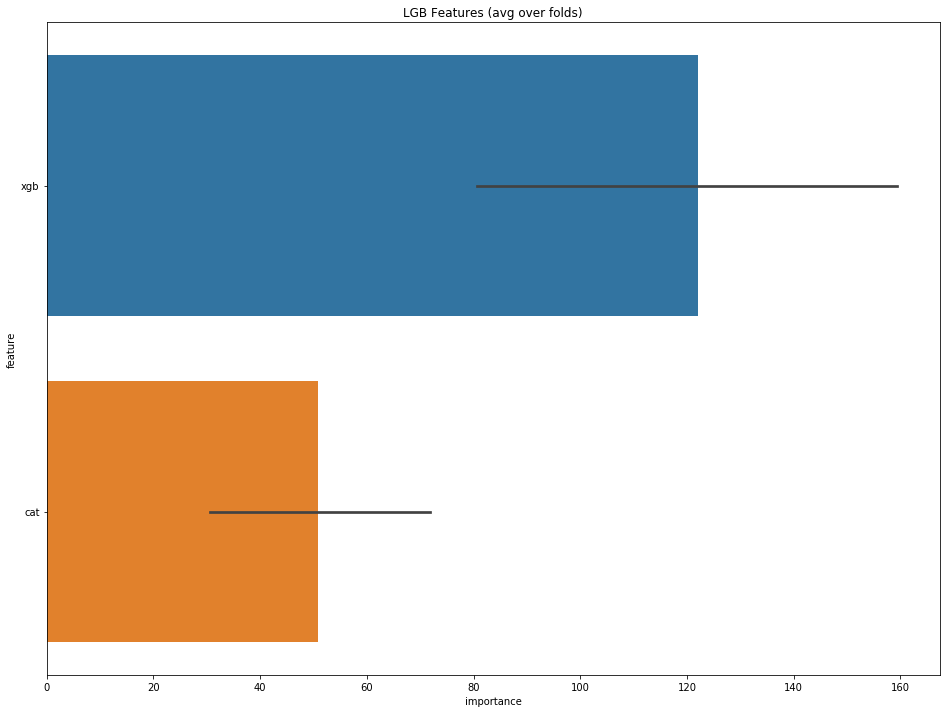

In [167]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [168]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:04:26 2019
Fold 1 started at Tue Dec 17 12:04:30 2019
Fold 2 started at Tue Dec 17 12:04:39 2019
Fold 3 started at Tue Dec 17 12:04:44 2019
Fold 4 started at Tue Dec 17 12:04:52 2019
Fold 5 started at Tue Dec 17 12:04:56 2019
Fold 6 started at Tue Dec 17 12:05:07 2019
Fold 7 started at Tue Dec 17 12:05:10 2019
Fold 8 started at Tue Dec 17 12:05:16 2019
Fold 9 started at Tue Dec 17 12:05:31 2019
CV mean score: 0.0639, std: 0.0535.


##### randomforest作为第二层融合模型

In [169]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:05:36 2019
Fold 1 started at Tue Dec 17 12:05:37 2019
Fold 2 started at Tue Dec 17 12:05:37 2019
Fold 3 started at Tue Dec 17 12:05:37 2019
Fold 4 started at Tue Dec 17 12:05:37 2019
Fold 5 started at Tue Dec 17 12:05:38 2019
Fold 6 started at Tue Dec 17 12:05:38 2019
Fold 7 started at Tue Dec 17 12:05:38 2019
Fold 8 started at Tue Dec 17 12:05:38 2019
Fold 9 started at Tue Dec 17 12:05:38 2019
CV mean score: 0.0668, std: 0.0529.


##### xgboost作为第二层融合模型

In [170]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:05:39 2019
[0]	train-rmse:0.207403	valid_data-rmse:0.153863
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[198]	train-rmse:0.057195	valid_data-rmse:0.049506

Fold 1 started at Tue Dec 17 12:05:39 2019
[0]	train-rmse:0.197671	valid_data-rmse:0.237767
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.017254	valid_data-rmse:0.056078
Stopping. Best iteration:
[353]	train-rmse:0.028965	valid_data-rmse:0.05538

Fold 2 started at Tue Dec 17 12:05:39 2019
[0]	train-rmse:0.200624	valid_data-rmse:0.216492
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[47]	train-rmse:0.134261

##### svr 作为第二层融合模型

In [171]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:05:40 2019
Fold 1 started at Tue Dec 17 12:05:40 2019
Fold 2 started at Tue Dec 17 12:05:40 2019
Fold 3 started at Tue Dec 17 12:05:40 2019
Fold 4 started at Tue Dec 17 12:05:40 2019
Fold 5 started at Tue Dec 17 12:05:40 2019
Fold 6 started at Tue Dec 17 12:05:40 2019
Fold 7 started at Tue Dec 17 12:05:40 2019
Fold 8 started at Tue Dec 17 12:05:40 2019
Fold 9 started at Tue Dec 17 12:05:40 2019
CV mean score: 0.0756, std: 0.0507.


##### 岭回归做第二层融合模型

In [172]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:05:40 2019
Fold 1 started at Tue Dec 17 12:05:40 2019
Fold 2 started at Tue Dec 17 12:05:40 2019
Fold 3 started at Tue Dec 17 12:05:40 2019
Fold 4 started at Tue Dec 17 12:05:40 2019
Fold 5 started at Tue Dec 17 12:05:40 2019
Fold 6 started at Tue Dec 17 12:05:40 2019
Fold 7 started at Tue Dec 17 12:05:41 2019
Fold 8 started at Tue Dec 17 12:05:41 2019
Fold 9 started at Tue Dec 17 12:05:41 2019
CV mean score: 0.0662, std: 0.0534.


#### 留下xgb和rfr

In [173]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:05:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[412]	training's rmse: 0.0943657	valid_1's rmse: 0.0356172
Fold 1 started at Tue Dec 17 12:05:43 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[654]	training's rmse: 0.0899537	valid_1's rmse: 0.0791577
Fold 2 started at Tue Dec 17 12:05:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[460]	training's rmse: 0.0567846	valid_1's rmse: 0.224747
Fold 3 started at Tue Dec 17 12:05:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[602]	training's rmse: 0.0933948	valid_1's rmse: 0.0318412
Fold 4 started at Tue Dec 17 12:05:52 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0899062	valid_1's rmse: 0.0670183
Early stopping, best iteration is:


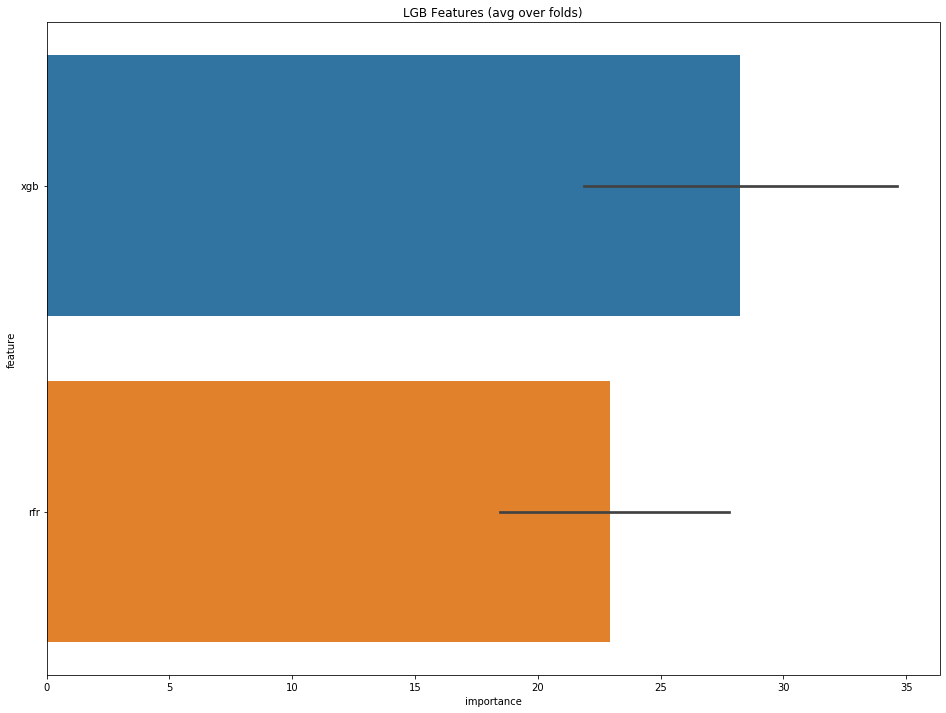

In [174]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:06:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[356]	training's rmse: 0.0912994	valid_1's rmse: 0.0327237
Fold 1 started at Tue Dec 17 12:06:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[444]	training's rmse: 0.0865318	valid_1's rmse: 0.0788933
Fold 2 started at Tue Dec 17 12:06:14 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[30]	training's rmse: 0.0925396	valid_1's rmse: 0.223902
Fold 3 started at Tue Dec 17 12:06:15 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0904148	valid_1's rmse: 0.0265252
Early stopping, best iteration is:
[865]	training's rmse: 0.0904337	valid_1's rmse: 0.0265181
Fold 4 started at Tue Dec 17 12:06:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[

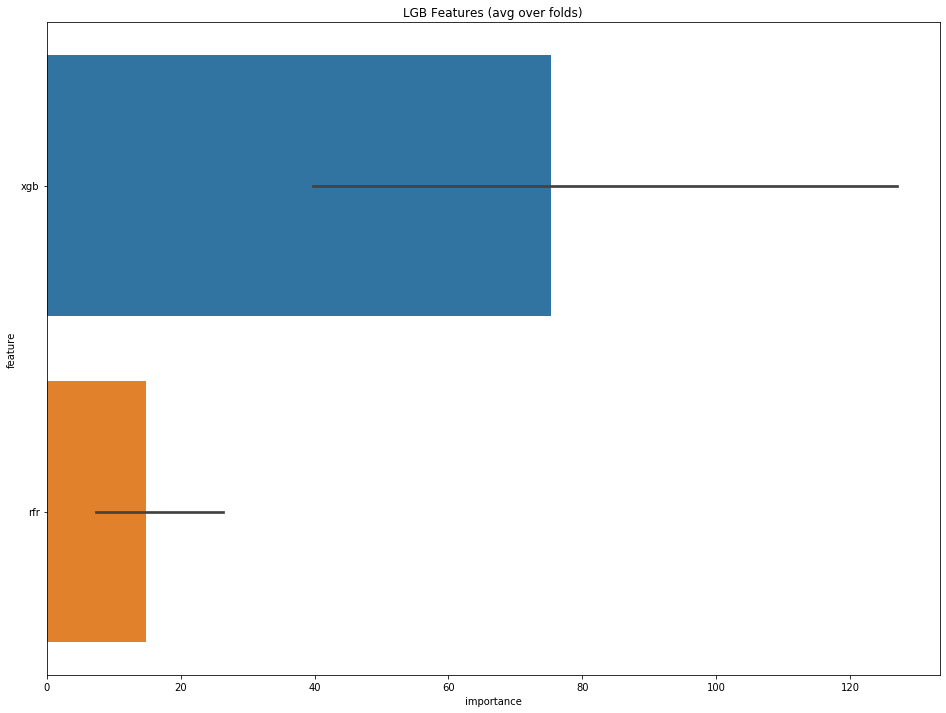

In [175]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [176]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:06:44 2019
Fold 1 started at Tue Dec 17 12:06:48 2019
Fold 2 started at Tue Dec 17 12:06:59 2019
Fold 3 started at Tue Dec 17 12:07:01 2019
Fold 4 started at Tue Dec 17 12:07:10 2019
Fold 5 started at Tue Dec 17 12:07:13 2019
Fold 6 started at Tue Dec 17 12:07:18 2019
Fold 7 started at Tue Dec 17 12:07:20 2019
Fold 8 started at Tue Dec 17 12:07:24 2019
Fold 9 started at Tue Dec 17 12:07:46 2019
CV mean score: 0.0702, std: 0.0548.


##### randomforest作为第二层融合模型

In [177]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:07:50 2019
Fold 1 started at Tue Dec 17 12:07:50 2019
Fold 2 started at Tue Dec 17 12:07:50 2019
Fold 3 started at Tue Dec 17 12:07:51 2019
Fold 4 started at Tue Dec 17 12:07:51 2019
Fold 5 started at Tue Dec 17 12:07:51 2019
Fold 6 started at Tue Dec 17 12:07:51 2019
Fold 7 started at Tue Dec 17 12:07:52 2019
Fold 8 started at Tue Dec 17 12:07:52 2019
Fold 9 started at Tue Dec 17 12:07:52 2019
CV mean score: 0.0694, std: 0.0533.


##### xgboost作为第二层融合模型

In [178]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:07:52 2019
[0]	train-rmse:0.207403	valid_data-rmse:0.153863
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[176]	train-rmse:0.067359	valid_data-rmse:0.049021

Fold 1 started at Tue Dec 17 12:07:52 2019
[0]	train-rmse:0.197671	valid_data-rmse:0.237767
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.017982	valid_data-rmse:0.060767
Stopping. Best iteration:
[461]	train-rmse:0.020507	valid_data-rmse:0.06054

Fold 2 started at Tue Dec 17 12:07:52 2019
[0]	train-rmse:0.200624	valid_data-rmse:0.216492
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[32]	train-rmse:0.152657

##### svr 作为第二层融合模型

In [179]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:07:54 2019
Fold 1 started at Tue Dec 17 12:07:54 2019
Fold 2 started at Tue Dec 17 12:07:54 2019
Fold 3 started at Tue Dec 17 12:07:54 2019
Fold 4 started at Tue Dec 17 12:07:54 2019
Fold 5 started at Tue Dec 17 12:07:54 2019
Fold 6 started at Tue Dec 17 12:07:54 2019
Fold 7 started at Tue Dec 17 12:07:54 2019
Fold 8 started at Tue Dec 17 12:07:54 2019
Fold 9 started at Tue Dec 17 12:07:54 2019
CV mean score: 0.0805, std: 0.0511.


##### 岭回归做第二层融合模型

In [180]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:07:54 2019
Fold 1 started at Tue Dec 17 12:07:54 2019
Fold 2 started at Tue Dec 17 12:07:54 2019
Fold 3 started at Tue Dec 17 12:07:54 2019
Fold 4 started at Tue Dec 17 12:07:54 2019
Fold 5 started at Tue Dec 17 12:07:54 2019
Fold 6 started at Tue Dec 17 12:07:54 2019
Fold 7 started at Tue Dec 17 12:07:54 2019
Fold 8 started at Tue Dec 17 12:07:55 2019
Fold 9 started at Tue Dec 17 12:07:55 2019
CV mean score: 0.0690, std: 0.0542.


#### 留下xgb和svr

In [181]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb', 'svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:07:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[645]	training's rmse: 0.0928346	valid_1's rmse: 0.0315138
Fold 1 started at Tue Dec 17 12:07:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[532]	training's rmse: 0.090002	valid_1's rmse: 0.0786161
Fold 2 started at Tue Dec 17 12:07:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[470]	training's rmse: 0.0586149	valid_1's rmse: 0.221742
Fold 3 started at Tue Dec 17 12:08:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[577]	training's rmse: 0.0932703	valid_1's rmse: 0.0274697
Fold 4 started at Tue Dec 17 12:08:03 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0888391	valid_1's rmse: 0.0738999
Early stopping, best iteration is:
[

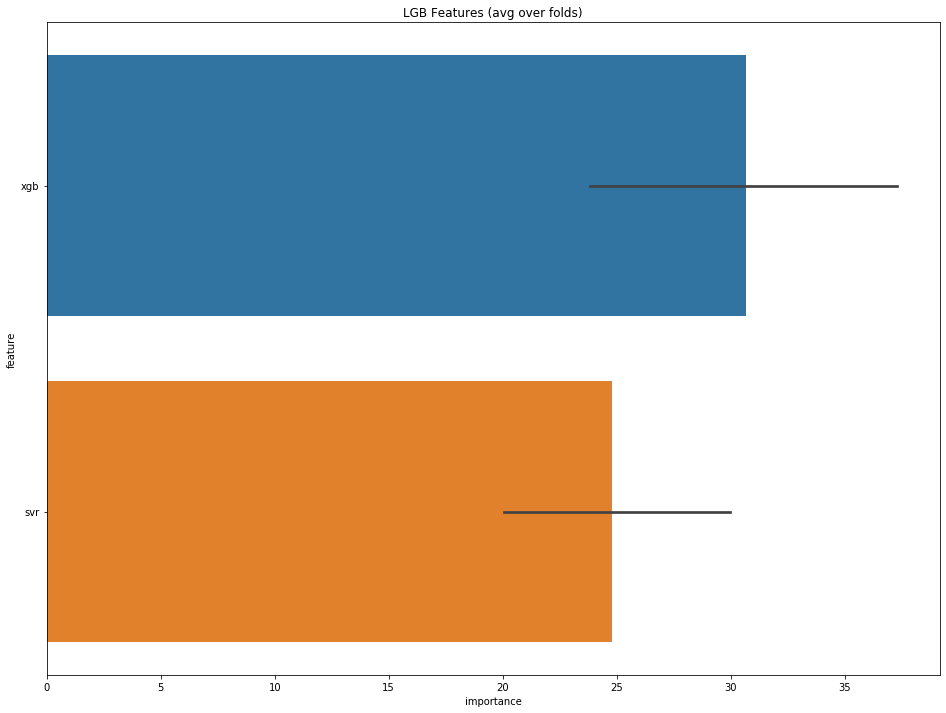

In [182]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:08:18 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0914637	valid_1's rmse: 0.0328241
Early stopping, best iteration is:
[1054]	training's rmse: 0.0914592	valid_1's rmse: 0.0328197
Fold 1 started at Tue Dec 17 12:08:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[529]	training's rmse: 0.0871061	valid_1's rmse: 0.081203
Fold 2 started at Tue Dec 17 12:08:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[92]	training's rmse: 0.074374	valid_1's rmse: 0.214979
Fold 3 started at Tue Dec 17 12:08:25 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0915144	valid_1's rmse: 0.0271729
[2000]	training's rmse: 0.0915113	valid_1's rmse: 0.0271665
Early stopping, best iteration is:
[2408]	training's rmse: 0.0915113	valid_1's rmse: 0.0271665
Fold 4 started at Tue 

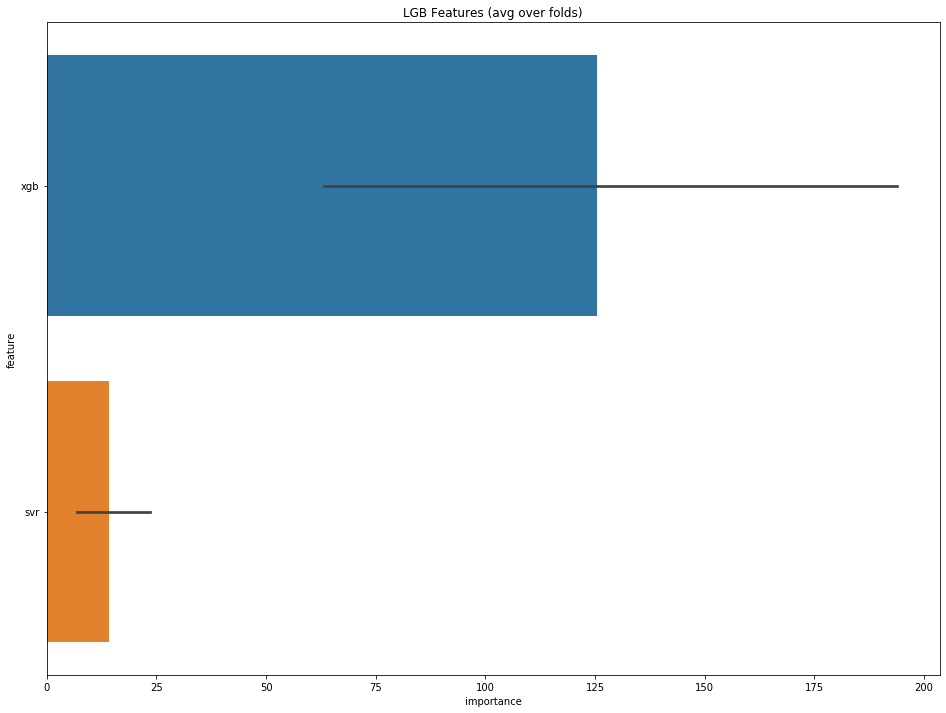

In [183]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [184]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:09:08 2019
Fold 1 started at Tue Dec 17 12:09:12 2019
Fold 2 started at Tue Dec 17 12:09:19 2019
Fold 3 started at Tue Dec 17 12:09:22 2019
Fold 4 started at Tue Dec 17 12:09:31 2019
Fold 5 started at Tue Dec 17 12:09:36 2019
Fold 6 started at Tue Dec 17 12:10:06 2019
Fold 7 started at Tue Dec 17 12:10:10 2019
Fold 8 started at Tue Dec 17 12:10:16 2019
Fold 9 started at Tue Dec 17 12:10:37 2019
CV mean score: 0.0673, std: 0.0547.


##### randomforest作为第二层融合模型

In [185]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:10:45 2019
Fold 1 started at Tue Dec 17 12:10:45 2019
Fold 2 started at Tue Dec 17 12:10:46 2019
Fold 3 started at Tue Dec 17 12:10:46 2019
Fold 4 started at Tue Dec 17 12:10:46 2019
Fold 5 started at Tue Dec 17 12:10:46 2019
Fold 6 started at Tue Dec 17 12:10:46 2019
Fold 7 started at Tue Dec 17 12:10:47 2019
Fold 8 started at Tue Dec 17 12:10:47 2019
Fold 9 started at Tue Dec 17 12:10:47 2019
CV mean score: 0.0689, std: 0.0551.


##### xgboost作为第二层融合模型

In [186]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:10:47 2019
[0]	train-rmse:0.207403	valid_data-rmse:0.153863
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[199]	train-rmse:0.060239	valid_data-rmse:0.049414

Fold 1 started at Tue Dec 17 12:10:47 2019
[0]	train-rmse:0.197671	valid_data-rmse:0.237767
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.019899	valid_data-rmse:0.060126
Stopping. Best iteration:
[327]	train-rmse:0.035855	valid_data-rmse:0.054115

Fold 2 started at Tue Dec 17 12:10:48 2019
[0]	train-rmse:0.200624	valid_data-rmse:0.216492
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[37]	train-rmse:0.14652

##### svr 作为第二层融合模型

In [187]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:10:49 2019
Fold 1 started at Tue Dec 17 12:10:49 2019
Fold 2 started at Tue Dec 17 12:10:49 2019
Fold 3 started at Tue Dec 17 12:10:49 2019
Fold 4 started at Tue Dec 17 12:10:49 2019
Fold 5 started at Tue Dec 17 12:10:49 2019
Fold 6 started at Tue Dec 17 12:10:49 2019
Fold 7 started at Tue Dec 17 12:10:49 2019
Fold 8 started at Tue Dec 17 12:10:49 2019
Fold 9 started at Tue Dec 17 12:10:49 2019
CV mean score: 0.0804, std: 0.0494.


##### 岭回归做第二层融合模型

In [188]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:10:49 2019
Fold 1 started at Tue Dec 17 12:10:49 2019
Fold 2 started at Tue Dec 17 12:10:49 2019
Fold 3 started at Tue Dec 17 12:10:49 2019
Fold 4 started at Tue Dec 17 12:10:49 2019
Fold 5 started at Tue Dec 17 12:10:49 2019
Fold 6 started at Tue Dec 17 12:10:49 2019
Fold 7 started at Tue Dec 17 12:10:49 2019
Fold 8 started at Tue Dec 17 12:10:49 2019
Fold 9 started at Tue Dec 17 12:10:50 2019
CV mean score: 0.0693, std: 0.0555.


#### 留下lgb和cat

In [189]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb, oof_cat, oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'cat', 'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:10:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[340]	training's rmse: 0.0941351	valid_1's rmse: 0.037746
Fold 1 started at Tue Dec 17 12:10:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[563]	training's rmse: 0.0944986	valid_1's rmse: 0.0711388
Fold 2 started at Tue Dec 17 12:10:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108331	valid_1's rmse: 0.231116
Fold 3 started at Tue Dec 17 12:10:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[746]	training's rmse: 0.0915408	valid_1's rmse: 0.0392565
Fold 4 started at Tue Dec 17 12:10:59 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[499]	training's rmse: 0.0944547	valid_1's rmse: 0.0662137
Fold 

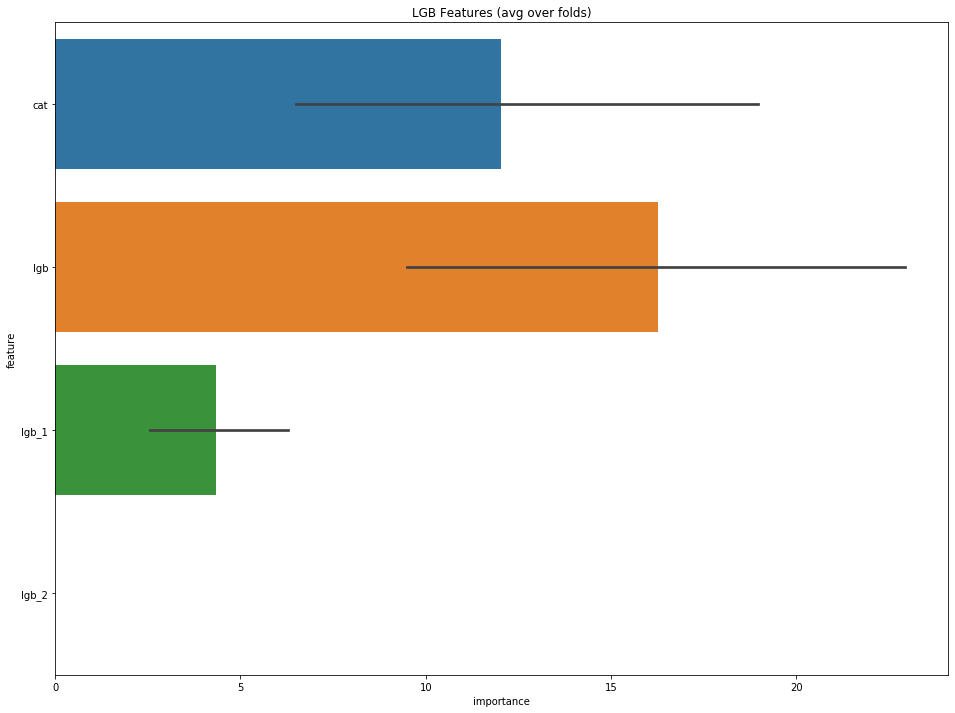

In [190]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:11:12 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.088899	valid_1's rmse: 0.0434688
[2000]	training's rmse: 0.0885232	valid_1's rmse: 0.0433832
Early stopping, best iteration is:
[1836]	training's rmse: 0.0885299	valid_1's rmse: 0.0433737
Fold 1 started at Tue Dec 17 12:11:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[513]	training's rmse: 0.0929704	valid_1's rmse: 0.0712152
Fold 2 started at Tue Dec 17 12:11:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108235	valid_1's rmse: 0.231746
Fold 3 started at Tue Dec 17 12:11:24 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0898827	valid_1's rmse: 0.0392401
[2000]	training's rmse: 0.0898313	valid_1's rmse: 0.0392067
[3000]	training's rmse: 0.0898114	valid_1's rmse: 0.039202

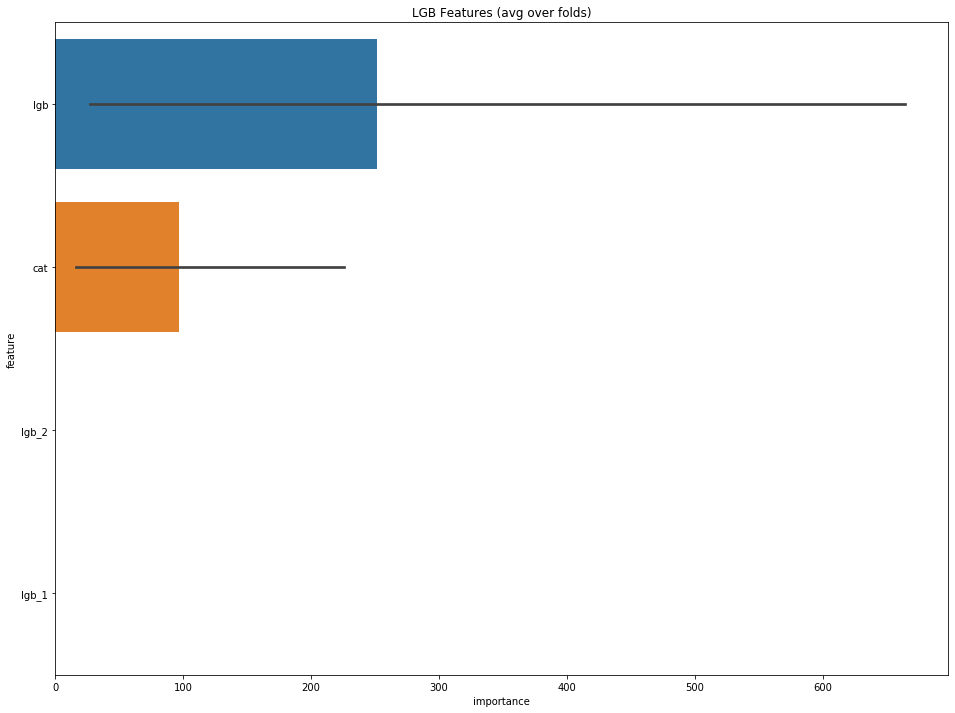

In [191]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [192]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:13:14 2019
Fold 1 started at Tue Dec 17 12:13:19 2019
Fold 2 started at Tue Dec 17 12:13:29 2019
Fold 3 started at Tue Dec 17 12:13:31 2019
Fold 4 started at Tue Dec 17 12:13:42 2019
Fold 5 started at Tue Dec 17 12:13:52 2019
Fold 6 started at Tue Dec 17 12:14:23 2019
Fold 7 started at Tue Dec 17 12:14:26 2019
Fold 8 started at Tue Dec 17 12:14:26 2019
Fold 9 started at Tue Dec 17 12:14:33 2019
CV mean score: 0.0722, std: 0.0552.


##### randomforest作为第二层融合模型

In [193]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:14:36 2019
Fold 1 started at Tue Dec 17 12:14:37 2019
Fold 2 started at Tue Dec 17 12:14:37 2019
Fold 3 started at Tue Dec 17 12:14:37 2019
Fold 4 started at Tue Dec 17 12:14:37 2019
Fold 5 started at Tue Dec 17 12:14:37 2019
Fold 6 started at Tue Dec 17 12:14:38 2019
Fold 7 started at Tue Dec 17 12:14:38 2019
Fold 8 started at Tue Dec 17 12:14:38 2019
Fold 9 started at Tue Dec 17 12:14:38 2019
CV mean score: 0.0795, std: 0.0557.


##### xgboost作为第二层融合模型

In [194]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:14:39 2019
[0]	train-rmse:0.207539	valid_data-rmse:0.154675
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[288]	train-rmse:0.03871	valid_data-rmse:0.05088

Fold 1 started at Tue Dec 17 12:14:39 2019
[0]	train-rmse:0.197635	valid_data-rmse:0.237751
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[273]	train-rmse:0.040545	valid_data-rmse:0.063586

Fold 2 started at Tue Dec 17 12:14:39 2019
[0]	train-rmse:0.200593	valid_data-rmse:0.2164
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[44]	train-rmse:0.137793	valid_data-rmse:0.206928

Fold 3 started at Tue Dec 1

##### svr 作为第二层融合模型

In [195]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:14:40 2019
Fold 1 started at Tue Dec 17 12:14:40 2019
Fold 2 started at Tue Dec 17 12:14:40 2019
Fold 3 started at Tue Dec 17 12:14:40 2019
Fold 4 started at Tue Dec 17 12:14:40 2019
Fold 5 started at Tue Dec 17 12:14:40 2019
Fold 6 started at Tue Dec 17 12:14:40 2019
Fold 7 started at Tue Dec 17 12:14:40 2019
Fold 8 started at Tue Dec 17 12:14:40 2019
Fold 9 started at Tue Dec 17 12:14:40 2019
CV mean score: 0.0791, std: 0.0511.


##### 岭回归做第二层融合模型

In [196]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:14:40 2019
Fold 1 started at Tue Dec 17 12:14:40 2019
Fold 2 started at Tue Dec 17 12:14:40 2019
Fold 3 started at Tue Dec 17 12:14:40 2019
Fold 4 started at Tue Dec 17 12:14:40 2019
Fold 5 started at Tue Dec 17 12:14:41 2019
Fold 6 started at Tue Dec 17 12:14:41 2019
Fold 7 started at Tue Dec 17 12:14:41 2019
Fold 8 started at Tue Dec 17 12:14:41 2019
Fold 9 started at Tue Dec 17 12:14:41 2019
CV mean score: 0.0674, std: 0.0541.


#### 留下lgb和rfr

In [197]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:14:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[434]	training's rmse: 0.0981356	valid_1's rmse: 0.0419639
Fold 1 started at Tue Dec 17 12:14:44 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[501]	training's rmse: 0.0950863	valid_1's rmse: 0.0720032
Fold 2 started at Tue Dec 17 12:14:46 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[3]	training's rmse: 0.10718	valid_1's rmse: 0.231043
Fold 3 started at Tue Dec 17 12:14:47 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[736]	training's rmse: 0.0971358	valid_1's rmse: 0.0584179
Fold 4 started at Tue Dec 17 12:14:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[551]	training's rmse: 0.0946112	valid_1's rmse: 0.068059
Fold 5

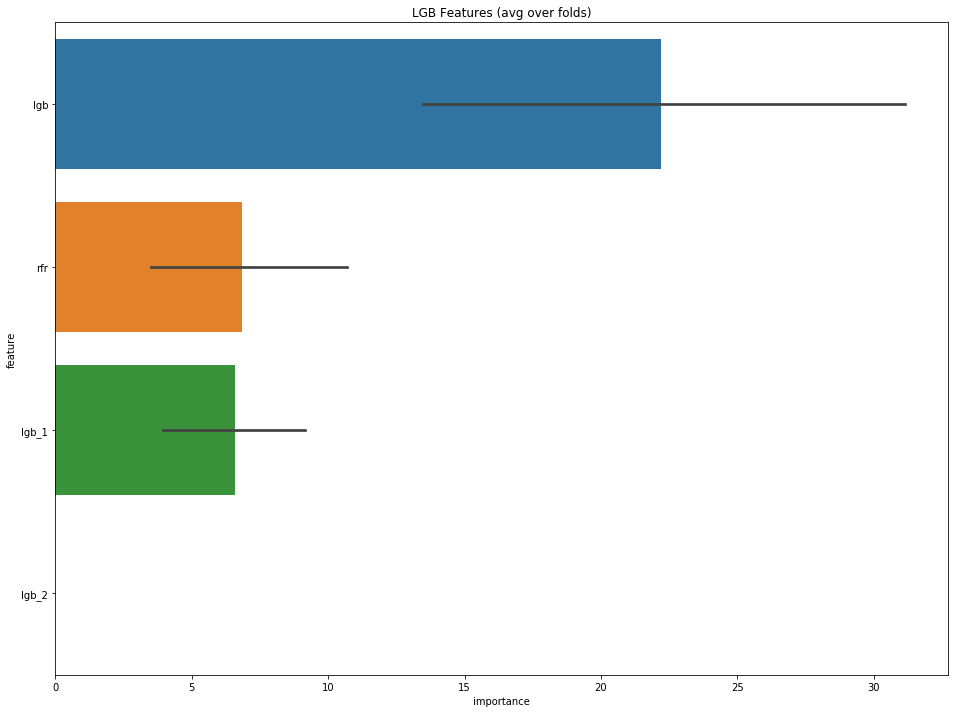

In [198]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:15:03 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0957803	valid_1's rmse: 0.0374167
[2000]	training's rmse: 0.0957783	valid_1's rmse: 0.0374099
Early stopping, best iteration is:
[2163]	training's rmse: 0.0957783	valid_1's rmse: 0.0374099
Fold 1 started at Tue Dec 17 12:15:14 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0917268	valid_1's rmse: 0.0685932
[2000]	training's rmse: 0.0906858	valid_1's rmse: 0.0677504
[3000]	training's rmse: 0.0901146	valid_1's rmse: 0.067491
[4000]	training's rmse: 0.0898215	valid_1's rmse: 0.0673492
[5000]	training's rmse: 0.089669	valid_1's rmse: 0.067277
[6000]	training's rmse: 0.0895861	valid_1's rmse: 0.0672438
[7000]	training's rmse: 0.0895453	valid_1's rmse: 0.0672219
Early stopping, best iteration is:
[7728]	training's rmse: 0.0895301	valid_1's rmse: 0.0672141
Fold 2 started at Tue Dec 17 12:15:51 2019
Training until val

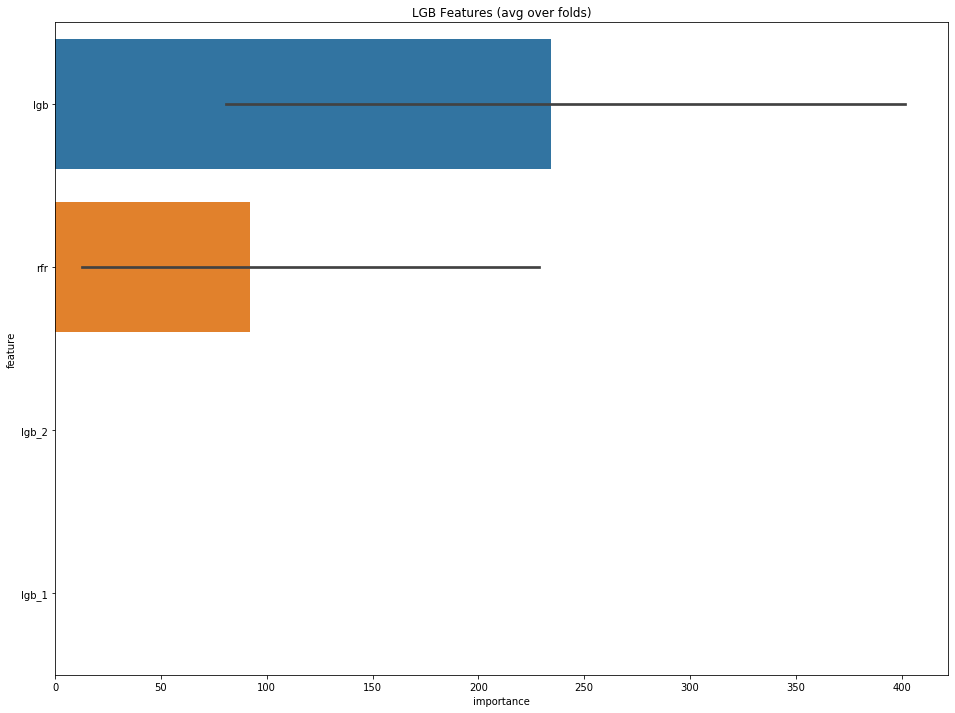

In [199]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [200]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:16:48 2019
Fold 1 started at Tue Dec 17 12:16:54 2019
Fold 2 started at Tue Dec 17 12:17:01 2019
Fold 3 started at Tue Dec 17 12:17:02 2019
Fold 4 started at Tue Dec 17 12:17:08 2019
Fold 5 started at Tue Dec 17 12:17:14 2019
Fold 6 started at Tue Dec 17 12:17:30 2019
Fold 7 started at Tue Dec 17 12:17:33 2019
Fold 8 started at Tue Dec 17 12:17:33 2019
Fold 9 started at Tue Dec 17 12:17:53 2019
CV mean score: 0.0787, std: 0.0546.


##### randomforest作为第二层融合模型

In [201]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:17:56 2019
Fold 1 started at Tue Dec 17 12:17:56 2019
Fold 2 started at Tue Dec 17 12:17:56 2019
Fold 3 started at Tue Dec 17 12:17:57 2019
Fold 4 started at Tue Dec 17 12:17:57 2019
Fold 5 started at Tue Dec 17 12:17:57 2019
Fold 6 started at Tue Dec 17 12:17:57 2019
Fold 7 started at Tue Dec 17 12:17:58 2019
Fold 8 started at Tue Dec 17 12:17:58 2019
Fold 9 started at Tue Dec 17 12:17:58 2019
CV mean score: 0.0840, std: 0.0544.


##### xgboost作为第二层融合模型

In [202]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:17:58 2019
[0]	train-rmse:0.207423	valid_data-rmse:0.154038
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[240]	train-rmse:0.047488	valid_data-rmse:0.050627

Fold 1 started at Tue Dec 17 12:17:58 2019
[0]	train-rmse:0.197676	valid_data-rmse:0.237872
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.019605	valid_data-rmse:0.060286
Stopping. Best iteration:
[323]	train-rmse:0.034845	valid_data-rmse:0.056463

Fold 2 started at Tue Dec 17 12:17:59 2019
[0]	train-rmse:0.200678	valid_data-rmse:0.21648
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[34]	train-rmse:0.150804

##### svr 作为第二层融合模型

In [203]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:18:00 2019
Fold 1 started at Tue Dec 17 12:18:00 2019
Fold 2 started at Tue Dec 17 12:18:00 2019
Fold 3 started at Tue Dec 17 12:18:00 2019
Fold 4 started at Tue Dec 17 12:18:00 2019
Fold 5 started at Tue Dec 17 12:18:00 2019
Fold 6 started at Tue Dec 17 12:18:00 2019
Fold 7 started at Tue Dec 17 12:18:00 2019
Fold 8 started at Tue Dec 17 12:18:00 2019
Fold 9 started at Tue Dec 17 12:18:00 2019
CV mean score: 0.0823, std: 0.0535.


##### 岭回归做第二层融合模型

In [204]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:18:00 2019
Fold 1 started at Tue Dec 17 12:18:00 2019
Fold 2 started at Tue Dec 17 12:18:00 2019
Fold 3 started at Tue Dec 17 12:18:00 2019
Fold 4 started at Tue Dec 17 12:18:00 2019
Fold 5 started at Tue Dec 17 12:18:01 2019
Fold 6 started at Tue Dec 17 12:18:01 2019
Fold 7 started at Tue Dec 17 12:18:01 2019
Fold 8 started at Tue Dec 17 12:18:01 2019
Fold 9 started at Tue Dec 17 12:18:01 2019
CV mean score: 0.0832, std: 0.0563.


#### 留下lgb和svr

In [205]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:18:01 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[595]	training's rmse: 0.0969769	valid_1's rmse: 0.0390361
Fold 1 started at Tue Dec 17 12:18:04 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0923262	valid_1's rmse: 0.0719864
Early stopping, best iteration is:
[989]	training's rmse: 0.0923757	valid_1's rmse: 0.0718041
Fold 2 started at Tue Dec 17 12:18:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[69]	training's rmse: 0.0832713	valid_1's rmse: 0.227271
Fold 3 started at Tue Dec 17 12:18:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[740]	training's rmse: 0.0970469	valid_1's rmse: 0.0544531
Fold 4 started at Tue Dec 17 12:18:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[

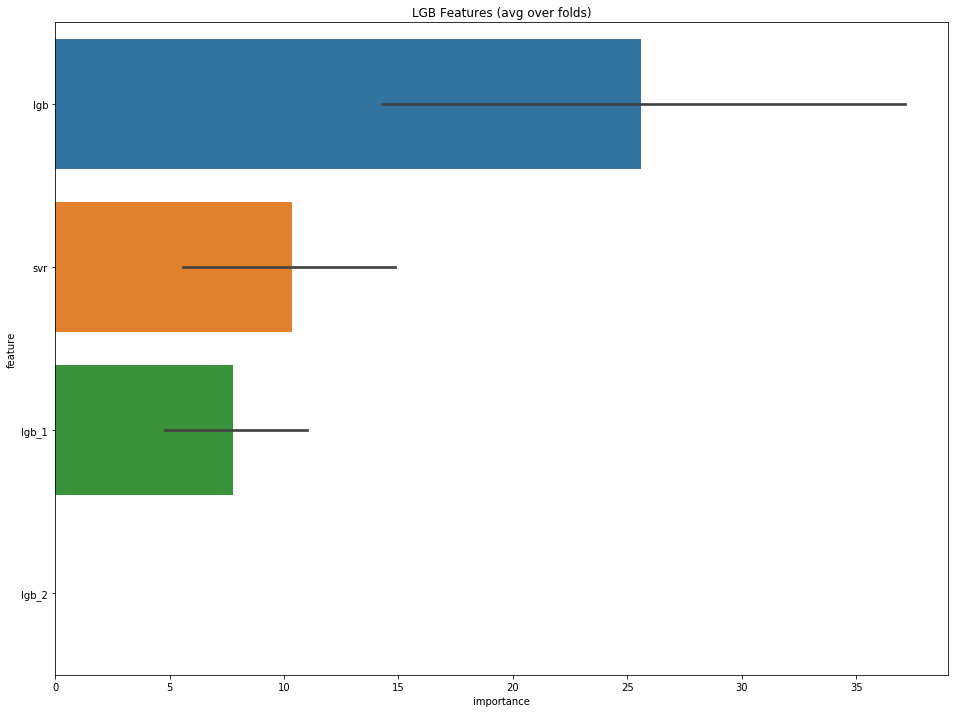

In [206]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:18:41 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.094887	valid_1's rmse: 0.0356218
Early stopping, best iteration is:
[810]	training's rmse: 0.0948914	valid_1's rmse: 0.0356201
Fold 1 started at Tue Dec 17 12:18:46 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0917389	valid_1's rmse: 0.0672873
[2000]	training's rmse: 0.0901632	valid_1's rmse: 0.0664598
[3000]	training's rmse: 0.0891456	valid_1's rmse: 0.066093
[4000]	training's rmse: 0.0884779	valid_1's rmse: 0.0658928
[5000]	training's rmse: 0.0880389	valid_1's rmse: 0.0657573
[6000]	training's rmse: 0.087719	valid_1's rmse: 0.0656844
[7000]	training's rmse: 0.087527	valid_1's rmse: 0.0656399
[8000]	training's rmse: 0.0875266	valid_1's rmse: 0.0656379
[9000]	training's rmse: 0.0875266	valid_1's rmse: 0.0656379
Early stopping, best iteration is:
[9084]	training's rmse: 0.0875266	valid_1's rmse: 0.0656379
Fol

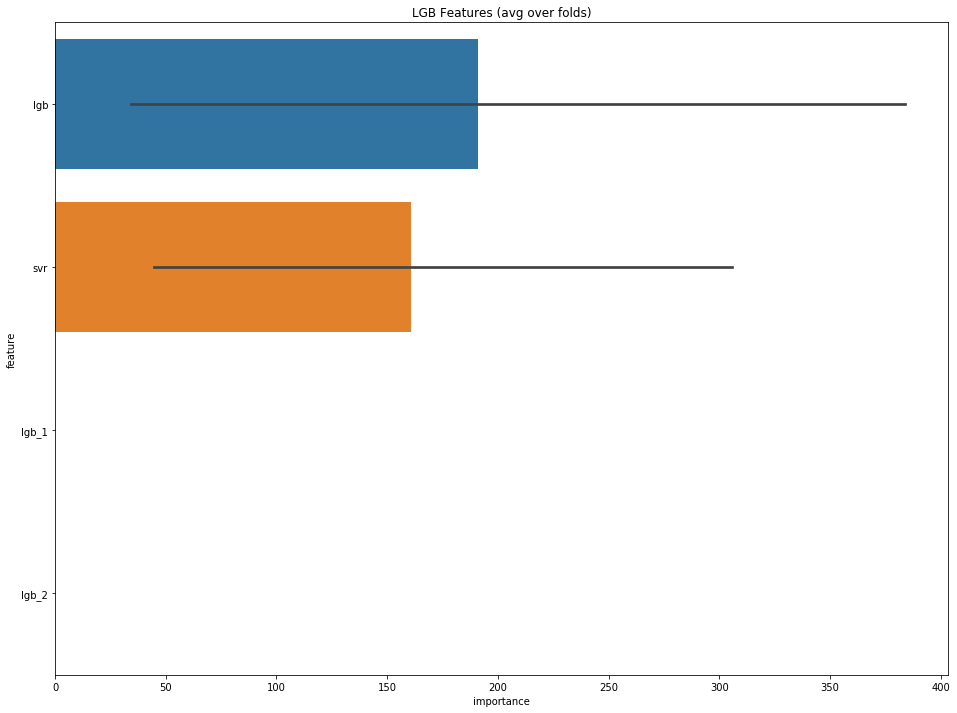

In [207]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [208]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:20:23 2019
Fold 1 started at Tue Dec 17 12:20:27 2019
Fold 2 started at Tue Dec 17 12:20:41 2019
Fold 3 started at Tue Dec 17 12:20:42 2019
Fold 4 started at Tue Dec 17 12:20:56 2019
Fold 5 started at Tue Dec 17 12:21:04 2019
Fold 6 started at Tue Dec 17 12:21:14 2019
Fold 7 started at Tue Dec 17 12:21:17 2019
Fold 8 started at Tue Dec 17 12:21:17 2019
Fold 9 started at Tue Dec 17 12:21:25 2019
CV mean score: 0.0740, std: 0.0558.


##### randomforest作为第二层融合模型

In [209]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:21:30 2019
Fold 1 started at Tue Dec 17 12:21:30 2019
Fold 2 started at Tue Dec 17 12:21:31 2019
Fold 3 started at Tue Dec 17 12:21:31 2019
Fold 4 started at Tue Dec 17 12:21:31 2019
Fold 5 started at Tue Dec 17 12:21:31 2019
Fold 6 started at Tue Dec 17 12:21:32 2019
Fold 7 started at Tue Dec 17 12:21:32 2019
Fold 8 started at Tue Dec 17 12:21:32 2019
Fold 9 started at Tue Dec 17 12:21:32 2019
CV mean score: 0.0803, std: 0.0552.


##### xgboost作为第二层融合模型

In [210]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:21:33 2019
[0]	train-rmse:0.20741	valid_data-rmse:0.154128
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[213]	train-rmse:0.052743	valid_data-rmse:0.047553

Fold 1 started at Tue Dec 17 12:21:33 2019
[0]	train-rmse:0.197752	valid_data-rmse:0.23815
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.01894	valid_data-rmse:0.059614
Stopping. Best iteration:
[476]	train-rmse:0.020321	valid_data-rmse:0.059302

Fold 2 started at Tue Dec 17 12:21:33 2019
[0]	train-rmse:0.200627	valid_data-rmse:0.216476
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[34]	train-rmse:0.150255	v

##### svr 作为第二层融合模型

In [211]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:21:34 2019
Fold 1 started at Tue Dec 17 12:21:34 2019
Fold 2 started at Tue Dec 17 12:21:34 2019
Fold 3 started at Tue Dec 17 12:21:34 2019
Fold 4 started at Tue Dec 17 12:21:34 2019
Fold 5 started at Tue Dec 17 12:21:34 2019
Fold 6 started at Tue Dec 17 12:21:34 2019
Fold 7 started at Tue Dec 17 12:21:34 2019
Fold 8 started at Tue Dec 17 12:21:34 2019
Fold 9 started at Tue Dec 17 12:21:34 2019
CV mean score: 0.0836, std: 0.0507.


##### 岭回归做第二层融合模型

In [212]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:21:34 2019
Fold 1 started at Tue Dec 17 12:21:34 2019
Fold 2 started at Tue Dec 17 12:21:34 2019
Fold 3 started at Tue Dec 17 12:21:34 2019
Fold 4 started at Tue Dec 17 12:21:34 2019
Fold 5 started at Tue Dec 17 12:21:34 2019
Fold 6 started at Tue Dec 17 12:21:34 2019
Fold 7 started at Tue Dec 17 12:21:35 2019
Fold 8 started at Tue Dec 17 12:21:35 2019
Fold 9 started at Tue Dec 17 12:21:35 2019
CV mean score: 0.0818, std: 0.0575.


#### 留下lgb和xgb

In [213]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2,oof_xgb]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2','xgb'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:21:35 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[339]	training's rmse: 0.091295	valid_1's rmse: 0.0368144
Fold 1 started at Tue Dec 17 12:21:36 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[429]	training's rmse: 0.0870118	valid_1's rmse: 0.0714494
Fold 2 started at Tue Dec 17 12:21:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[455]	training's rmse: 0.056442	valid_1's rmse: 0.210163
Fold 3 started at Tue Dec 17 12:21:39 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[493]	training's rmse: 0.0918222	valid_1's rmse: 0.0349432
Fold 4 started at Tue Dec 17 12:21:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[344]	training's rmse: 0.0878784	valid_1's rmse: 0.0650467
Fol

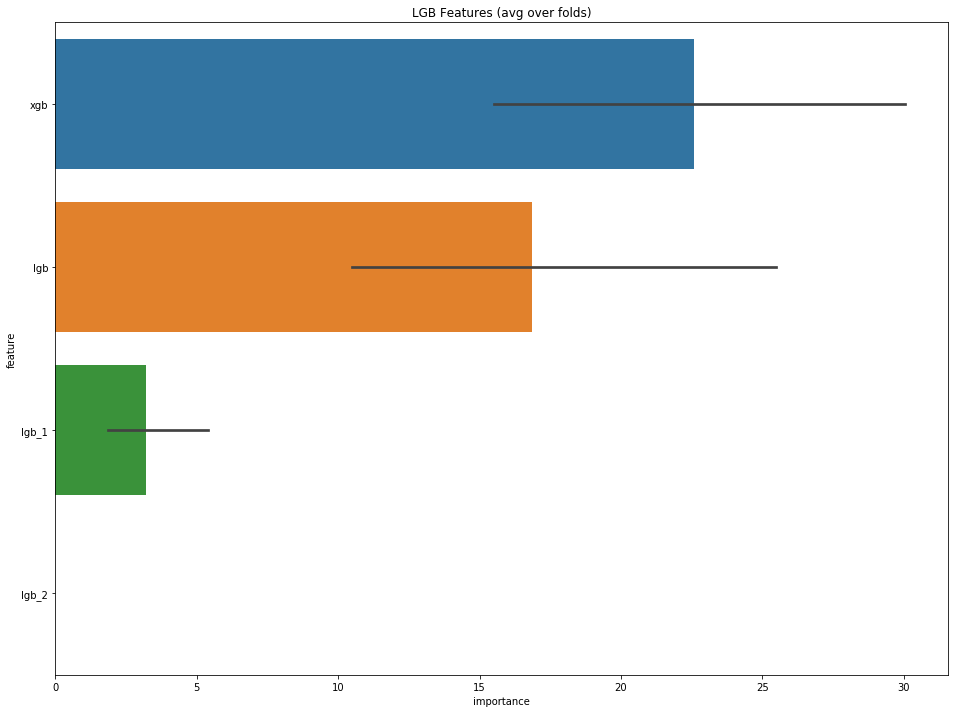

In [214]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:21:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[358]	training's rmse: 0.0895706	valid_1's rmse: 0.0353015
Fold 1 started at Tue Dec 17 12:21:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[392]	training's rmse: 0.0852466	valid_1's rmse: 0.0711601
Fold 2 started at Tue Dec 17 12:21:53 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0551851	valid_1's rmse: 0.207907
Early stopping, best iteration is:
[1032]	training's rmse: 0.0551822	valid_1's rmse: 0.207903
Fold 3 started at Tue Dec 17 12:21:56 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0900644	valid_1's rmse: 0.027774
Early stopping, best iteration is:
[873]	training's rmse: 0.0900697	valid_1's rmse: 0.0277691
Fold 4 started at Tue Dec 17 12:21:59 2019
Training until validation scores don't 

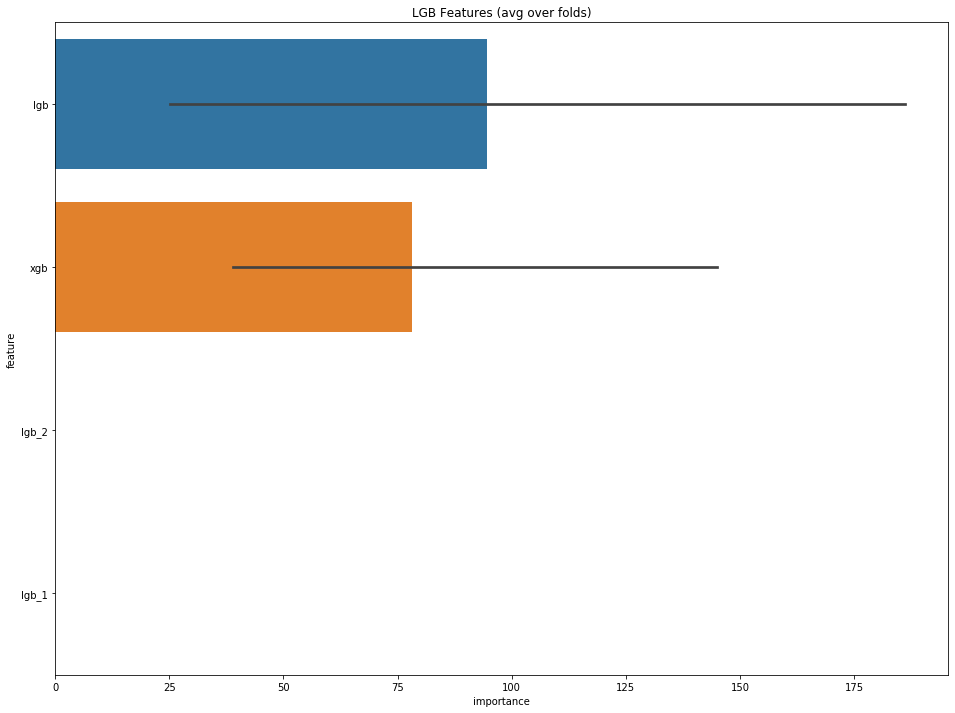

In [215]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [216]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:22:43 2019
Fold 1 started at Tue Dec 17 12:22:46 2019
Fold 2 started at Tue Dec 17 12:22:56 2019
Fold 3 started at Tue Dec 17 12:23:05 2019
Fold 4 started at Tue Dec 17 12:23:15 2019
Fold 5 started at Tue Dec 17 12:23:21 2019
Fold 6 started at Tue Dec 17 12:23:30 2019
Fold 7 started at Tue Dec 17 12:23:33 2019
Fold 8 started at Tue Dec 17 12:23:34 2019
Fold 9 started at Tue Dec 17 12:23:41 2019
CV mean score: 0.0681, std: 0.0522.


##### randomforest作为第二层融合模型

In [217]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:23:45 2019
Fold 1 started at Tue Dec 17 12:23:45 2019
Fold 2 started at Tue Dec 17 12:23:46 2019
Fold 3 started at Tue Dec 17 12:23:46 2019
Fold 4 started at Tue Dec 17 12:23:46 2019
Fold 5 started at Tue Dec 17 12:23:46 2019
Fold 6 started at Tue Dec 17 12:23:47 2019
Fold 7 started at Tue Dec 17 12:23:47 2019
Fold 8 started at Tue Dec 17 12:23:47 2019
Fold 9 started at Tue Dec 17 12:23:47 2019
CV mean score: 0.0756, std: 0.0514.


##### xgboost作为第二层融合模型

In [218]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:23:48 2019
[0]	train-rmse:0.207372	valid_data-rmse:0.153855
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[185]	train-rmse:0.060431	valid_data-rmse:0.044466

Fold 1 started at Tue Dec 17 12:23:48 2019
[0]	train-rmse:0.197606	valid_data-rmse:0.237964
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[285]	train-rmse:0.038075	valid_data-rmse:0.062903

Fold 2 started at Tue Dec 17 12:23:48 2019
[0]	train-rmse:0.200596	valid_data-rmse:0.216483
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[141]	train-rmse:0.065542	valid_data-rmse:0.207987

Fold 3 started at Tue 

##### svr 作为第二层融合模型

In [219]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:23:49 2019
Fold 1 started at Tue Dec 17 12:23:49 2019
Fold 2 started at Tue Dec 17 12:23:49 2019
Fold 3 started at Tue Dec 17 12:23:49 2019
Fold 4 started at Tue Dec 17 12:23:49 2019
Fold 5 started at Tue Dec 17 12:23:49 2019
Fold 6 started at Tue Dec 17 12:23:49 2019
Fold 7 started at Tue Dec 17 12:23:49 2019
Fold 8 started at Tue Dec 17 12:23:49 2019
Fold 9 started at Tue Dec 17 12:23:49 2019
CV mean score: 0.0795, std: 0.0491.


##### 岭回归做第二层融合模型

In [220]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:23:49 2019
Fold 1 started at Tue Dec 17 12:23:49 2019
Fold 2 started at Tue Dec 17 12:23:49 2019
Fold 3 started at Tue Dec 17 12:23:49 2019
Fold 4 started at Tue Dec 17 12:23:49 2019
Fold 5 started at Tue Dec 17 12:23:49 2019
Fold 6 started at Tue Dec 17 12:23:49 2019
Fold 7 started at Tue Dec 17 12:23:49 2019
Fold 8 started at Tue Dec 17 12:23:49 2019
Fold 9 started at Tue Dec 17 12:23:50 2019
CV mean score: 0.0654, std: 0.0516.


#### 只留下cat

In [221]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_cat]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['cat'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:23:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[223]	training's rmse: 0.103814	valid_1's rmse: 0.0484826
Fold 1 started at Tue Dec 17 12:23:51 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[319]	training's rmse: 0.104991	valid_1's rmse: 0.0853019
Fold 2 started at Tue Dec 17 12:23:53 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108249	valid_1's rmse: 0.231752
Fold 3 started at Tue Dec 17 12:23:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[299]	training's rmse: 0.0963104	valid_1's rmse: 0.0473054
Fold 4 started at Tue Dec 17 12:23:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[280]	training's rmse: 0.105571	valid_1's rmse: 0.0773707
Fold 5 

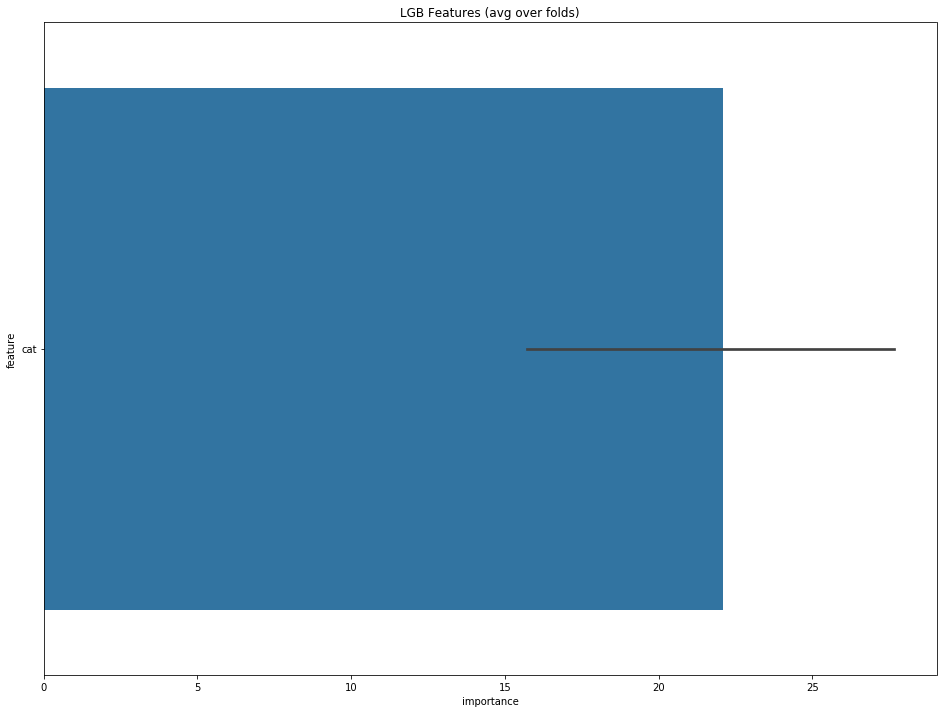

In [222]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:24:05 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0979675	valid_1's rmse: 0.048028
[2000]	training's rmse: 0.0979661	valid_1's rmse: 0.0480217
Early stopping, best iteration is:
[2524]	training's rmse: 0.0979661	valid_1's rmse: 0.0480217
Fold 1 started at Tue Dec 17 12:24:14 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.103927	valid_1's rmse: 0.084028
[2000]	training's rmse: 0.103926	valid_1's rmse: 0.0840263
Early stopping, best iteration is:
[2412]	training's rmse: 0.103926	valid_1's rmse: 0.0840263
Fold 2 started at Tue Dec 17 12:24:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108235	valid_1's rmse: 0.231746
Fold 3 started at Tue Dec 17 12:24:23 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.094365	valid_1's rmse: 0.0449519
[2

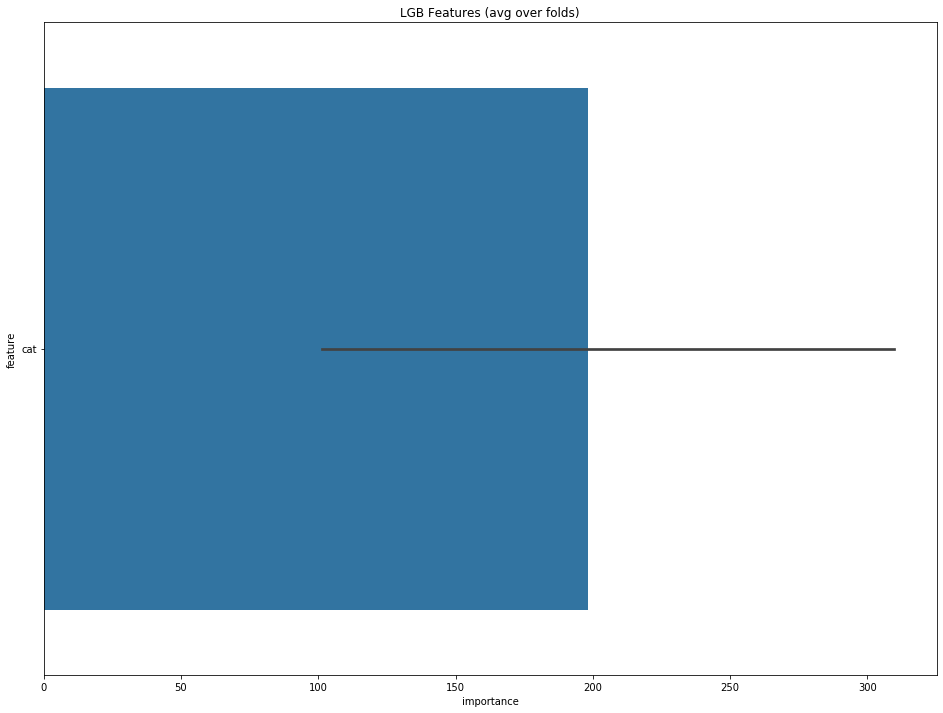

In [223]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [224]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:25:21 2019
Fold 1 started at Tue Dec 17 12:25:24 2019
Fold 2 started at Tue Dec 17 12:25:28 2019
Fold 3 started at Tue Dec 17 12:25:28 2019
Fold 4 started at Tue Dec 17 12:25:33 2019
Fold 5 started at Tue Dec 17 12:25:52 2019
Fold 6 started at Tue Dec 17 12:25:56 2019
Fold 7 started at Tue Dec 17 12:25:58 2019
Fold 8 started at Tue Dec 17 12:26:03 2019
Fold 9 started at Tue Dec 17 12:26:11 2019
CV mean score: 0.0745, std: 0.0542.


##### randomforest作为第二层融合模型

In [225]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:26:12 2019
Fold 1 started at Tue Dec 17 12:26:12 2019
Fold 2 started at Tue Dec 17 12:26:13 2019
Fold 3 started at Tue Dec 17 12:26:13 2019
Fold 4 started at Tue Dec 17 12:26:13 2019
Fold 5 started at Tue Dec 17 12:26:13 2019
Fold 6 started at Tue Dec 17 12:26:14 2019
Fold 7 started at Tue Dec 17 12:26:14 2019
Fold 8 started at Tue Dec 17 12:26:14 2019
Fold 9 started at Tue Dec 17 12:26:14 2019
CV mean score: 0.0822, std: 0.0573.


##### xgboost作为第二层融合模型

In [226]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:26:15 2019
[0]	train-rmse:0.207551	valid_data-rmse:0.154559
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[245]	train-rmse:0.051824	valid_data-rmse:0.053997

Fold 1 started at Tue Dec 17 12:26:15 2019
[0]	train-rmse:0.197635	valid_data-rmse:0.237751
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.023245	valid_data-rmse:0.049388
Stopping. Best iteration:
[350]	train-rmse:0.035055	valid_data-rmse:0.047884

Fold 2 started at Tue Dec 17 12:26:15 2019
[0]	train-rmse:0.200611	valid_data-rmse:0.21615
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[35]	train-rmse:0.148494

##### svr 作为第二层融合模型

In [227]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:26:16 2019
Fold 1 started at Tue Dec 17 12:26:16 2019
Fold 2 started at Tue Dec 17 12:26:16 2019
Fold 3 started at Tue Dec 17 12:26:16 2019
Fold 4 started at Tue Dec 17 12:26:16 2019
Fold 5 started at Tue Dec 17 12:26:16 2019
Fold 6 started at Tue Dec 17 12:26:16 2019
Fold 7 started at Tue Dec 17 12:26:16 2019
Fold 8 started at Tue Dec 17 12:26:16 2019
Fold 9 started at Tue Dec 17 12:26:16 2019
CV mean score: 0.0759, std: 0.0553.


##### 岭回归做第二层融合模型

In [228]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:26:16 2019
Fold 1 started at Tue Dec 17 12:26:16 2019
Fold 2 started at Tue Dec 17 12:26:16 2019
Fold 3 started at Tue Dec 17 12:26:17 2019
Fold 4 started at Tue Dec 17 12:26:17 2019
Fold 5 started at Tue Dec 17 12:26:17 2019
Fold 6 started at Tue Dec 17 12:26:17 2019
Fold 7 started at Tue Dec 17 12:26:17 2019
Fold 8 started at Tue Dec 17 12:26:17 2019
Fold 9 started at Tue Dec 17 12:26:17 2019
CV mean score: 0.0688, std: 0.0552.


#### 只留下rfr

In [229]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_rfr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['rfr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:26:17 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[223]	training's rmse: 0.109954	valid_1's rmse: 0.0475882
Fold 1 started at Tue Dec 17 12:26:19 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[229]	training's rmse: 0.108516	valid_1's rmse: 0.089515
Fold 2 started at Tue Dec 17 12:26:21 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108303	valid_1's rmse: 0.231552
Fold 3 started at Tue Dec 17 12:26:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[262]	training's rmse: 0.106825	valid_1's rmse: 0.0667493
Fold 4 started at Tue Dec 17 12:26:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[280]	training's rmse: 0.107248	valid_1's rmse: 0.0885143
Fold 5 st

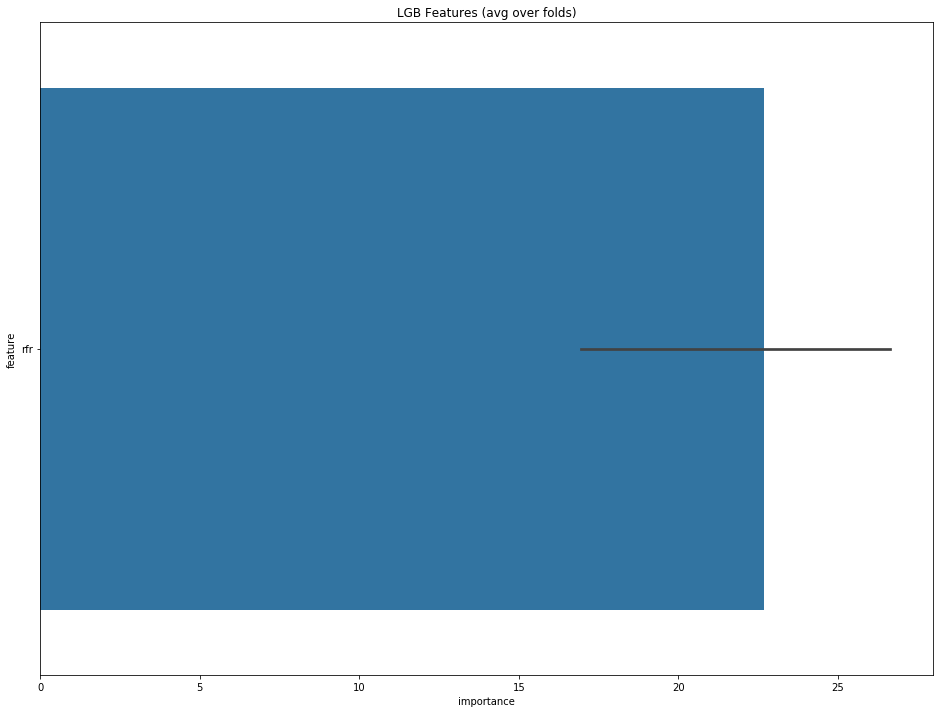

In [230]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:26:36 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.107841	valid_1's rmse: 0.0394253
[2000]	training's rmse: 0.107839	valid_1's rmse: 0.0394164
Early stopping, best iteration is:
[2493]	training's rmse: 0.107839	valid_1's rmse: 0.0394164
Fold 1 started at Tue Dec 17 12:26:47 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.106393	valid_1's rmse: 0.0805847
[2000]	training's rmse: 0.106392	valid_1's rmse: 0.0805718
[3000]	training's rmse: 0.106392	valid_1's rmse: 0.0805718
[4000]	training's rmse: 0.106392	valid_1's rmse: 0.0805718
[5000]	training's rmse: 0.106392	valid_1's rmse: 0.0805718
Early stopping, best iteration is:
[5479]	training's rmse: 0.106392	valid_1's rmse: 0.0805718
Fold 2 started at Tue Dec 17 12:27:05 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108242	valid_1's rmse: 

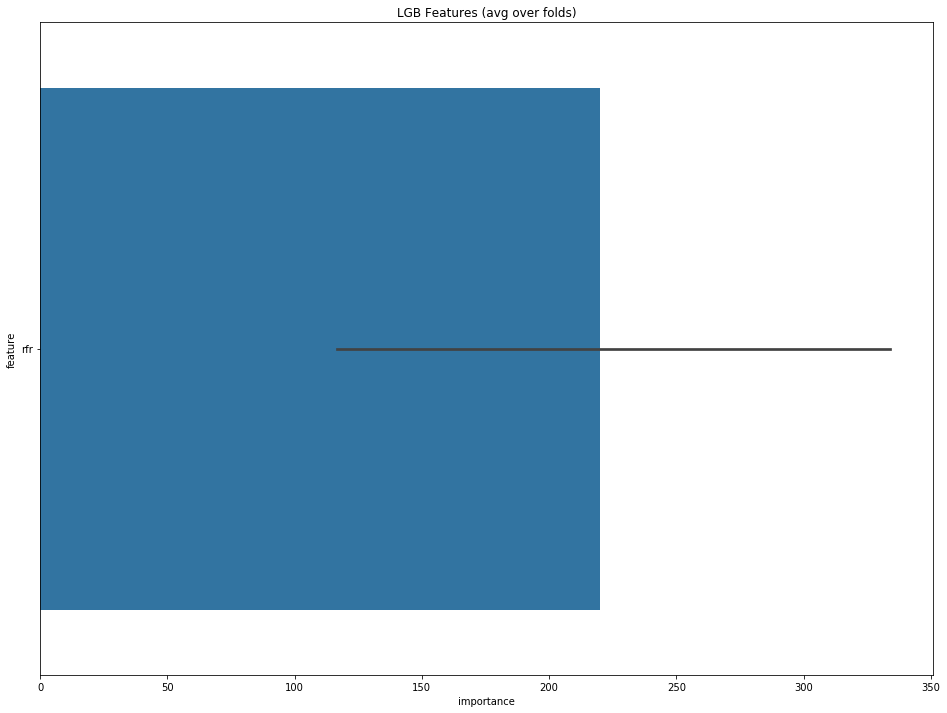

In [231]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [232]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:27:50 2019
Fold 1 started at Tue Dec 17 12:27:53 2019
Fold 2 started at Tue Dec 17 12:28:00 2019
Fold 3 started at Tue Dec 17 12:28:00 2019
Fold 4 started at Tue Dec 17 12:28:03 2019
Fold 5 started at Tue Dec 17 12:28:04 2019
Fold 6 started at Tue Dec 17 12:28:07 2019
Fold 7 started at Tue Dec 17 12:28:09 2019
Fold 8 started at Tue Dec 17 12:28:11 2019
Fold 9 started at Tue Dec 17 12:28:17 2019
CV mean score: 0.0840, std: 0.0537.


##### randomforest作为第二层融合模型

In [233]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:28:19 2019
Fold 1 started at Tue Dec 17 12:28:19 2019
Fold 2 started at Tue Dec 17 12:28:20 2019
Fold 3 started at Tue Dec 17 12:28:20 2019
Fold 4 started at Tue Dec 17 12:28:20 2019
Fold 5 started at Tue Dec 17 12:28:20 2019
Fold 6 started at Tue Dec 17 12:28:20 2019
Fold 7 started at Tue Dec 17 12:28:21 2019
Fold 8 started at Tue Dec 17 12:28:21 2019
Fold 9 started at Tue Dec 17 12:28:21 2019
CV mean score: 0.0899, std: 0.0655.


##### xgboost作为第二层融合模型

In [234]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:28:21 2019
[0]	train-rmse:0.2077	valid_data-rmse:0.154082
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[282]	train-rmse:0.049893	valid_data-rmse:0.047077

Fold 1 started at Tue Dec 17 12:28:22 2019
[0]	train-rmse:0.197676	valid_data-rmse:0.237872
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.026165	valid_data-rmse:0.061972
Stopping. Best iteration:
[520]	train-rmse:0.024982	valid_data-rmse:0.061769

Fold 2 started at Tue Dec 17 12:28:22 2019
[0]	train-rmse:0.200687	valid_data-rmse:0.216331
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[22]	train-rmse:0.166501	

##### svr 作为第二层融合模型

In [235]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:28:22 2019
Fold 1 started at Tue Dec 17 12:28:22 2019
Fold 2 started at Tue Dec 17 12:28:22 2019
Fold 3 started at Tue Dec 17 12:28:22 2019
Fold 4 started at Tue Dec 17 12:28:22 2019
Fold 5 started at Tue Dec 17 12:28:22 2019
Fold 6 started at Tue Dec 17 12:28:22 2019
Fold 7 started at Tue Dec 17 12:28:22 2019
Fold 8 started at Tue Dec 17 12:28:22 2019
Fold 9 started at Tue Dec 17 12:28:22 2019
CV mean score: 0.0864, std: 0.0601.


##### 岭回归做第二层融合模型

In [236]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:28:22 2019
Fold 1 started at Tue Dec 17 12:28:23 2019
Fold 2 started at Tue Dec 17 12:28:23 2019
Fold 3 started at Tue Dec 17 12:28:23 2019
Fold 4 started at Tue Dec 17 12:28:23 2019
Fold 5 started at Tue Dec 17 12:28:23 2019
Fold 6 started at Tue Dec 17 12:28:23 2019
Fold 7 started at Tue Dec 17 12:28:23 2019
Fold 8 started at Tue Dec 17 12:28:23 2019
Fold 9 started at Tue Dec 17 12:28:24 2019
CV mean score: 0.0865, std: 0.0628.


#### 只留下svr

In [237]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_svr]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['svr'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:28:24 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[269]	training's rmse: 0.112014	valid_1's rmse: 0.0582055
Fold 1 started at Tue Dec 17 12:28:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[291]	training's rmse: 0.112367	valid_1's rmse: 0.0899766
Fold 2 started at Tue Dec 17 12:28:27 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108427	valid_1's rmse: 0.231539
Fold 3 started at Tue Dec 17 12:28:28 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[218]	training's rmse: 0.111616	valid_1's rmse: 0.0647503
Fold 4 started at Tue Dec 17 12:28:29 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[280]	training's rmse: 0.109565	valid_1's rmse: 0.107704
Fold 5 st

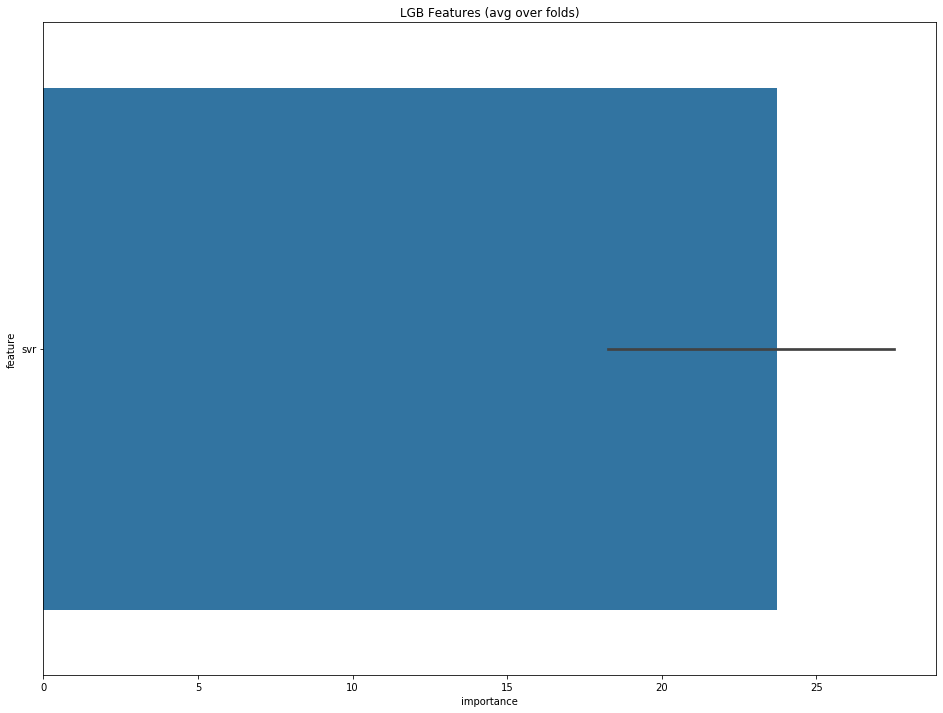

In [238]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:28:38 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.110269	valid_1's rmse: 0.0535619
[2000]	training's rmse: 0.110268	valid_1's rmse: 0.0535593
Early stopping, best iteration is:
[2292]	training's rmse: 0.110268	valid_1's rmse: 0.0535593
Fold 1 started at Tue Dec 17 12:28:46 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.111628	valid_1's rmse: 0.0850426
[2000]	training's rmse: 0.111627	valid_1's rmse: 0.0850349
Early stopping, best iteration is:
[2148]	training's rmse: 0.111627	valid_1's rmse: 0.0850349
Fold 2 started at Tue Dec 17 12:28:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1]	training's rmse: 0.108352	valid_1's rmse: 0.231493
Fold 3 started at Tue Dec 17 12:28:55 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.107619	valid_1's rmse: 0.0481965
[20

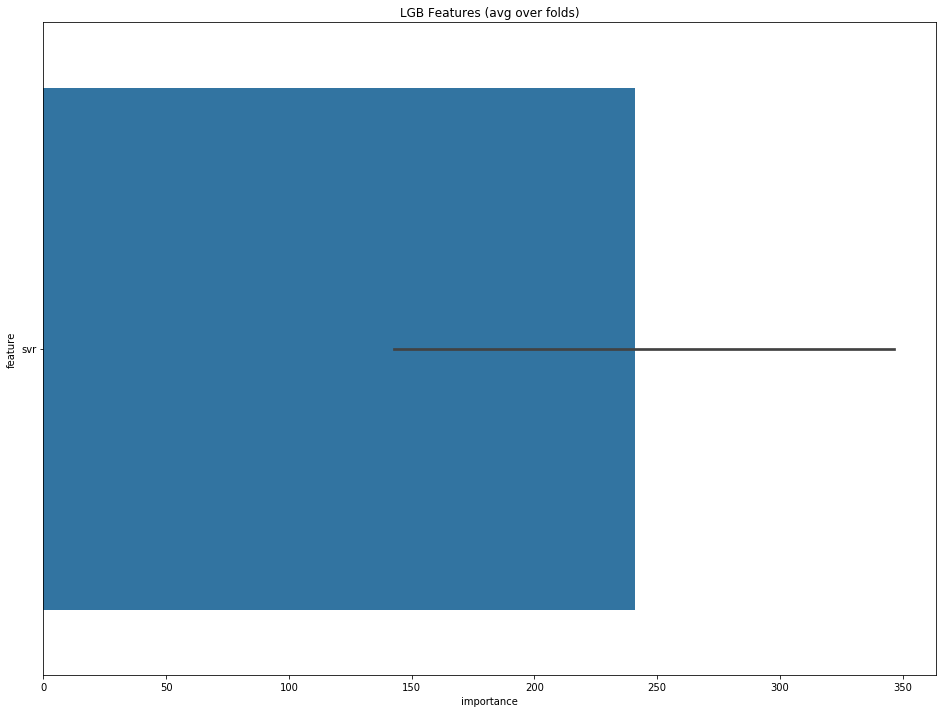

In [239]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [240]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:29:51 2019
Fold 1 started at Tue Dec 17 12:29:54 2019
Fold 2 started at Tue Dec 17 12:30:11 2019
Fold 3 started at Tue Dec 17 12:30:11 2019
Fold 4 started at Tue Dec 17 12:30:14 2019
Fold 5 started at Tue Dec 17 12:30:19 2019
Fold 6 started at Tue Dec 17 12:30:29 2019
Fold 7 started at Tue Dec 17 12:30:31 2019
Fold 8 started at Tue Dec 17 12:30:34 2019
Fold 9 started at Tue Dec 17 12:30:44 2019
CV mean score: 0.0788, std: 0.0529.


##### randomforest作为第二层融合模型

In [241]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:30:46 2019
Fold 1 started at Tue Dec 17 12:30:46 2019
Fold 2 started at Tue Dec 17 12:30:46 2019
Fold 3 started at Tue Dec 17 12:30:46 2019
Fold 4 started at Tue Dec 17 12:30:47 2019
Fold 5 started at Tue Dec 17 12:30:47 2019
Fold 6 started at Tue Dec 17 12:30:47 2019
Fold 7 started at Tue Dec 17 12:30:47 2019
Fold 8 started at Tue Dec 17 12:30:48 2019
Fold 9 started at Tue Dec 17 12:30:48 2019
CV mean score: 0.0871, std: 0.0662.


##### xgboost作为第二层融合模型

In [242]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:30:48 2019
[0]	train-rmse:0.207711	valid_data-rmse:0.154178
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[247]	train-rmse:0.053025	valid_data-rmse:0.060327

Fold 1 started at Tue Dec 17 12:30:48 2019
[0]	train-rmse:0.197767	valid_data-rmse:0.238189
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.025538	valid_data-rmse:0.065565
Stopping. Best iteration:
[314]	train-rmse:0.042867	valid_data-rmse:0.061678

Fold 2 started at Tue Dec 17 12:30:48 2019
[0]	train-rmse:0.200681	valid_data-rmse:0.216384
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[24]	train-rmse:0.16391

##### svr 作为第二层融合模型

In [243]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:30:49 2019
Fold 1 started at Tue Dec 17 12:30:49 2019
Fold 2 started at Tue Dec 17 12:30:49 2019
Fold 3 started at Tue Dec 17 12:30:49 2019
Fold 4 started at Tue Dec 17 12:30:49 2019
Fold 5 started at Tue Dec 17 12:30:49 2019
Fold 6 started at Tue Dec 17 12:30:49 2019
Fold 7 started at Tue Dec 17 12:30:49 2019
Fold 8 started at Tue Dec 17 12:30:49 2019
Fold 9 started at Tue Dec 17 12:30:49 2019
CV mean score: 0.0913, std: 0.0562.


##### 岭回归做第二层融合模型

In [244]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:30:49 2019
Fold 1 started at Tue Dec 17 12:30:49 2019
Fold 2 started at Tue Dec 17 12:30:49 2019
Fold 3 started at Tue Dec 17 12:30:49 2019
Fold 4 started at Tue Dec 17 12:30:49 2019
Fold 5 started at Tue Dec 17 12:30:49 2019
Fold 6 started at Tue Dec 17 12:30:49 2019
Fold 7 started at Tue Dec 17 12:30:50 2019
Fold 8 started at Tue Dec 17 12:30:50 2019
Fold 9 started at Tue Dec 17 12:30:50 2019
CV mean score: 0.0862, std: 0.0638.


#### 只留下xgb

In [245]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_xgb]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['xgb'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:30:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[293]	training's rmse: 0.0935044	valid_1's rmse: 0.0369654
Fold 1 started at Tue Dec 17 12:30:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[327]	training's rmse: 0.0888403	valid_1's rmse: 0.0821722
Fold 2 started at Tue Dec 17 12:30:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[320]	training's rmse: 0.060478	valid_1's rmse: 0.207729
Fold 3 started at Tue Dec 17 12:30:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[262]	training's rmse: 0.0939106	valid_1's rmse: 0.0339938
Fold 4 started at Tue Dec 17 12:30:57 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[267]	training's rmse: 0.0910584	valid_1's rmse: 0.0705376
Fo

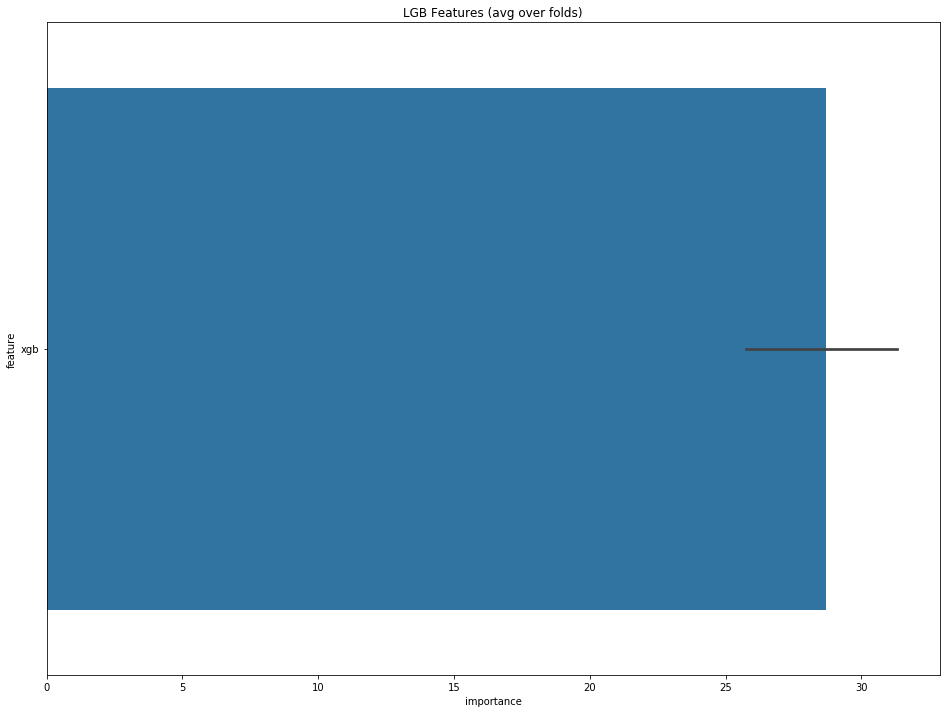

In [246]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:31:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[348]	training's rmse: 0.0928522	valid_1's rmse: 0.0361803
Fold 1 started at Tue Dec 17 12:31:10 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.08756	valid_1's rmse: 0.082065
[2000]	training's rmse: 0.0875587	valid_1's rmse: 0.0820642
Early stopping, best iteration is:
[2600]	training's rmse: 0.0875587	valid_1's rmse: 0.0820642
Fold 2 started at Tue Dec 17 12:31:20 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0590895	valid_1's rmse: 0.206795
[2000]	training's rmse: 0.0590873	valid_1's rmse: 0.206794
Early stopping, best iteration is:
[2404]	training's rmse: 0.0590873	valid_1's rmse: 0.206794
Fold 3 started at Tue Dec 17 12:31:32 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0927876	valid_1's rmse: 0.026575

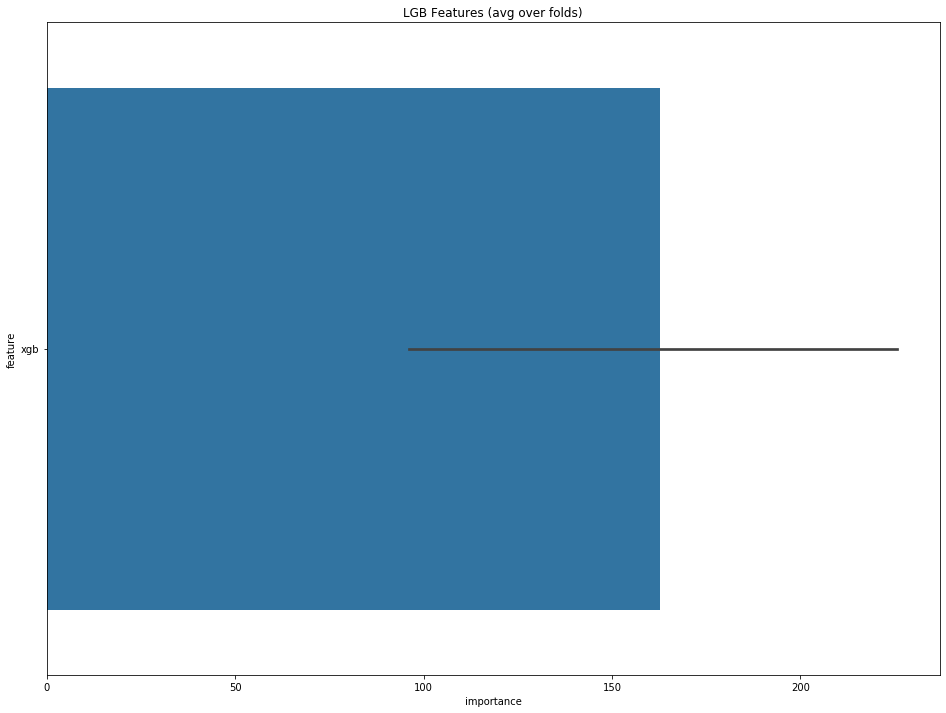

In [247]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [248]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:32:14 2019
Fold 1 started at Tue Dec 17 12:32:16 2019
Fold 2 started at Tue Dec 17 12:32:20 2019
Fold 3 started at Tue Dec 17 12:32:23 2019
Fold 4 started at Tue Dec 17 12:32:27 2019
Fold 5 started at Tue Dec 17 12:32:29 2019
Fold 6 started at Tue Dec 17 12:32:36 2019
Fold 7 started at Tue Dec 17 12:32:37 2019
Fold 8 started at Tue Dec 17 12:32:39 2019
Fold 9 started at Tue Dec 17 12:32:42 2019
CV mean score: 0.0686, std: 0.0512.


##### randomforest作为第二层融合模型

In [249]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:32:47 2019
Fold 1 started at Tue Dec 17 12:32:47 2019
Fold 2 started at Tue Dec 17 12:32:48 2019
Fold 3 started at Tue Dec 17 12:32:48 2019
Fold 4 started at Tue Dec 17 12:32:48 2019
Fold 5 started at Tue Dec 17 12:32:48 2019
Fold 6 started at Tue Dec 17 12:32:49 2019
Fold 7 started at Tue Dec 17 12:32:49 2019
Fold 8 started at Tue Dec 17 12:32:49 2019
Fold 9 started at Tue Dec 17 12:32:49 2019
CV mean score: 0.0704, std: 0.0514.


##### xgboost作为第二层融合模型

In [250]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:32:50 2019
[0]	train-rmse:0.207403	valid_data-rmse:0.153863
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[158]	train-rmse:0.071166	valid_data-rmse:0.054545

Fold 1 started at Tue Dec 17 12:32:50 2019
[0]	train-rmse:0.197671	valid_data-rmse:0.237767
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[256]	train-rmse:0.045604	valid_data-rmse:0.066521

Fold 2 started at Tue Dec 17 12:32:50 2019
[0]	train-rmse:0.200624	valid_data-rmse:0.216492
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[61]	train-rmse:0.120599	valid_data-rmse:0.213014

Fold 3 started at Tue D

##### svr 作为第二层融合模型

In [251]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:32:51 2019
Fold 1 started at Tue Dec 17 12:32:51 2019
Fold 2 started at Tue Dec 17 12:32:51 2019
Fold 3 started at Tue Dec 17 12:32:51 2019
Fold 4 started at Tue Dec 17 12:32:51 2019
Fold 5 started at Tue Dec 17 12:32:51 2019
Fold 6 started at Tue Dec 17 12:32:51 2019
Fold 7 started at Tue Dec 17 12:32:51 2019
Fold 8 started at Tue Dec 17 12:32:51 2019
Fold 9 started at Tue Dec 17 12:32:51 2019
CV mean score: 0.0803, std: 0.0462.


##### 岭回归做第二层融合模型

In [252]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:32:51 2019
Fold 1 started at Tue Dec 17 12:32:51 2019
Fold 2 started at Tue Dec 17 12:32:51 2019
Fold 3 started at Tue Dec 17 12:32:52 2019
Fold 4 started at Tue Dec 17 12:32:52 2019
Fold 5 started at Tue Dec 17 12:32:52 2019
Fold 6 started at Tue Dec 17 12:32:52 2019
Fold 7 started at Tue Dec 17 12:32:52 2019
Fold 8 started at Tue Dec 17 12:32:52 2019
Fold 9 started at Tue Dec 17 12:32:52 2019
CV mean score: 0.0675, std: 0.0516.


#### 只留下lgb

In [253]:
#构建第二层训练矩阵
train_stack = np.vstack([oof_lgb,  oof_lgb_1, oof_lgb_2]).transpose()
train_stack = pd.DataFrame(train_stack, columns=['lgb',  'lgb_1', 'lgb_2'])

##### lgb作为第二层融合模型

Fold 0 started at Tue Dec 17 12:32:52 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[269]	training's rmse: 0.0995023	valid_1's rmse: 0.0438877
Fold 1 started at Tue Dec 17 12:32:54 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[277]	training's rmse: 0.0968812	valid_1's rmse: 0.075658
Fold 2 started at Tue Dec 17 12:32:55 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[189]	training's rmse: 0.0700547	valid_1's rmse: 0.223571
Fold 3 started at Tue Dec 17 12:32:56 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[488]	training's rmse: 0.0988985	valid_1's rmse: 0.0612087
Fold 4 started at Tue Dec 17 12:32:58 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[255]	training's rmse: 0.0970337	valid_1's rmse: 0.0759909
Fo

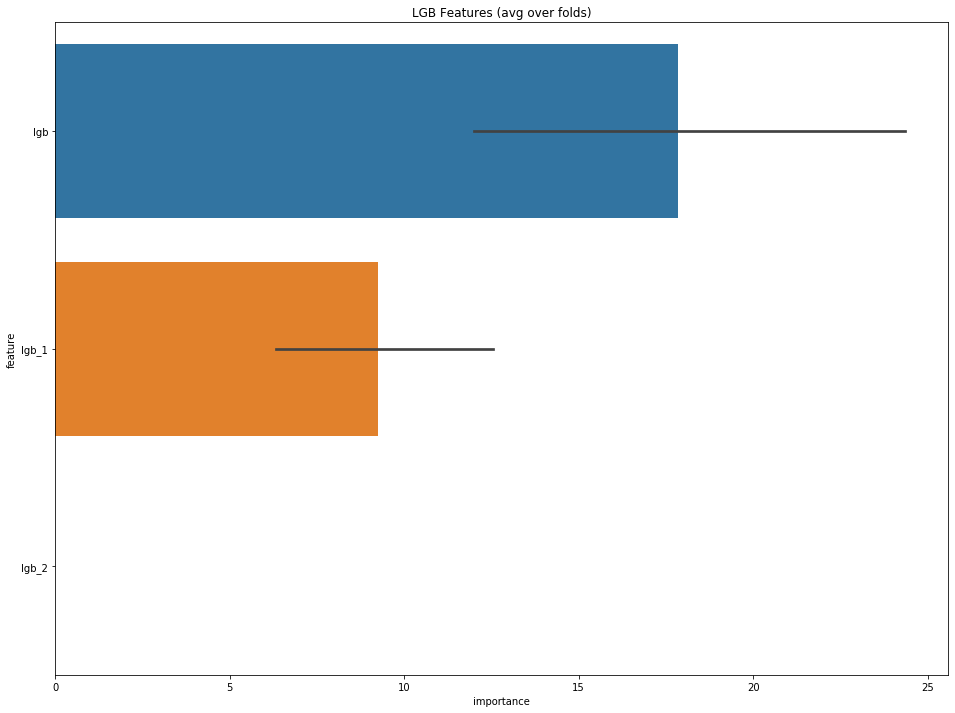

In [254]:
params = {'num_leaves': 30,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 9,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

Fold 0 started at Tue Dec 17 12:33:07 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0975904	valid_1's rmse: 0.0386955
[2000]	training's rmse: 0.0975896	valid_1's rmse: 0.0386903
[3000]	training's rmse: 0.0975896	valid_1's rmse: 0.0386903
[4000]	training's rmse: 0.0975896	valid_1's rmse: 0.0386903
Early stopping, best iteration is:
[3987]	training's rmse: 0.0975896	valid_1's rmse: 0.0386903
Fold 1 started at Tue Dec 17 12:33:17 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.0931795	valid_1's rmse: 0.0718062
[2000]	training's rmse: 0.0923334	valid_1's rmse: 0.0713766
[3000]	training's rmse: 0.0918048	valid_1's rmse: 0.0710994
[4000]	training's rmse: 0.0914703	valid_1's rmse: 0.0709212
[5000]	training's rmse: 0.0912567	valid_1's rmse: 0.0708068
[6000]	training's rmse: 0.0911192	valid_1's rmse: 0.0707316
[7000]	training's rmse: 0.0910304	valid_1's rmse: 0.0706827
[8000]	training's rmse: 0.0909729

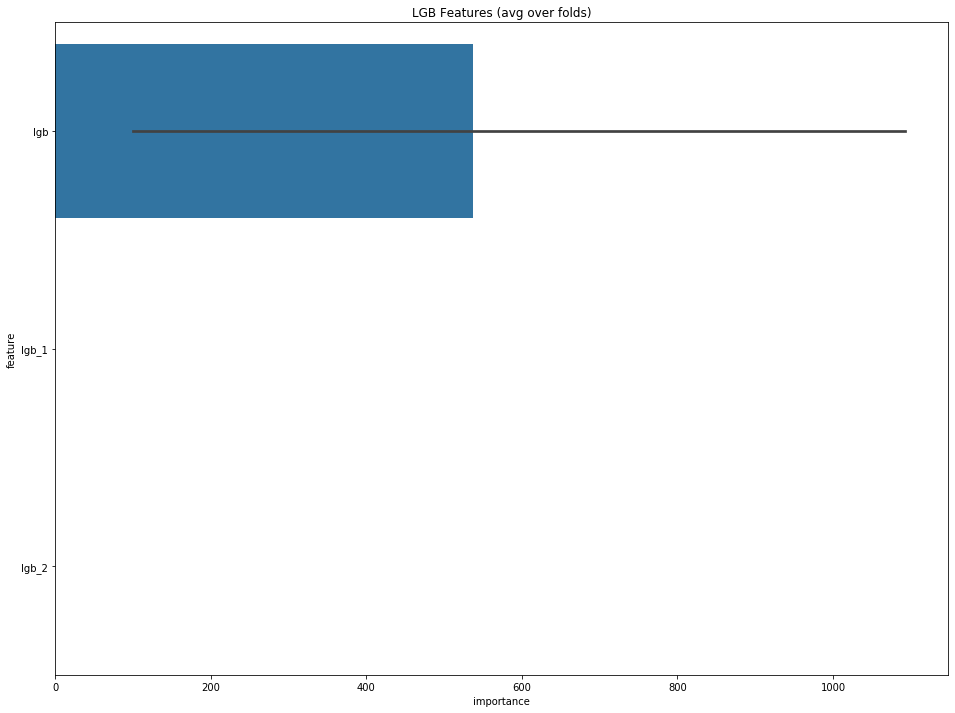

In [255]:
#lgb 作为meta
params = {'num_leaves': 8,
         'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 3,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1}
oof_lgb_stack,  _ = train_model(train_stack, y, params=params, model_type='lgb', plot_feature_importance=True)

##### catboost作为第二层融合模型

In [256]:
cat_params = {'learning_rate': 0.002,
              'depth': 5,
              'l2_leaf_reg': 10,
              # 'bootstrap_type': 'Bernoulli',
              'colsample_bylevel': 0.8,
              'bagging_temperature': 0.2,
              #'metric_period': 500,
              'od_type': 'Iter',
              'od_wait': 100,
              'random_seed': 11,
              'allow_writing_files': False}
oof_cat_stack = train_model(train_stack,y,params = cat_params,model_type = 'cat')

Fold 0 started at Tue Dec 17 12:35:26 2019
Fold 1 started at Tue Dec 17 12:35:30 2019
Fold 2 started at Tue Dec 17 12:35:43 2019
Fold 3 started at Tue Dec 17 12:35:46 2019
Fold 4 started at Tue Dec 17 12:35:50 2019
Fold 5 started at Tue Dec 17 12:36:00 2019
Fold 6 started at Tue Dec 17 12:36:03 2019
Fold 7 started at Tue Dec 17 12:36:05 2019
Fold 8 started at Tue Dec 17 12:36:05 2019
Fold 9 started at Tue Dec 17 12:36:15 2019
CV mean score: 0.0750, std: 0.0550.


##### randomforest作为第二层融合模型

In [257]:
rfrmodel = RandomForestRegressor(
    n_estimators = 20, 
    min_samples_leaf = 4, 
    max_features = 0.3, 
    n_jobs = -1,
    oob_score = True, 
    random_state = 42
)

oof_rfr_stack = train_model(train_stack,y,model_type = 'rfr',params = None,model = rfrmodel)

Fold 0 started at Tue Dec 17 12:36:17 2019
Fold 1 started at Tue Dec 17 12:36:17 2019
Fold 2 started at Tue Dec 17 12:36:17 2019
Fold 3 started at Tue Dec 17 12:36:17 2019
Fold 4 started at Tue Dec 17 12:36:18 2019
Fold 5 started at Tue Dec 17 12:36:18 2019
Fold 6 started at Tue Dec 17 12:36:18 2019
Fold 7 started at Tue Dec 17 12:36:18 2019
Fold 8 started at Tue Dec 17 12:36:19 2019
Fold 9 started at Tue Dec 17 12:36:19 2019
CV mean score: 0.0852, std: 0.0540.


##### xgboost作为第二层融合模型

In [258]:
xgb_params = {'eta': 0.01,
              'objective': 'reg:linear',
              'max_depth': 7,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'eval_metric': 'rmse',
              'seed': 11,
              'silent': True}
oof_xgb_stack = train_model(train_stack,  y, params=xgb_params, model_type='xgb', plot_feature_importance=False)

Fold 0 started at Tue Dec 17 12:36:19 2019
[0]	train-rmse:0.207395	valid_data-rmse:0.153821
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[218]	train-rmse:0.05915	valid_data-rmse:0.052206

Fold 1 started at Tue Dec 17 12:36:19 2019
[0]	train-rmse:0.197733	valid_data-rmse:0.238053
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[500]	train-rmse:0.031304	valid_data-rmse:0.073844
Stopping. Best iteration:
[330]	train-rmse:0.042762	valid_data-rmse:0.069445

Fold 2 started at Tue Dec 17 12:36:19 2019
[0]	train-rmse:0.200642	valid_data-rmse:0.216452
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
Stopping. Best iteration:
[49]	train-rmse:0.134717

##### svr 作为第二层融合模型

In [259]:
param_grid = {
    "kernel": ("linear", 'rbf'), 
    "C": np.logspace(-3, 3, 7), 
    "gamma": np.logspace(-3, 3, 7)}

svr = GridSearchCV(SVR(), param_grid=param_grid,n_jobs = -1,scoring='neg_mean_squared_error')
svr = SVR()
oof_svr_stack = train_model(train_stack, y, params=None,model_type='svr',model = svr)

Fold 0 started at Tue Dec 17 12:36:20 2019
Fold 1 started at Tue Dec 17 12:36:20 2019
Fold 2 started at Tue Dec 17 12:36:20 2019
Fold 3 started at Tue Dec 17 12:36:20 2019
Fold 4 started at Tue Dec 17 12:36:20 2019
Fold 5 started at Tue Dec 17 12:36:20 2019
Fold 6 started at Tue Dec 17 12:36:20 2019
Fold 7 started at Tue Dec 17 12:36:20 2019
Fold 8 started at Tue Dec 17 12:36:20 2019
Fold 9 started at Tue Dec 17 12:36:20 2019
CV mean score: 0.0876, std: 0.0476.


##### 岭回归做第二层融合模型

In [260]:
model = linear_model.RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=folds)
oof_rcv_stack  = train_model(train_stack.values, y, params=None, model_type='sklearn', model=model)

Fold 0 started at Tue Dec 17 12:36:20 2019
Fold 1 started at Tue Dec 17 12:36:20 2019
Fold 2 started at Tue Dec 17 12:36:20 2019
Fold 3 started at Tue Dec 17 12:36:20 2019
Fold 4 started at Tue Dec 17 12:36:20 2019
Fold 5 started at Tue Dec 17 12:36:20 2019
Fold 6 started at Tue Dec 17 12:36:21 2019
Fold 7 started at Tue Dec 17 12:36:21 2019
Fold 8 started at Tue Dec 17 12:36:21 2019
Fold 9 started at Tue Dec 17 12:36:21 2019
CV mean score: 0.0828, std: 0.0475.


In [261]:
print(scorelist)

[0.08723429374360932, 0.08174246885324905, 0.08174246885324905, 0.08174246885324905, 0.08093938725021521, 0.06886375333935892, 0.06784489035089612, 0.07192399908051998, 0.07235114157283676, 0.06782460563789215, 0.07278165740652326, 0.07252526327453092, 0.07940355180199207, 0.06609507513580745, 0.07158698776610599, 0.07256469710732714, 0.06641549976267155, 0.0687346662148649, 0.06934570526779674, 0.07894937795959608, 0.06744169817512491, 0.07712719512824785, 0.07794623549353442, 0.07152651028034326, 0.07851280300324491, 0.07591358723303018, 0.08013398497121008, 0.06922057431382704, 0.07167863337832019, 0.0722110690272573, 0.0668798182776911, 0.07178662707708813, 0.07635927130241957, 0.07913393845087843, 0.06299294501927, 0.07156953552345276, 0.07180712651765568, 0.06740059022970826, 0.0699894740123654, 0.07552791155179042, 0.07996034817566745, 0.06493817460018345, 0.07196674774406128, 0.07228633237900203, 0.0694102445875323, 0.07425281841678615, 0.07342148454115051, 0.08055686172908702,

In [262]:
min(scorelist)

0.06299294501927

In [263]:
scorelist[0:7]

[0.08723429374360932,
 0.08174246885324905,
 0.08174246885324905,
 0.08174246885324905,
 0.08093938725021521,
 0.06886375333935892,
 0.06784489035089612]